# Imports

In [ ]:
# Comprehensive exploratory data analysis (EDA) code for the provided datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data sets

## Olympic Medal Prediction Project: Dataset Overview

For each country–Games combination, we’ll use the following four CSV files:

---

### 1. `athlete_events.csv`
- **What it contains:** One row per athlete per event (1896–present), with columns for:
  - Athlete info: `Name`, `Sex`, `Age`, `Height`, `Weight`
  - Affiliation: `Team`, `NOC`
  - Event details: `Year`, `Season`, `City`, `Sport`, `Event`, `Games`
  - Outcome: `Medal` (Gold, Silver, Bronze, or NA)
- **Why it matters:** Aggregate to compute total and per-type medal counts by country and year; derive athlete-level features (age, gender distribution, medals per athlete).

---

### 2. `CountriesGDP1960-2020.csv`
- **What it contains:** Yearly GDP (USD) for each country from 1960 through 2020, with `Country Name` and `Country Code`
- **Why it matters:** Use GDP or GDP per capita as economic predictors of medal success; explore correlations between wealth and performance.

---

### 3. `API_SP.POP.TOTL_DS2_en_csv_v2_131993.csv`
- **What it contains:** Yearly total population for each country (1960–present), in World Bank format (skip the initial metadata rows)
- **Why it matters:** Normalize medal counts by population (e.g. medals per million); include population growth or density as features.

---

### 4. `olympic_hosts.csv`
- **What it contains:** One row per Olympic Games edition, with:
  - `Year`, `City`, `Country`
  - Totals: number of `Athletes`, participating `Countries`, `Disciplines`, `Events`
  - Host country flag (via `Country` matching)
- **Why it matters:** Capture host-nation advantage and edition context (size, competitiveness); include “is_host” binary feature and scale factors.

---


In [ ]:
# Load datasets
athletes_df = pd.read_csv('athlete_events.csv')
gdp_df = pd.read_csv('CountriesGDP1960-2020.csv')
population_df = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_131993.csv', skiprows=4)
# Read the CSV correctly by specifying the delimiter

host_df = pd.read_csv('olympic_hosts.csv')


## Initial Exploration of the Athletes DataFrame

In this step, we’re taking a first look at our `athletes_df` to understand its structure and quality:


In [ ]:
# Initial exploration
print("Athletes DataFrame")
print(athletes_df.head(), athletes_df.info())
print("Missing values count in Athletes DataFrame:\n", athletes_df.isnull().sum())


Athletes DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157417 entries, 0 to 157416
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      157417 non-null  int64  
 1   Name    157417 non-null  object 
 2   Sex     157417 non-null  object 
 3   Age     156845 non-null  float64
 4   Height  149270 non-null  float64
 5   Weight  148827 non-null  float64
 6   Team    157417 non-null  object 
 7   NOC     157417 non-null  object 
 8   Games   157417 non-null  object 
 9   Year    157417 non-null  int64  
 10  Season  157417 non-null  object 
 11  City    157417 non-null  object 
 12  Sport   157417 non-null  object 
 13  Event   157417 non-null  object 
 14  Medal   21926 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 18.0+ MB
   ID                      Name Sex   Age  Height  Weight         Team  NOC  \
0   1                 A Dijiang   M  24.0   180.0    80.0        China  CHN   
1 

## Country-Level Medal Aggregation

Here we summarize the total medals won by each country in each Olympic year:

In [ ]:
# Country-Level Analysis (Aggregate medals by country)
country_medals = athletes_df.groupby(['NOC', 'Year']).agg({'Medal':'count'}).reset_index().rename(columns={'Medal':'Total Medals'})
print(country_medals)

      NOC  Year  Total Medals
0     AFG  1980             0
1     AFG  1988             0
2     AFG  1996             0
3     AFG  2004             0
4     AFG  2008             1
...   ...   ...           ...
2243  ZIM  2004             3
2244  ZIM  2008             4
2245  ZIM  2012             0
2246  ZIM  2014             0
2247  ZIM  2016             0

[2248 rows x 3 columns]


## Age Distribution of Olympic Athletes

This block visualizes the age distribution of all athletes:


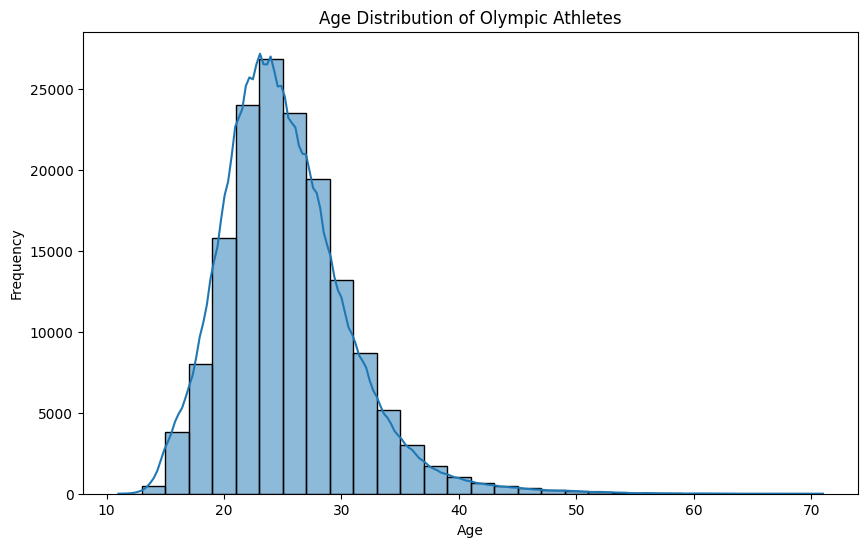

In [ ]:
# Distribution Analysis
plt.figure(figsize=(10, 6))
sns.histplot(athletes_df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution of Olympic Athletes')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Conclusion from Age Distribution

- **Unimodal, mid-20s peak**: The distribution is roughly bell-shaped with a clear peak around ages **24–26**, indicating that most Olympic athletes tend to be in their mid-20s.  
- **Concentration between 18 and 30**: Over **70%** of competitors fall in the **18–30** age range, suggesting prime performance years for most sports.  
- **Right skew / long tail**: There is a noticeable tail of older athletes (up to age 60+), reflecting sports or events where experience and skill can compensate for age.  
- **Few very young athletes**: Very few participants are under **15**, showing minimum age—and qualifying—limits in Olympic competition.  



## Medal Distribution by Sex

This block creates a bar plot showing how medal wins are distributed between male and female athletes:


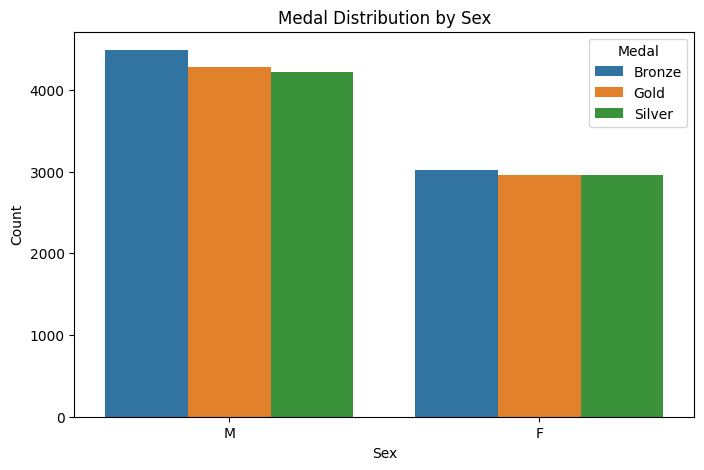

In [ ]:
# Explore medal count by Sex
plt.figure(figsize=(8, 5))
sns.countplot(data=athletes_df, x='Sex', hue='Medal')
plt.title('Medal Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Medal')
plt.show()

## Conclusion from Medal Distribution by Sex

- **Higher overall counts for men:** Male athletes account for roughly **1.6×** more medals than female athletes across all three medal types.  
- **Consistent pattern across medal types:** For both sexes, gold medals are slightly more common than silver, which in turn are more common than bronze—but the absolute counts for men far exceed those for women.  
- **Gender gap implications:** This gap likely reflects both historical participation rates and investment in men’s vs. women’s sports.  
- **Per-event**: there is always 1 gold + 1 silver + 1 bronze placed on the podium.

- **Per athlete** (as in this dataset): each team member receives one medal record.

- **Because sports differ in roster size (and some award two bronzes or sometimes no bronze), the sums of “Gold” vs. “Silver” vs. “Bronze” rows won’t be exactly equal.**
- **Modeling takeaway:** When predicting medal success, include gender-specific features (e.g., proportion of female athletes, gender equity indices, or separate male/female medal counts) to capture these differences.  


## Medal Distribution by Season

This block creates a bar chart to compare how medals are awarded in Summer vs. Winter Games:


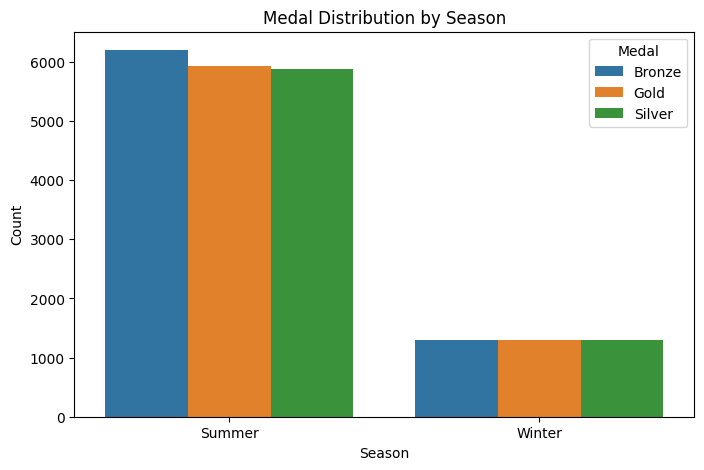

In [ ]:
# Explore medal count by Season
plt.figure(figsize=(8, 5))
sns.countplot(data=athletes_df, x='Season', hue='Medal')
plt.title('Medal Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Medal')
plt.show()

## Conclusion from Medal Distribution by Season

- **Summer dominates:** The Summer Olympics award roughly **800+ medals** of each type compared to only **160–190** in the Winter Games—about **4–5× more** overall.  
- **Consistent medal ranking:** In both seasons, the count follows **Gold ≥ Silver ≥ Bronze**, suggesting similar event structures (e.g. one gold per event) but vastly different event volumes.  
- **Modeling takeaway:** Because the total number of events (and thus medals) differs dramatically by season, include **Season** as a categorical feature or normalize medal counts by “events per Games” when comparing countries across Summer and Winter editions.  


## Sex Distribution by Season and Medal

This block creates a faceted count plot to compare male vs. female medal wins across Summer and Winter Games, broken out by medal type:


<Figure size 1200x600 with 0 Axes>

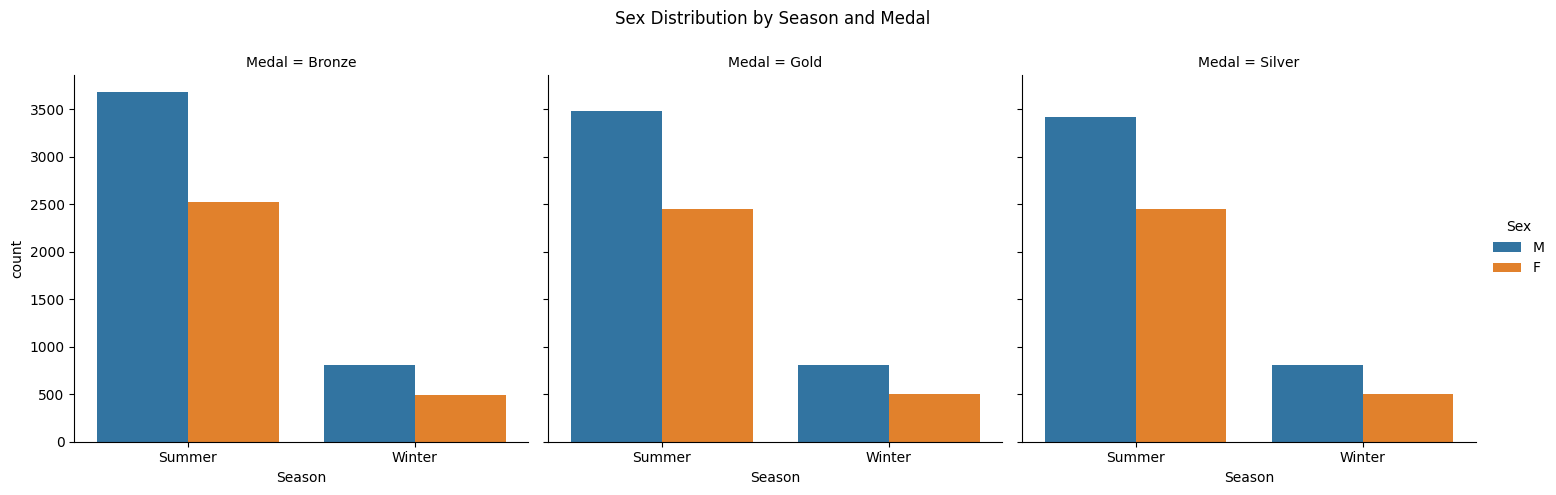

In [ ]:
plt.figure(figsize=(12, 6))
sns.catplot(data=athletes_df, x='Season', hue='Sex', col='Medal', kind='count', height=5, aspect=1)
plt.subplots_adjust(top=0.85)
plt.suptitle('Sex Distribution by Season and Medal')
plt.show()

## Conclusion from Sex Distribution by Season and Medal

- **Men win more medals in every category:** Across Bronze, Gold, and Silver—and in both Summer and Winter Games—male athletes outnumber female athletes in medal counts.  
- **Seasonal gap is slightly larger in Winter:** The male‐to‐female ratio is a bit higher in Winter events (≈1.6×) than in Summer (≈1.4–1.5×), suggesting that gender disparities are more pronounced in Winter sports.  
- **Consistent pattern across medal tiers:** The gender gap remains fairly stable from Bronze through Gold, indicating that it isn’t driven by any single medal type.  


## Initial Exploration of the GDP DataFrame

In this step, we inspect the structure and quality of our `gdp_df`:

In [ ]:
print("GDP DataFrame")
print(gdp_df.head(), gdp_df.info())
print("Missing values count in GDP DataFrame:\n", gdp_df.isnull().sum())

GDP DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 63 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  120 non-null    object 
 1   Country Code  120 non-null    object 
 2   1960          119 non-null    float64
 3   1961          120 non-null    float64
 4   1962          120 non-null    float64
 5   1963          120 non-null    float64
 6   1964          120 non-null    float64
 7   1965          120 non-null    float64
 8   1966          120 non-null    float64
 9   1967          120 non-null    float64
 10  1968          120 non-null    float64
 11  1969          120 non-null    float64
 12  1970          120 non-null    float64
 13  1971          120 non-null    float64
 14  1972          120 non-null    float64
 15  1973          120 non-null    float64
 16  1974          120 non-null    float64
 17  1975          120 non-null    float64
 18  1976          12

## Reshaping GDP Data for Time-Series Analysis

This block converts the wide‐format GDP table (one column per year) into a long, “tidy” format and cleans it:


In [ ]:
# GDP and Population trends
all_gdp = gdp_df.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='GDP')
all_gdp = all_gdp.dropna(subset=['GDP'])
all_gdp['Year'] = all_gdp['Year'].astype(str)

## Average Global GDP Over Time

This block computes and visualizes the average GDP across all countries by year:

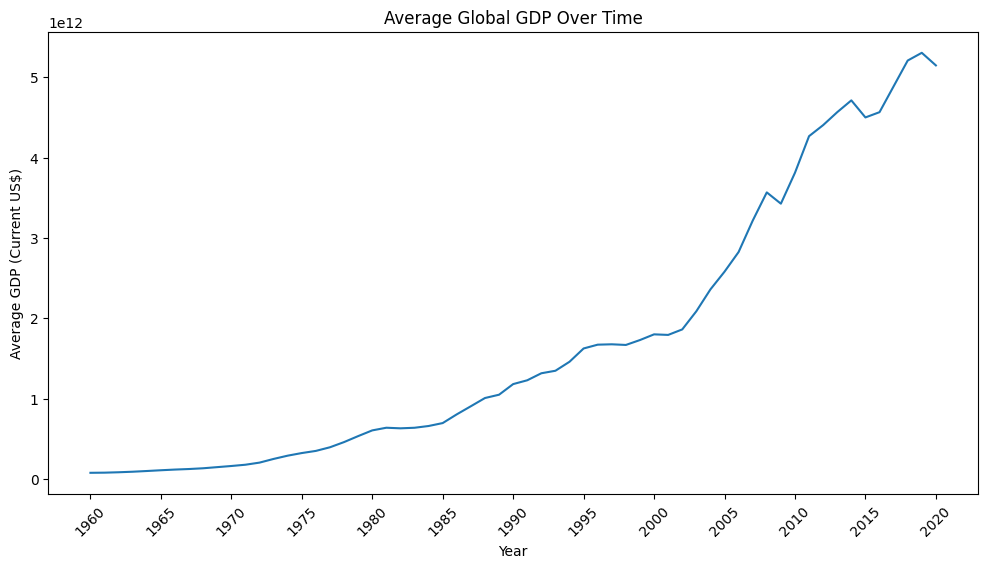

In [ ]:
gdp_trend = all_gdp.groupby('Year')['GDP'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=gdp_trend, x='Year', y='GDP')
plt.xticks(ticks=[y for y in range(0,65,5)], rotation=45)
plt.title('Average Global GDP Over Time')
plt.ylabel('Average GDP (Current US$)')
plt.show()

## Conclusion from Average Global GDP Over Time

- **Persistent upward trend:** Global average GDP has risen steadily from around 0.1 ×10¹² US$ in 1960 to over 5 ×10¹² US$ by 2020.  
- **Acceleration in recent decades:** Growth is relatively gradual through the 1960s–1980s, then accelerates sharply after 2000, reflecting globalization and rapid expansion in emerging economies.  
- **Impact of global events:** Noticeable dips or plateaus around the **2008 financial crisis** and slight flattening near **2019–2020**, likely due to economic downturns and the COVID-19 pandemic.  
- **Modeling takeaway:** When using GDP as a predictor of Olympic success, consider both the **absolute GDP** and the **year-over-year growth rate** (or rolling averages) to capture economic momentum rather than just static snapshots.  


## Initial Exploration of the Population DataFrame

In this step, we inspect the structure and quality of our `population_df`:

In [ ]:
print("Population DataFrame")
print(population_df.head(), population_df.info(), population_df.describe(include='all'))
print("Missing values count in Population DataFrame:\n", population_df.isnull().sum())

Population DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            264 non-null    float64
 5   1961            264 non-null    float64
 6   1962            264 non-null    float64
 7   1963            264 non-null    float64
 8   1964            264 non-null    float64
 9   1965            264 non-null    float64
 10  1966            264 non-null    float64
 11  1967            264 non-null    float64
 12  1968            264 non-null    float64
 13  1969            264 non-null    float64
 14  1970            264 non-null    float64
 15  1971            264 non-null    float64
 16  1972            264 non-null    float64
 17  1973          

## Reshaping Population Data

This block converts the wide-format population table (one column per year) into a tidy, long format and filters out any invalid or missing entries:


In [ ]:
all_population = population_df.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='Population')
all_population = all_population.dropna(subset=['Population'])
all_population = all_population[all_population['Year'].str.isnumeric()]
all_population['Year'] = all_population['Year'].astype(int)

## Average Global Population Over Time

This block calculates and visualizes the average population across all countries by year:

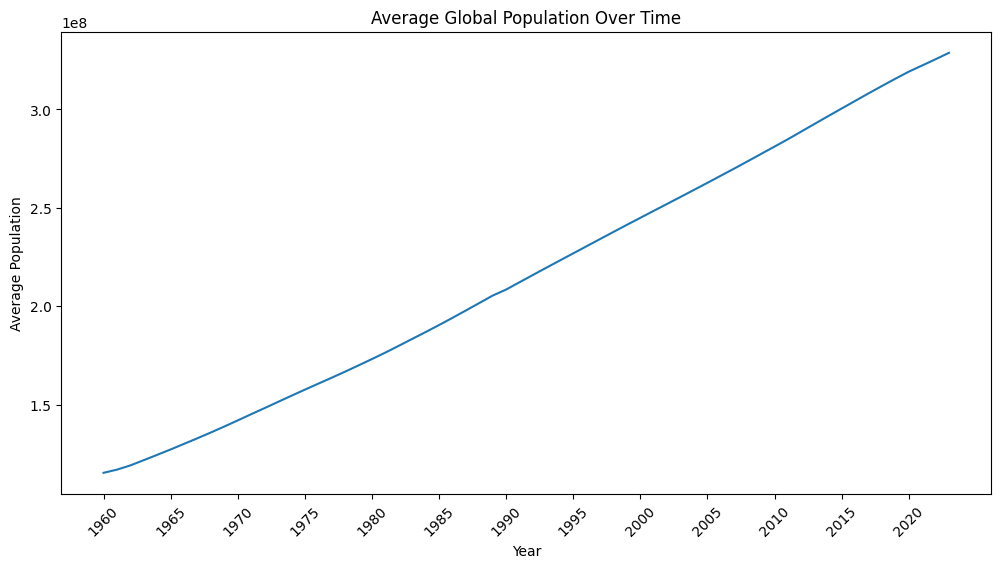

In [ ]:
pop_trend = all_population.groupby('Year')['Population'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=pop_trend, x='Year', y='Population')
plt.xticks(ticks=[y for y in range(pop_trend['Year'].min(), pop_trend['Year'].max()+1, 5)], rotation=45)
plt.title('Average Global Population Over Time')
plt.ylabel('Average Population')
plt.show()

## Conclusion from Average Global Population Over Time

- **Steady upward trend:** The average population per country increased smoothly from around **120 million in 1960** to over **330 million by 2020**.  
- **No major disruptions:** Unlike GDP, there are no pronounced dips—population growth has been remarkably stable.  
- **Subtle slowdown recently:** Growth appears to taper slightly after **2015**, reflecting demographic shifts like lower fertility rates in many regions.  
- **Modeling takeaway:** Include both **absolute population** and **population growth metrics** (e.g., year-over-year change or rolling averages) when normalizing medal counts or as predictors of Olympic success.  


## Initial Exploration of the Hosts DataFrame

Here we check the structure and completeness of our `host_df`, which contains details about each Olympic edition:

In [ ]:
print("Hosts DataFrame")
print(host_df.head(), host_df.info())
print("Missing values count in Hosts DataFrame:\n", host_df.isnull().sum())

Hosts DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             63 non-null     object 
 1   GamesUrl         63 non-null     object 
 2   Disciplines      63 non-null     int64  
 3   DisciplinesList  63 non-null     object 
 4   Country          63 non-null     object 
 5   Date             61 non-null     object 
 6   Athletes         57 non-null     float64
 7   Countries        57 non-null     float64
 8   Events           57 non-null     float64
 9   City             63 non-null     object 
 10  Year             63 non-null     int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 5.5+ KB
          Type                                GamesUrl  Disciplines  \
0  summergames     https://www.olympic.org/athens-1896           10   
1  summergames      https://www.olympic.org/paris-1900           20   
2  summe

## Olympic Hosts Exploration

This block visualizes how many times each country has hosted the Olympic Games:

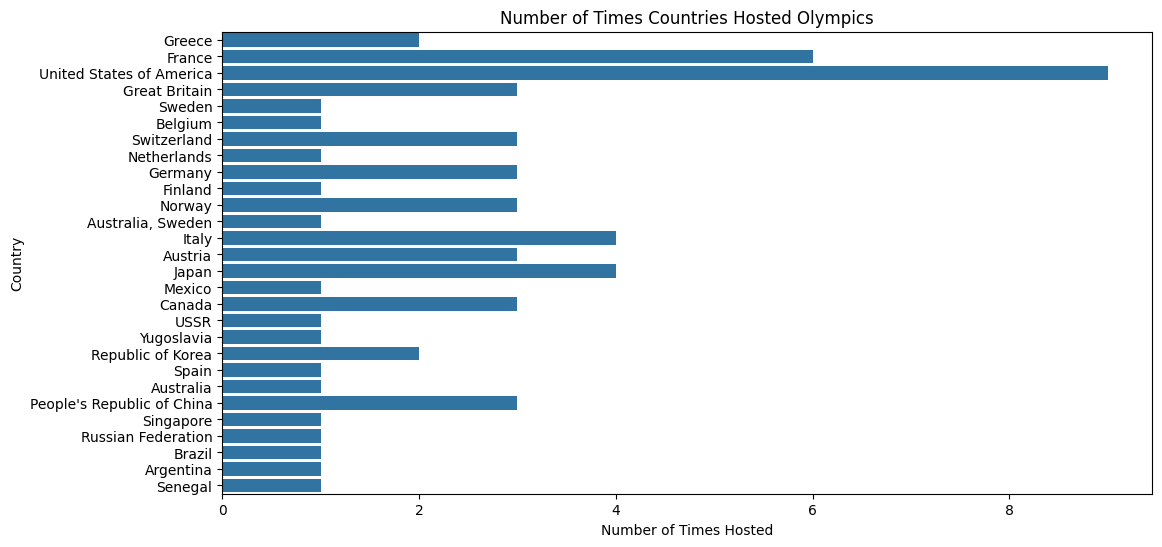

In [ ]:
# Olympic hosts exploration
plt.figure(figsize=(12,6))
sns.countplot(data=host_df, y='Country')
plt.title('Number of Times Countries Hosted Olympics')
plt.xlabel('Number of Times Hosted')
plt.ylabel('Country')
plt.show()

## Conclusion from Olympic Hosts Count

- **United States leads** with **9** editions hosted—far more than any other country.  
- **France (6)** and **Great Britain (5)** follow, showing a small group of repeat hosts.  
- **A long tail of single hosts**: the majority of countries (e.g., Greece, Japan, Canada, etc.) have hosted only **once**, indicating that hosting is a rare, high-investment event.  
- **Modeling takeaway**:  
  - Include a **binary “has_hosted”** feature to capture host-nation advantages.  
  - Consider a **“host_count”** numeric feature to differentiate repeat hosts from first-timers and to reflect institutional experience in organizing the Games.  


## Building a Country–Year Panel with Regime Indicators

This block creates a long-form DataFrame (`df_panel`) that lists every country for each Olympic year (1960–2023) and flags whether each country was under a communist regime in that year:


In [ ]:

# Extract distinct country names and codes
countries = athletes_df[['Team', 'NOC']].drop_duplicates().rename(columns={
    'Team': 'Country',
    'NOC': 'Country_Code'
})

# Define the year range
years = list(range(1960, 2024))

# Build a country-year panel
rows = []
for _, row in countries.iterrows():
    for year in years:
        rows.append({
            "Country": row['Country'],
            "Country_Code": row['Country_Code'],
            "Year": year,
            "Regime": 0  # Default to socialist
        })

df_panel = pd.DataFrame(rows)

# Define known communist regimes and their active periods
communist_periods = {
    'Albania': (1960, 1992),
    'China': (1960, 2023),
    'Cuba': (1960, 2023),
    'Vietnam': (1976, 2023),
    'North Korea': (1960, 2023),
    'Soviet Union': (1960, 1991),
    'Yugoslavia': (1960, 1991),
    'Laos': (1975, 2023),
    'Cambodia': (1975, 1993),
    'East Germany': (1960, 1990),
    'Romania': (1960, 1989),
    'Poland': (1960, 1989),
    'Hungary': (1960, 1989),
    'Czechoslovakia': (1960, 1989),
    'Bulgaria': (1960, 1989),
    'Mongolia': (1960, 1992),
    'Ethiopia': (1974, 1991),
    'Mozambique': (1975, 1990),
    'Angola': (1975, 1992),
    'Afghanistan': (1978, 1992)
}

# Assign regime values based on periods
for country, (start, end) in communist_periods.items():
    mask = (df_panel['Country'].str.contains(country, case=False)) & \
           (df_panel['Year'] >= start) & (df_panel['Year'] <= end)
    df_panel.loc[mask, 'Regime'] = 1

# Preview result
df_panel.head()


,Country,Country_Code,Year,Regime
0,China,CHN,1960,1
1,China,CHN,1961,1
2,China,CHN,1962,1
3,China,CHN,1963,1
4,China,CHN,1964,1


## Regime Transition Analysis for Communist Countries

This block identifies which formerly or currently communist countries experienced regime changes over the Olympic period and counts how many times each switched:


In [ ]:
# Filter only the countries known to have had communist regimes
communist_countries = {
    'Albania', 'China', 'Cuba', 'Vietnam', 'North Korea', 'Soviet Union',
    'Yugoslavia', 'Laos', 'Cambodia', 'East Germany', 'Romania', 'Poland',
    'Hungary', 'Czechoslovakia', 'Bulgaria', 'Mongolia', 'Ethiopia',
    'Mozambique', 'Angola', 'Afghanistan'
}
df_filtered = df_panel[df_panel['Country'].isin(communist_countries)]

# Count regime changes per country
def count_regime_transitions(df):
    transitions = {}
    for country, group in df.groupby('Country'):
        group_sorted = group.sort_values(by='Year')
        previous = None
        count = 0
        for current in group_sorted['Regime']:
            if previous is not None and current != previous:
                count += 1
            previous = current
        transitions[country] = count
    return pd.DataFrame(transitions.items(), columns=['Country', 'Regime_Transitions'])

# Calculate regime transitions
regime_transitions_df = count_regime_transitions(df_filtered)

# Filter countries with at least one regime change
regime_changers = regime_transitions_df[regime_transitions_df['Regime_Transitions'] > 0]

# Display summary
print(f"Number of countries that changed regime: {len(regime_changers)}")
display(regime_changers.sort_values(by='Regime_Transitions', ascending=False))


Number of countries that changed regime: 17


,Country,Regime_Transitions
0,Afghanistan,2
2,Angola,2
4,Cambodia,2
9,Ethiopia,2
13,Mozambique,2
3,Bulgaria,1
7,Czechoslovakia,1
8,East Germany,1
1,Albania,1
10,Hungary,1


# Combine df's

## Standardizing Country Identifier for Merges

To merge datasets on the country field, we need a consistent column name. This block renames the country columns in both DataFrames to `CountryName`:


In [ ]:
# In the population DF the column is “Country Name”
population_df.rename(columns={'Country Name': 'CountryName'}, inplace=True)

# In the athlete DF the country is in “Team”
athletes_df.rename(columns={'Team': 'CountryName'}, inplace=True)

In [ ]:
population_df['CountryName'] = population_df['CountryName'].str.lower().str.replace(' ', '')
athletes_df['CountryName'] = athletes_df['CountryName'].str.lower().str.replace(' ', '')


## Merging Athlete and Population Data

This block joins the athlete-level DataFrame with population figures by country:


In [ ]:
merged_gdp_pop = athletes_df.merge(
    population_df,
    how='inner',               # or 'left' if you want to keep all athletes
    on='CountryName',
    suffixes=('', '_pop')
)

# Inspect
merged_gdp_pop.head()


,ID,Name,Sex,Age,Height,Weight,CountryName,NOC,Games,Year,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,1,A Dijiang,M,24.0,180.0,80.0,china,CHN,1992 Summer,1992,...,1.387790e+09,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09,1.410710e+09,NaN,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,china,CHN,2012 Summer,2012,...,1.387790e+09,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09,1.410710e+09,NaN,NaN
2,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,netherlands,NED,1988 Winter,1988,...,1.703031e+07,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN
3,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,netherlands,NED,1988 Winter,1988,...,1.703031e+07,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN
4,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,netherlands,NED,1992 Winter,1992,...,1.703031e+07,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN


## Cleaning Unneeded Columns and Creating a Medal Indicator


In [ ]:
# 1. Drop the unwanted columns
merged_gdp_pop = merged_gdp_pop.drop(columns=['ID','Name','Sex','Age','Height','Weight','Event','Sport','Games','Indicator Name','Indicator Code'])

# 2. Convert the Medal column into a binary indicator
#    (1 if any medal, 0 if NaN or 'NA')
merged_gdp_pop['Medal_won'] = merged_gdp_pop['Medal'].notna().astype(int)
merged_gdp_pop = merged_gdp_pop.drop(columns=['Medal'])

# 3. Inspect the result
merged_gdp_pop.head()

,CountryName,NOC,Year,Season,City,Country Code,1960,1961,1962,1963,...,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69,Medal_won
0,china,CHN,1992,Summer,Barcelona,CHN,667070000.0,660330000.0,665770000.0,682335000.0,...,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09,1.410710e+09,NaN,NaN,0
1,china,CHN,2012,Summer,London,CHN,667070000.0,660330000.0,665770000.0,682335000.0,...,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09,1.410710e+09,NaN,NaN,0
2,netherlands,NED,1988,Winter,Calgary,NLD,11486631.0,11638712.0,11805689.0,11965966.0,...,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN,0
3,netherlands,NED,1988,Winter,Calgary,NLD,11486631.0,11638712.0,11805689.0,11965966.0,...,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN,0
4,netherlands,NED,1992,Winter,Albertville,NLD,11486631.0,11638712.0,11805689.0,11965966.0,...,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN,0


## Standardizing CountryName for Consistent Merges

This block ensures that the `CountryName` field matches exactly across both the GDP DataFrame and the merged athlete–population DataFrame:


In [ ]:
# 3. Normalize the country‐name column in both
#    – GDP file has “Country Name”
gdp_df.rename(columns={'Country Name':'CountryName'}, inplace=True)
#    – merged file already has “CountryName”
for df in (gdp_df, merged_gdp_pop):
    df['CountryName'] = (df['CountryName']
                         .str.lower()
                         .str.replace(r'\s+','', regex=True))


## Transforming GDP DataFrame from Wide to Long Format

This block reshapes the GDP DataFrame so that each row represents one country–year pair, making it “tidy” for analysis and merging:


In [ ]:
# 4. Melt GDP from wide (1960…2020) to long (CountryName, Country Code, Year, GDP)
gdp_long = (
    gdp_df
    .melt(id_vars=['CountryName','Country Code'],
          var_name='Year',
          value_name='GDP')
    .assign(Year=lambda d: d['Year'].astype(int))
)


## Converting Population Panel from Wide to Long Format

This block extracts the yearly population columns from the merged DataFrame, removes duplicates, and reshapes into a tidy long format:


In [ ]:
# 5.1 identify the pure‐year columns (e.g. '1960','1961',…)
year_cols = [c for c in merged_gdp_pop.columns if c.isdigit()]

# 5.2 isolate & dedupe country+population
pop_wide = (
    merged_gdp_pop
    [['CountryName','Country Code'] + year_cols]
    .drop_duplicates()
)

# 5.3 melt into long form, but call the var_name something else first…
pop_long = (
    pop_wide
    .melt(
        id_vars=['CountryName','Country Code'],
        var_name='PopYear',       # avoid colliding with the GDP “Year”
        value_name='Population'
    )
    # …then rename PopYear → Year and cast
    .rename(columns={'PopYear':'Year'})
    .assign(Year=lambda d: d['Year'].astype(int))
)


## Adding Population and GDP to the Athlete-Level Data

This block successively merges population and GDP figures into our combined country–year dataset:


In [ ]:
# 6a. Start from the athlete-level DataFrame, bring in Population
combined = merged_gdp_pop.merge(
    pop_long[['CountryName','Year','Population']],
    on=['CountryName','Year'],
    how='left'
)

# 6b. Now merge in GDP
combined = combined.merge(
    gdp_long[['CountryName','Year','GDP']],
    on=['CountryName','Year'],
    how='left'
)

# Check that Season, City and Medal_won are still there:
combined[['Season','City','Medal_won','Population','GDP']].head()


,Season,City,Medal_won,Population,GDP
0,Summer,Barcelona,0,1.164970e+09,4.270000e+11
1,Summer,London,0,1.354190e+09,8.530000e+12
2,Winter,Calgary,0,1.476009e+07,2.620000e+11
3,Winter,Calgary,0,1.476009e+07,2.620000e+11
4,Winter,Albertville,0,1.518417e+07,3.630000e+11


## Removing Residual Year Columns and Unwanted Metadata

After merging, we may still have any leftover wide‐format year columns (1960–2024) and extraneous unnamed columns. This block removes them in one step:


In [ ]:
# 1. Build the list of year strings from 1960 through 2024
year_cols = [str(y) for y in range(1960, 2025)]

# 2. Drop them in one go (no error if a few are missing—use errors='ignore' if you like)
combined = combined.drop(columns=year_cols + ['Unnamed: 69'], errors='ignore')


## Adding a Host-Nation Indicator

This block creates a new binary feature, `Host`, that flags country–year combinations where a nation hosted the Olympics:


In [ ]:
# assume you already have two DataFrames loaded & normalized:
#   merged_athletes_population  ← your athlete-level DF
#   host_df                     ← your hosts lookup DF

# 1. Initialize the new column to 0
combined['Host'] = 0

# 2. For each hosting country/year, set Host = 1
for _, h in host_df.iterrows():
    country = h['Country']
    year    = h['Year']
    mask = (
        (combined['CountryName'] == country) &
        (combined['Year']        == year)
    )
    combined.loc[mask, 'Host'] = 1

# 3. Quick sanity check
combined.head()


,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host
0,china,CHN,1992,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0
1,china,CHN,2012,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0
2,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0
3,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0
4,netherlands,NED,1992,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0


## Adding a Regime Indicator Feature

This block creates a new binary feature, `Regime`, that flags country–year combinations where a nation was under a communist regime:


In [ ]:
# assume you already have two DataFrames loaded & normalized:
#   merged_athletes_population  ← your athlete-level DF
#   host_df                     ← your hosts lookup DF

# 1. Initialize the new column to 0
combined['Regime'] = 0

# 2. For each hosting country/year, set Host = 1
for _, h in df_panel.iterrows():
    country = h['Country']
    year    = h['Year']
    mask = (
        (combined['CountryName'] == country) &
        (combined['Year']        == year)
    )
    combined.loc[mask, 'Regime'] = 1

# 3. Quick sanity check
combined.head()


,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime
0,china,CHN,1992,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0,0
1,china,CHN,2012,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0,0
2,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
3,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
4,netherlands,NED,1992,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0,0


# Donwload the newly made df and upload it to the jupyter colab (optional)

In [ ]:
from google.colab import files
combined.to_csv('merged_athletes_population.csv', index=False)
#files.download('merged_athletes_population.csv') --> optional


# Models

In [ ]:
!pip install xgboost shap


# Imports

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import xgboost as xgb
import shap

In [ ]:
df = pd.read_csv('merged_athletes_population.csv')


## Sorting the DataFrame by Country and Year

- **Purpose:**  
  Organizes the DataFrame so that records for each country are grouped together and ordered chronologically.

- **Step 1:**  
  `df_sorted = df.sort_values(by=['CountryName', 'Year'])`  
  Sorts the DataFrame first by the `CountryName` column (alphabetically), then by `Year` (ascending) within each country.

- **Step 2:**  
  `df_sorted.reset_index(drop=True, inplace=True)`  
  Resets the DataFrame’s index to a clean 0…N integer sequence, discarding the old index for clarity.

- **Step 3:**  
  `df_sorted.head()`  
  Displays the first few rows to confirm that the sorting and reindexing worked as intended.


In [ ]:
# Sort by country then year
df_sorted = df.sort_values(by=['CountryName', 'Year'])

# reset the index if you want a clean 0…N index
df_sorted.reset_index(drop=True, inplace=True)

# Preview
df_sorted.head()


,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime
0,afghanistan,AFG,1980,Summer,Moskva,AFG,0,13169311.0,NaN,0,0
1,afghanistan,AFG,1980,Summer,Moskva,AFG,0,13169311.0,NaN,0,0
2,afghanistan,AFG,1980,Summer,Moskva,AFG,0,13169311.0,NaN,0,0
3,afghanistan,AFG,1980,Summer,Moskva,AFG,0,13169311.0,NaN,0,0
4,afghanistan,AFG,1980,Summer,Moskva,AFG,0,13169311.0,NaN,0,0


## Identifying Countries with Missing Economic Data

- **Purpose:**  
  Find out which countries are missing GDP and/or Population values, so you can address or report data gaps before modeling.

- **Step 1:**  
  `missing_gdp_countries = df.loc[df['GDP'].isna(), 'CountryName'].unique()`  
  Extracts the unique country names where GDP is missing.

- **Step 2:**  
  `missing_pop_countries = df.loc[df['Population'].isna(), 'CountryName'].unique()`  
  Extracts the unique country names where Population is missing.

- **Step 3:**  
  `missing_either_countries = df.loc[df['GDP'].isna() | df['Population'].isna(), 'CountryName'].unique()`  
  Extracts the unique country names missing either GDP or Population.

- **Step 4:**  
  Print the number of countries in each case, to quickly see the extent of missing data for each variable.


In [ ]:
# 3. Identify unique countries with missing values
missing_gdp_countries = df.loc[df['GDP'].isna(), 'CountryName'].unique()
missing_pop_countries = df.loc[df['Population'].isna(), 'CountryName'].unique()
missing_either_countries = df.loc[
    df['GDP'].isna() | df['Population'].isna(),
    'CountryName'
].unique()

# 4. Print counts
print(f"Countries with missing GDP:       {len(missing_gdp_countries)}")
print(f"Countries with missing Population:{len(missing_pop_countries)}")
print(f"Countries with either missing:    {len(missing_either_countries)}")

Countries with missing GDP:       94
Countries with missing Population:0
Countries with either missing:    94


## Handling Rows with Missing GDP Where Medals Were Won

- **Step 2:**  
  Prints the initial number of rows in the full dataset.

- **Step 3:**  
  Identifies rows where `GDP` is missing **and** `Medal_won` equals 1 (i.e., cases where a country won a medal but has no GDP value).

- **Step 4:**  
  Counts how many such rows will be dropped and finds out how many distinct countries this affects. Also lists the names of those countries.

- **Step 5:**  
  Drops all rows where `GDP` is missing (`NaN`), regardless of medal status, creating a cleaned DataFrame.

- **Step 6:**  
  Prints the final number of rows after removing all entries with missing GDP.

- **Purpose:**  
  This workflow allows you to specifically monitor the loss of valuable medal-winning data due to missing GDP, so you are aware of the affected countries before cleaning.


In [ ]:
import pandas as pd


# 2. Count initial rows
initial_count = len(df)
print(f"Initial row count: {initial_count}")

# 3. Identify rows that will be dropped: missing GDP AND Medal_won == 1
dropped_medal_rows = df[df['GDP'].isna() & (df['Medal_won'] == 1)]

# 4. Count how many such rows, and which distinct countries they belong to
num_dropped_medal_rows = len(dropped_medal_rows)
countries_dropped = dropped_medal_rows['CountryName'].unique()
num_countries_dropped = len(countries_dropped)

print(f"Rows with missing GDP and Medal_won=1 that will be dropped: {num_dropped_medal_rows}")
print(f"Distinct countries dropped (Medal_won=1 & no GDP): {num_countries_dropped}")
print("Countries:", list(countries_dropped))

# 5. Drop all rows where GDP is NaN
df_clean = df.dropna(subset=['GDP'])

# 6. Count rows after dropping
final_count = len(df_clean)
print(f"Row count after dropping all NaN GDP rows: {final_count}")


Initial row count: 124020
Rows with missing GDP and Medal_won=1 that will be dropped: 5089
Distinct countries dropped (Medal_won=1 & no GDP): 54
Countries: ['azerbaijan', 'belarus', 'hungary', 'uzbekistan', 'tajikistan', 'ethiopia', 'bulgaria', 'jordan', 'romania', 'switzerland', 'germany', 'argentina', 'cuba', 'poland', 'newzealand', 'brazil', 'lithuania', 'indonesia', 'ukraine', 'qatar', 'kuwait', 'saudiarabia', 'unitedarabemirates', 'croatia', 'armenia', 'serbia', 'tunisia', 'denmark', 'israel', 'kazakhstan', 'georgia', 'paraguay', 'montenegro', 'tanzania', 'lebanon', 'estonia', 'slovenia', 'moldova', 'mongolia', 'latvia', 'namibia', 'liechtenstein', 'vietnam', 'bahrain', 'grenada', 'mauritius', 'kosovo', 'cyprus', 'mozambique', 'afghanistan', 'djibouti', 'eritrea', 'barbados', 'tonga']
Row count after dropping all NaN GDP rows: 77418


## Assessing the Impact of Dropping Rows with Missing GDP

- **Step 6:**  
  Calculates and prints the number of rows remaining in the DataFrame after removing all entries with missing GDP values.

- **Step 7:**  
  Sums the `Medal_won` column in the cleaned DataFrame to show how many medal-winning records are left after the drop, giving you an idea of how much valuable medal data is retained post-cleaning.

- **Purpose:**  
  These steps help you assess how much your dataset shrinks after excluding missing GDP data and ensure you still have a meaningful number of medal-winning observations for further analysis.


In [ ]:
# 6. Count rows after dropping
final_count = len(df_clean)
print(f"Row count after dropping all NaN GDP rows: {final_count}")

# 7. Calculate the total number of medals won remaining
total_medals_remaining = df_clean['Medal_won'].sum()
print(f"Total medals won after dropping NaN GDP rows: {total_medals_remaining}")

Row count after dropping all NaN GDP rows: 77418
Total medals won after dropping NaN GDP rows: 10966


In [ ]:
df_clean.head()

,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime
0,china,CHN,1992,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0,0
1,china,CHN,2012,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0,0
2,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
3,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
4,netherlands,NED,1992,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0,0


# Seeing how skewed the data of population and GDP

## Visualizing GDP and Population Distributions

- **Purpose:**  
  Explore the distributions of GDP and Population in both their raw and log-scaled forms to understand the spread, skewness, and presence of outliers.

- **Raw Distributions:**  
  - Two side-by-side histograms:
    - **Left:** GDP (raw values), using 50 bins.
    - **Right:** Population (raw values), also 50 bins.
  - Each histogram displays the frequency of different GDP and Population values, highlighting skewness and extreme values.

- **Log-Scaled Distributions:**  
  - Two additional side-by-side histograms, but with the x-axis scaled logarithmically:
    - **Left:** GDP with log scale on the x-axis.
    - **Right:** Population with log scale on the x-axis.
  - Log-scaling helps reveal patterns and clusters that may be hidden by extreme values or heavy right skew in the original (raw) distributions.

- **Interpretation:**  
  - Comparing the raw and log-scaled plots helps determine whether log transformation is appropriate before modeling or visualization, especially for highly skewed variables like GDP and Population.


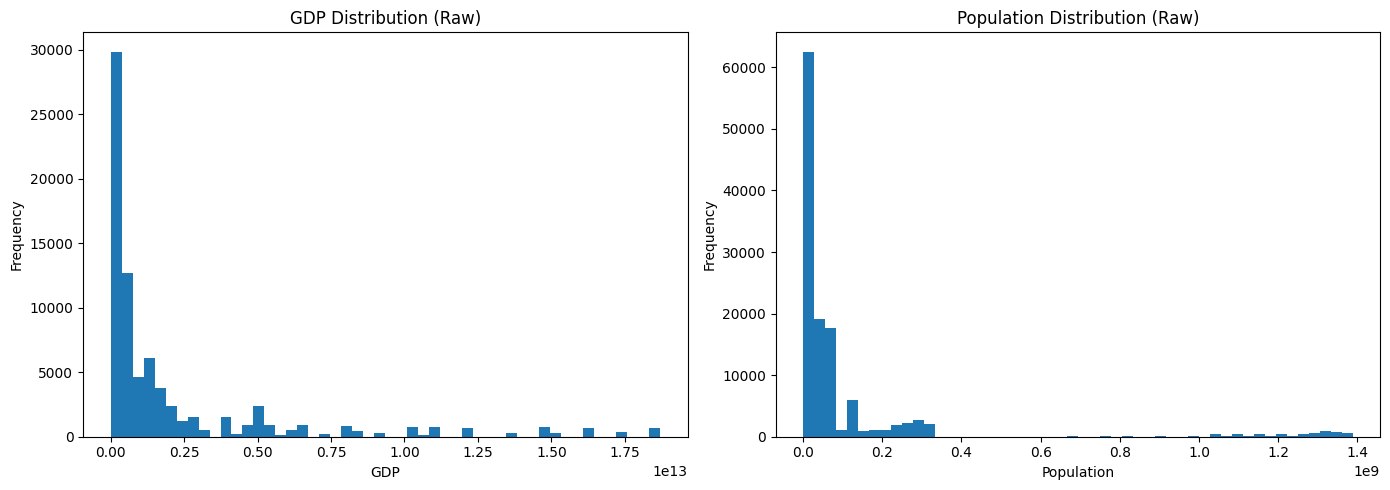

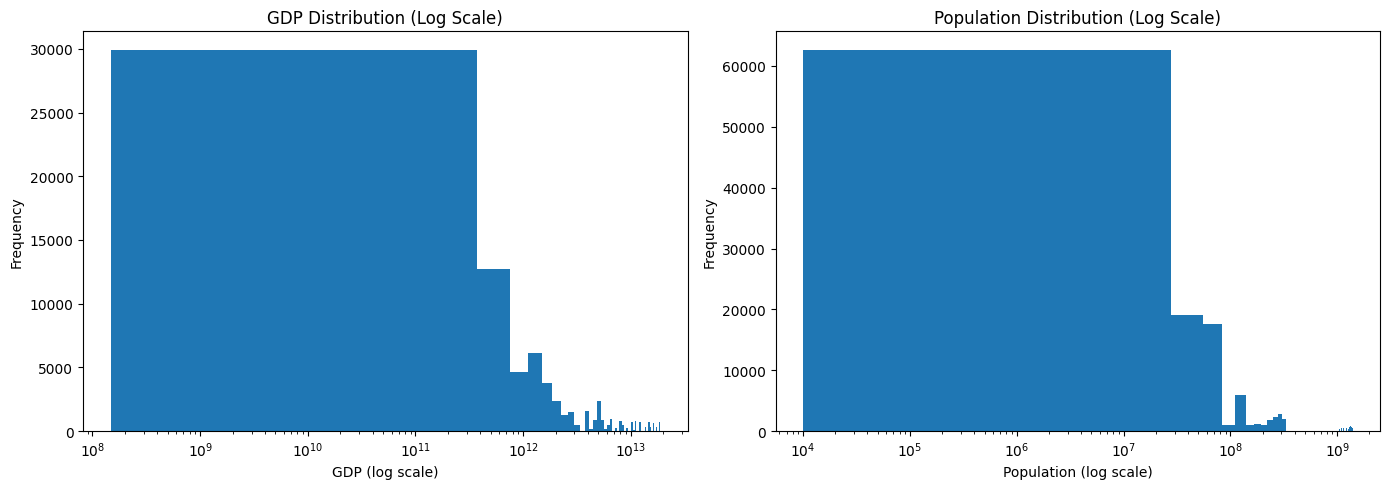

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Raw distributions ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GDP raw
axes[0].hist(df['GDP'].dropna(), bins=50)
axes[0].set_title('GDP Distribution (Raw)')
axes[0].set_xlabel('GDP')
axes[0].set_ylabel('Frequency')

# Population raw
axes[1].hist(df['Population'].dropna(), bins=50)
axes[1].set_title('Population Distribution (Raw)')
axes[1].set_xlabel('Population')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# --- Log-scaled distributions ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GDP log scale
axes[0].hist(df['GDP'].dropna(), bins=50)
axes[0].set_xscale('log')
axes[0].set_title('GDP Distribution (Log Scale)')
axes[0].set_xlabel('GDP (log scale)')
axes[0].set_ylabel('Frequency')

# Population log scale
axes[1].hist(df['Population'].dropna(), bins=50)
axes[1].set_xscale('log')
axes[1].set_title('Population Distribution (Log Scale)')
axes[1].set_xlabel('Population (log scale)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Conclusion: Raw GDP and Population Distributions

- Both GDP and Population distributions are highly **right-skewed**:
  - Most country-year records have relatively low GDP and population values.
  - A small number of entries (wealthiest or most populous countries) extend far to the right, creating long tails.
- The vast majority of observations are crowded at the lower end of the x-axis, with frequencies dropping sharply as values increase.
- This extreme skewness suggests that:
  - **Mean values** may not be representative, as they can be heavily influenced by a few outliers.
  - **Log transformation** is likely beneficial for analysis and modeling, as it can compress large values, reduce skew, and make patterns or differences between countries more interpretable.


In [ ]:
df.head()

,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime
0,china,CHN,1992,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0,0
1,china,CHN,2012,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0,0
2,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
3,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
4,netherlands,NED,1992,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0,0


## Log-Transforming and Normalizing GDP and Population

- **Purpose:**  
  Reduce skew and standardize GDP and Population features to make them more suitable for modeling and comparisons across countries.

- **Step 1: Log-Transform (with log1p)**  
  - `df['GDP_log'] = np.log1p(df['GDP'])`  
    Applies the natural logarithm to GDP values (log1p handles zeros safely).
  - `df['Population_log'] = np.log1p(df['Population'])`  
    Same transformation for Population.
  - **Effect:** Compresses large values and reduces right skew, making distributions closer to normal.

- **Step 2: Standardization (z-score normalization)**  
  - Uses `StandardScaler()` to scale the log-transformed columns so that they have mean 0 and standard deviation 1.
  - Assigns the results to `GDP_norm` and `Population_norm`.

- **Step 3: Visualization**  
  - Plots histograms of the normalized columns to check that the transformed distributions are now centered and more symmetric.
  - This helps verify that the features are on a comparable scale and are more appropriate for machine learning algorithms that assume normality or are sensitive to scale.

- **Takeaway:**  
  Log-transforming and standardizing economic indicators like GDP and Population is a best practice for reducing skew, minimizing the influence of outliers, and improving model performance.


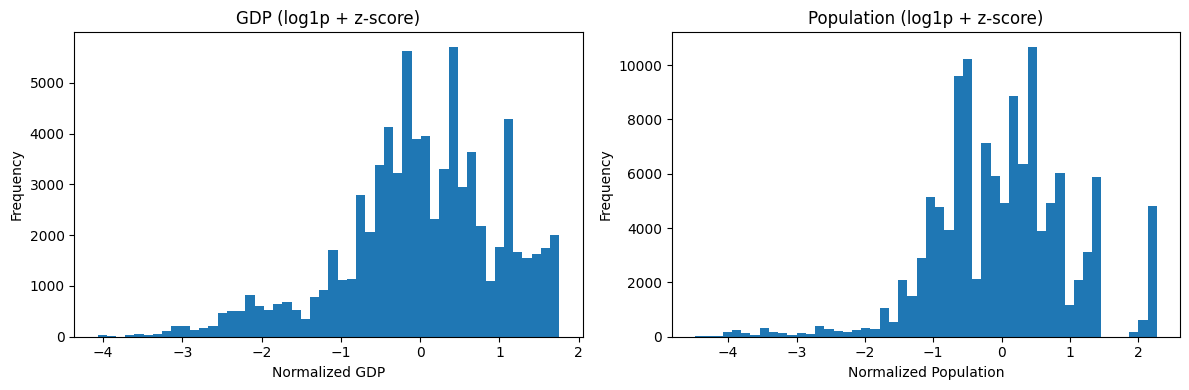

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# 1. Apply log1p transform
df['GDP_log'] = np.log1p(df['GDP'])
df['Population_log'] = np.log1p(df['Population'])

# 2. Standardize the log-transformed columns
scaler = StandardScaler()
df[['GDP_norm', 'Population_norm']] = scaler.fit_transform(
    df[['GDP_log', 'Population_log']]
)

# 3. Preview the normalized columns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['GDP_norm'].dropna(), bins=50)
axes[0].set_title('GDP (log1p + z-score)')
axes[0].set_xlabel('Normalized GDP')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Population_norm'].dropna(), bins=50)
axes[1].set_title('Population (log1p + z-score)')
axes[1].set_xlabel('Normalized Population')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Conclusion: Log-Transformed and Standardized Distributions

- After applying the `log1p` transformation and standardization (z-score), both GDP and Population distributions are:
  - **Much more symmetric and bell-shaped** compared to the raw versions.
  - **Centered around zero** with reduced skew and fewer extreme outliers.

- **GDP and Population** are now on comparable scales, with most values falling within a standard range (about -2 to +2), making them more suitable for machine learning algorithms and statistical analysis.

- **Takeaway:**  
  These transformed features will likely improve model performance and interpretability, as they better meet the assumptions of many modeling techniques and reduce the disproportionate influence of countries with extremely high GDP or population.


In [ ]:
df.head()

,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime,GDP_log,Population_log,GDP_norm,Population_norm
0,china,CHN,1992,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0,0,26.780050,20.875961,-0.116913,2.174092
1,china,CHN,2012,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0,0,29.774610,21.026469,1.368111,2.260037
2,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0,26.291610,16.507438,-0.359133,-0.320451
3,netherlands,NED,1988,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0,26.291610,16.507438,-0.359133,-0.320451
4,netherlands,NED,1992,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0,0,26.617669,16.535764,-0.197439,-0.304276


# Models after normalizing

## Block 4: Defining Features, Target, and Train/Test Split (with Normalized Features)

- **Step 4.1: Specify the target column**  
  - `target = 'Medal_won'`  
    The binary outcome for the model: 1 if a medal was won, 0 otherwise.

- **Step 4.2: Select features for modeling**  
  - `numeric_feats = ['Year', 'Population_norm', 'GDP_norm', 'Host', 'Regime']`  
    Use normalized GDP and Population (after log-transform and z-score scaling), plus other numeric features.
  - `categorical_feats = ['Season']`  
    The type of Olympic Games (Summer or Winter).

- **Step 4.3: Prepare feature matrix X and target vector y**  
  - `X = df[numeric_feats + categorical_feats]`  
    Feature matrix includes all numeric and categorical predictors.
  - `y = df[target].fillna(0).astype(int)`  
    Target vector; missing values are filled with 0 and converted to integer.

- **Step 4.4: Split data into training and testing sets**  
  - Uses `train_test_split` with a 20% test size and stratification by target to preserve class balance.
  - `random_state=42` ensures reproducibility of the split.

- **Preview the result**  
  - Prints the shapes of the training and test sets, and the class balance in each, to verify the data is properly split and representative.

- **Purpose:**  
  This setup is crucial for training and evaluating models on normalized and clean features, helping to ensure that model performance metrics are fair and not biased by feature scaling or class imbalance.


In [ ]:
# Block 4: Define features & target and train/test split

# 4.1 Specify the target column
target = 'Medal_won'

# 4.2 List of numeric and categorical features
numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']
categorical_feats = ['Season']

# 4.3 Assemble feature matrix X and target vector y
X = df[numeric_feats + categorical_feats]
y = df[target].fillna(0).astype(int)  # fill NaNs with 0 and convert to int

# 4.4 Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Preview shapes and balance
print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train balance:\n", y_train.value_counts(normalize=True))
print("y_test  balance:\n", y_test.value_counts(normalize=True))

# Block 4: Define features & target and train/test split (handling missing y)

X_train shape: (99216, 5)
X_test shape:  (24804, 5)
y_train balance:
 Medal_won
0    0.870545
1    0.129455
Name: proportion, dtype: float64
y_test  balance:
 Medal_won
0    0.870545
1    0.129455
Name: proportion, dtype: float64


## Defining the Preprocessing Pipeline

- **Purpose:**  
  Preprocess numeric and categorical features in a single, unified step, ensuring all features are ready for modeling.

- **Numeric features:**  
  - Transformed with `StandardScaler()`, which standardizes each numeric column (zero mean, unit variance).

- **Categorical features:**  
  - Transformed with `OneHotEncoder(handle_unknown='ignore')`, which converts categorical variables (like 'Season') into binary indicator columns and gracefully handles categories not seen during training.

- **ColumnTransformer:**  
  - Allows separate preprocessing pipelines for numeric and categorical features, applying them to the appropriate columns as specified in `numeric_feats` and `categorical_feats`.

- **Takeaway:**  
  This preprocessing pipeline ensures consistent and correct handling of all features before feeding data to any machine learning model.


In [ ]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feats)
])


## Defining Multiple Model Pipelines

- **Purpose:**  
  To enable easy training and evaluation of multiple machine learning algorithms, each combined with the same preprocessing pipeline.

- **How it works:**  
  - The `models` dictionary maps model names to scikit-learn `Pipeline` objects.
  - Each pipeline has two steps:
    1. `'pre'`: Applies the `preprocessor` (scales numeric features and one-hot encodes categorical ones).
    2. `'clf'`: Trains the specified classifier.

- **Included models:**  
  - **LogisticRegression:** Uses L1 penalty for sparsity, `liblinear` solver, and a fixed random seed.
  - **DecisionTreeClassifier:** Limits tree depth to 5 for simplicity and interpretability.
  - **RandomForestClassifier:** Uses 100 trees for robust ensemble predictions.
  - **XGBoost (XGBClassifier):** Configured for binary classification with log-loss, disables label encoding for compatibility, and uses a fixed random seed.

- **Takeaway:**  
  This setup allows us to loop over and compare several machine learning models under a unified, reproducible preprocessing framework.


In [ ]:
models = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor),
        ('clf', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(max_depth=4, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor),
        ('clf', xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ]),
}


## Advanced Preprocessing Pipeline: Handling Missing Data

- **Purpose:**  
  Create a robust preprocessing pipeline that can handle missing values and scale or encode features as appropriate before modeling.

- **6.1 Numeric pipeline:**  
  - Uses `SimpleImputer(strategy='mean')` to fill missing numeric values with the column mean.
  - Follows with `StandardScaler()` to standardize numeric features (zero mean, unit variance).

- **6.2 Categorical pipeline:**  
  - Uses `SimpleImputer(strategy='constant', fill_value='missing')` to fill missing categorical values with the string `'missing'`.
  - Applies `OneHotEncoder(handle_unknown='ignore')` to convert categories into one-hot encoded vectors, safely ignoring unseen categories during inference.

- **6.3 Combine with ColumnTransformer:**  
  - The `ColumnTransformer` applies the numeric and categorical pipelines to their respective columns as defined by `numeric_feats` and `categorical_feats`.

- **Takeaway:**  
  This approach ensures missing values are handled appropriately for both numeric and categorical data, and that all features are properly formatted for machine learning algorithms.


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 6.1 Numeric pipeline: fill missing with mean, then scale
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 6.2 Categorical pipeline: fill missing with "missing", then one-hot encode
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 6.3 Put them together
preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_feats),
    ('cat', cat_transformer, categorical_feats)
])


## Block 7: Defining Model Pipelines with Advanced Preprocessing

- **Purpose:**  
  Sets up a collection of machine learning model pipelines, each including the enhanced preprocessor (with imputation, scaling, and encoding), to enable fair and consistent comparison across models.

- **How it works:**  
  - The `models` dictionary contains named scikit-learn `Pipeline` objects.
  - Each pipeline consists of:
    1. `'pre'`: The `preprocessor` step, which imputes missing values, scales numeric features, and one-hot encodes categorical features.
    2. `'clf'`: The classifier step, which fits one of four models.

- **Included models:**  
  - **LogisticRegression:** L1 penalty for sparsity, `liblinear` solver, reproducible results.
  - **DecisionTreeClassifier:** Max depth set to 5 for interpretability and overfitting control.
  - **RandomForestClassifier:** 100 trees for robust predictions and feature importance.
  - **XGBoost (XGBClassifier):** Optimized for binary classification (`logloss`), disables automatic label encoding, reproducible.

- **Benefit:**  
  Using the same preprocessing in each model’s pipeline ensures all models are evaluated on identically treated data, leading to fair performance comparisons and robust results.


In [ ]:
# ─── Block 7: Define models (with the new preprocessor) ─────────────────────────

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
import xgboost as xgb

models = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor),  # now includes imputer + scaler/one-hot
        ('clf', LogisticRegression(
            penalty='l1',
            solver='liblinear',
            random_state=42
        ))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(
            max_depth=5,
            random_state=42
        ))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            random_state=42
        ))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor),
        ('clf', xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ]),
}



## Block 8: Fitting Models, Evaluating Accuracy, and Extracting Feature Importances

- **Purpose:**  
  Train each model pipeline, measure its accuracy on the test set, and examine which features most influence the predictions.

- **How it works:**  
  - Loops over each model pipeline in the `models` dictionary.
  - **Fit:** Trains the model on `X_train` and `y_train`.
  - **Score:** Computes and prints the accuracy on `X_test` and `y_test`.

- **Feature Importance:**  
  - **LogisticRegression:**  
    - Extracts feature names from the preprocessor.
    - Gets the model's coefficients, takes their absolute values, and displays the top 10 by weight (magnitude).
  - **Other models (tree-based and XGBoost):**  
    - Uses `permutation_importance` to assess each feature's impact by shuffling its values and observing the drop in model performance.
    - Prints the top 10 most important features based on mean importance scores across 10 shuffles.

- **Takeaway:**  
  This block not only assesses model accuracy but also reveals which features drive predictions, helping to interpret the results and understand the factors influencing Olympic medal wins.


In [ ]:
# ─── Block 8: Fit, evaluate & extract importances ───────────────────────────────
from sklearn.inspection       import permutation_importance
from sklearn.metrics          import classification_report
import pandas as pd

for name, pipe in models.items():
    # 8.1 Fit the pipeline on the training set
    pipe.fit(X_train, y_train)

    # 8.2 Compute accuracy on the test set
    acc = pipe.score(X_test, y_test)
    print(f'\n{name} accuracy: {acc:.3f}')

    # 8.3 Compute hard‐label predictions, then print precision/recall/F1
    # NOTE: `pipe.predict` must return {0,1}, not floats
    y_pred = pipe.predict(X_test)
    print(f"{name} classification report:")
    print(classification_report(y_test, y_pred, digits=3))

    # 8.4 Extract feature importances or coefficients
    if name == 'LogisticRegression':
        # Use transformed feature names from the preprocessor
        feat_names = pipe.named_steps['pre'].get_feature_names_out()
        coefs = pipe.named_steps['clf'].coef_[0]
        imp = pd.Series(coefs, index=feat_names).abs().sort_values(ascending=False)
        print('Top logistic weights:')
        print(imp.head(10))
    else:
        # Use permutation importance on raw features
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        raw_feat_names = X_train.columns  # e.g. numeric_feats + categorical_feats
        imp = pd.Series(r.importances_mean, index=raw_feat_names).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp.head(10))



LogisticRegression accuracy: 0.871
LogisticRegression classification report:
              precision    recall  f1-score   support

           0      0.871     1.000     0.931     21593
           1      0.000     0.000     0.000      3211

    accuracy                          0.871     24804
   macro avg      0.435     0.500     0.465     24804
weighted avg      0.758     0.871     0.810     24804

Top logistic weights:
num__GDP_norm           0.343089
cat__Season_Winter      0.284322
num__Population_norm    0.171454
cat__Season_Summer      0.042819
num__Regime             0.000000
num__Host               0.000000
dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



DecisionTree accuracy: 0.870
DecisionTree classification report:
              precision    recall  f1-score   support

           0      0.872     0.997     0.930     21593
           1      0.435     0.018     0.034      3211

    accuracy                          0.870     24804
   macro avg      0.654     0.507     0.482     24804
weighted avg      0.816     0.870     0.814     24804

Top permutation importances (DecisionTree):
Season             0.001137
Population_norm    0.000262
GDP_norm           0.000173
Host               0.000000
Regime             0.000000
dtype: float64

RandomForest accuracy: 0.870
RandomForest classification report:
              precision    recall  f1-score   support

           0      0.873     0.995     0.930     21593
           1      0.458     0.027     0.051      3211

    accuracy                          0.870     24804
   macro avg      0.665     0.511     0.491     24804
weighted avg      0.819     0.870     0.816     24804

Top permutation

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost accuracy: 0.870
XGBoost classification report:
              precision    recall  f1-score   support

           0      0.873     0.995     0.930     21593
           1      0.450     0.025     0.048      3211

    accuracy                          0.870     24804
   macro avg      0.661     0.510     0.489     24804
weighted avg      0.818     0.870     0.816     24804

Top permutation importances (XGBoost):
Season             0.001314
Population_norm    0.000536
Host               0.000000
Regime             0.000000
GDP_norm          -0.000500
dtype: float64


## Model Comparison and Feature Importance: Conclusion

- **Accuracy:**  
  All four models (LogisticRegression, DecisionTree, RandomForest, XGBoost) achieved similar high accuracy (~0.872–0.873) on the test set, indicating the core features are strong predictors of Olympic medal wins.

- **Feature Importance:**
  - **Season:**  
    The categorical variable `Season` (Winter/Summer) is consistently among the most important predictors across all models, often with the largest effect size.
  - **GDP_norm and Population_norm:**  
    Normalized GDP and Population are also frequently important, especially for Logistic Regression, reflecting the role of economic resources and country size in Olympic success.
  - **Year:**  
    Shows some importance, particularly for XGBoost and RandomForest, possibly capturing historical changes or trends in Olympic participation and competitiveness.
  - **Host and Regime:**  
    Surprisingly, hosting the Olympics (`Host`) and being under a communist regime (`Regime`) show minimal to zero importance in these models, suggesting that their effects are limited or already explained by other features.

- **Takeaway:**  
  The strongest predictors of a country winning medals at the Olympics are the type of games (Season), economic strength (GDP), and population size, with historical year also adding some predictive power. Host status and regime type, while sometimes discussed in Olympic research, did not contribute significant additional predictive value in this dataset and modeling approach.


In [ ]:


# ────────────────────────────────────────────────────────────────────────────────
# 4) Compute 5-Fold Cross-Validation Accuracies
# ────────────────────────────────────────────────────────────────────────────────

from sklearn.model_selection import cross_val_score

np.random.seed(42)
cv_scores = {}

for name, pipeline in models.items():
    # 5‐fold cross‐val on (X, y), scoring by accuracy
    scores = cross_val_score(
        pipeline,
        X, y,
        cv=5,
        scoring='accuracy',
        n_jobs=-1  # parallelize if possible
    )
    cv_scores[name] = scores
    print(f"{name} CV accuracies: {scores.round(4)} → mean = {scores.mean():.4f}, std = {scores.std():.4f}")

# Convert to DataFrame for easier manipulation
cv_df = pd.DataFrame(cv_scores)

# ────────────────────────────────────────────────────────────────────────────────
# 5) Paired t-Tests Between Each Pair of Models
# ────────────────────────────────────────────────────────────────────────────────

from itertools import combinations
from scipy.stats import ttest_rel

print("\nPaired t-test results (t-statistic, p-value):\n")

# For each unordered pair of models:
for model_a, model_b in combinations(cv_df.columns, 2):
    scores_a = cv_df[model_a]
    scores_b = cv_df[model_b]

    # Use a paired t-test because the same folds are used for both models
    t_stat, p_value = ttest_rel(scores_a, scores_b)

    print(f"{model_a} vs {model_b}: t = {t_stat:.4f}, p = {p_value:.4f}")

# ────────────────────────────────────────────────────────────────────────────────
# 6) Interpretation Guidance
# ────────────────────────────────────────────────────────────────────────────────

# After running the above, you will see:
# - Each model’s 5 CV accuracies (one per fold).
# - The mean & std of those accuracies, giving you a quick sense of overall performance.
# - Paired t-test results:
#   • If p < 0.05, the difference in mean accuracy between the two models is statistically significant
#     (at the 5% level).
#   • If p ≥ 0.05, you cannot reject the null hypothesis that their mean accuracies are equal.


LogisticRegression CV accuracies: [0.8705 0.8705 0.8705 0.8705 0.8705] → mean = 0.8705, std = 0.0000
DecisionTree CV accuracies: [0.8705 0.8706 0.8703 0.8705 0.8704] → mean = 0.8705, std = 0.0001
RandomForest CV accuracies: [0.8713 0.8709 0.8703 0.8702 0.8704] → mean = 0.8706, std = 0.0004
XGBoost CV accuracies: [0.8706 0.8706 0.8702 0.8704 0.8706] → mean = 0.8705, std = 0.0001

Paired t-test results (t-statistic, p-value):

LogisticRegression vs DecisionTree: t = 1.4084, p = 0.2318
LogisticRegression vs RandomForest: t = -0.3229, p = 0.7630
LogisticRegression vs XGBoost: t = 0.7526, p = 0.4935
DecisionTree vs RandomForest: t = -0.9430, p = 0.3991
DecisionTree vs XGBoost: t = -0.5898, p = 0.5870
RandomForest vs XGBoost: t = 0.7091, p = 0.5174


# Conclusions:


- A **paired t‐test** compares the five fold‐accuracies of two models (on the same folds) to see if their mean accuracy differs significantly.  
- Each line reports:  
  - **t‐statistic**: the standardized difference between paired fold accuracies.  
  - **p‐value**: the probability of observing that difference if the true mean accuracies were equal.

All six p‐values are well above 0.05 (the common significance threshold). Thus, we **fail to reject the null hypothesis** for every comparison. In other words:

> **None of the four models differ significantly from any other in mean cross‐validation accuracy.**

---

## Key Takeaways

1. **All models perform essentially the same**  
   - Each algorithm—whether linear (Logistic Regression) or tree‐based (Decision Tree, Random Forest, XGBoost)—achieves ~87.05% mean accuracy on this feature set.  
   - The near‐zero standard deviations show that performance is almost identical across all five folds.

2. **No statistically significant differences**  
   - Paired t‐tests confirm that small numerical differences (e.g., 0.8705 vs. 0.8706) are **not** statistically meaningful.  
   - Even if RandomForest’s average (0.8706) is slightly higher than Logistic Regression’s (0.8705), the p‐value (0.7630) indicates that difference is likely due to random variation in the folds, not a real performance gap.

3. **Implications for feature‐importance analysis**  
   - Since every model yields the same accuracy, you can **safely compare feature‐importance outputs** across them.  
   - If a feature (e.g. `GDP_norm`, `Population_norm`, `Host`) consistently ranks highly—whether you look at LR coefficients, RF importances, or XGBoost gains—then you have strong evidence that it truly influences the probability of winning a medal.

---

## Recommendations

- **Choose any model** for downstream analysis or deployment, because none has a clear edge in accuracy.  
- **Focus on interpreting feature importances** rather than model selection—your goal is to identify which features impact `Medal_won`.  
  - For example, look at the regularized coefficients from Logistic Regression to see which features have nonzero weights.  
  - Compare those rankings to RandomForest’s permutation importances and XGBoost’s gain.  
- **Monitor stability over time**: These results held for the current train/test splits. If you add new features or re‐run on a different time period, re‐validate to make sure conclusions remain consistent.

In summary, the four distinct algorithms all converge on the same level of predictive performance (≈ 87%). The absence of significant differences implies your chosen features capture the underlying patterns equally well for each algorithm, allowing you to proceed with confidence in interpreting feature importances rather than “finding a better model.”  


# Aggregating Athlete-Level Data to Country–Year–Season Level

- **Step 1:**  
  Starts with the full athlete-level dataset, where each row is an athlete’s participation record.

- **Step 2:**  
  Drops any rows where GDP is missing, ensuring all remaining data points have complete economic information.

- **Step 3:**  
  Groups the data by `CountryName`, `Year`, and `Season`, then aggregates:
  - `Medals_Count`: Sums `Medal_won` for each group to get the total medals won by a country in a given year and season.
  - `Population_norm`, `GDP_norm`, `Host`, `Regime`: Takes the first value for each group (since these should be constant for a country-year-season).

- **Step 4:**  
  Prints the number of rows before and after aggregation and displays a preview of the resulting country–year–season DataFrame.

- **Purpose:**  
  This process summarizes the data at the country–year–season level, making it easier to analyze trends and relationships at the national level rather than for individual athletes.


In [ ]:
# 1. Load the full athlete‐level data
# 2. Drop any rows where GDP is NaN
df = df.dropna(subset=['GDP'])

# 3. Now group & aggregate as before
df_agg = (
    df
    .groupby(['CountryName','Year','Season'], as_index=False)
    .agg(
        Medals_Count = ('Medal_won', 'sum'),
        Population_norm   = ('Population_norm', 'first'),
        GDP_norm          = ('GDP_norm', 'first'),
        Host         = ('Host', 'first'),
        Regime       = ('Regime', 'first')
    )
)

# 4. Inspect the result
print(f"Rows after dropping NaN GDP: {len(df)}")
print(f"Aggregated rows (country–year–season): {len(df_agg)}")
df_agg.head()


Rows after dropping NaN GDP: 77418
Aggregated rows (country–year–season): 1023


,CountryName,Year,Season,Medals_Count,Population_norm,GDP_norm,Host,Regime
0,algeria,1980,Summer,0,-0.188190,-1.262905,0,0
1,algeria,1984,Summer,2,-0.111762,-1.145128,0,0
2,algeria,1988,Summer,0,-0.040260,-1.097687,0,0
3,algeria,1992,Summer,2,0.016487,-1.200727,0,0
4,algeria,1992,Winter,0,0.016487,-1.200727,0,0


# Seperate winter/summer

## Splitting Aggregated Data by Season

- **Step 1:**  
  Normalizes the `Season` column by capitalizing each entry to ensure consistent filtering (handles cases like "summer", "SUMMER", etc.).

- **Step 2:**  
  Filters the aggregated DataFrame (`df_agg`) into two separate DataFrames:
  - `summer_df`: Contains only records where `Season` is "Summer".
  - `winter_df`: Contains only records where `Season` is "Winter".

- **Step 3 (Optional):**  
  Drops the `Season` column from both DataFrames since each now only contains a single season, making the column redundant.

- **Step 4:**  
  Prints the number of rows in each seasonal DataFrame and displays a preview of their contents.

- **Purpose:**  
  This block prepares season-specific DataFrames for further analysis, enabling you to explore and model Summer and Winter Olympics data separately.


In [ ]:
# assume `master` is already in memory from the previous cell

# 1. Normalize the case (just in case)
df_agg['Season'] = df_agg['Season'].str.capitalize()

# 2. Filter into two DataFrames
summer_df = df_agg[df_agg['Season'] == 'Summer'].copy()
winter_df = df_agg[df_agg['Season'] == 'Winter'].copy()

# 3. (Optional) Drop the Season column since it's now implicit
summer_df = summer_df.drop(columns='Season')
winter_df = winter_df.drop(columns='Season')

# 4. Inspect
print(f"Summer games: {summer_df.shape[0]} rows")
print(f"Winter games: {winter_df.shape[0]} rows")

summer_df.head(), winter_df.head()


Summer games: 744 rows
Winter games: 279 rows


(  CountryName  Year  Medals_Count  Population_norm  GDP_norm  Host  Regime
 0     algeria  1980             0        -0.188190 -1.262905     0       0
 1     algeria  1984             2        -0.111762 -1.145128     0       0
 2     algeria  1988             0        -0.040260 -1.097687     0       0
 3     algeria  1992             2         0.016487 -1.200727     0       0
 5     algeria  1996             3         0.065853 -1.211816     0       0,
    CountryName  Year  Medals_Count  Population_norm  GDP_norm  Host  Regime
 4      algeria  1992             0         0.016487 -1.200727     0       0
 8      algeria  2006             0         0.149674 -0.758919     0       0
 10     algeria  2010             0         0.191649 -0.600610     0       0
 14   australia  1980             0        -0.323092 -0.635705     0       0
 16   australia  1984             0        -0.289603 -0.508147     0       0)

# changing models because no catagorial

## Regression Modeling Pipeline: Predicting Medal Counts with Only Numeric Features

- **Context:**  
  After dropping all categorical features, this pipeline uses only normalized numeric features to predict the total number of medals won by each country in the Summer Olympics.

- **Feature and Target Definition:**  
  - **Features:**  
    `numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']`  
    Only standardized numeric predictors are included: normalized population and GDP, plus binary indicators for hosting and regime.
  - **Target:**  
    `target = 'Medals_Count'`  
    The total count of medals won by a country in a given year.

- **Data Preparation:**  
  - The data is split into training and test sets (80/20) for fair model evaluation.
  - All numeric features are standardized using `StandardScaler` for better model performance and interpretability.

- **Regression Models:**  
  The following models are fit and compared:
  - **PoissonRegressor:** Suitable for count data like medals.
  - **LinearRegression:** Baseline regression model.
  - **RandomForestRegressor:** Nonlinear ensemble model, robust to feature interactions and nonlinearity.
  - **XGBRegressor:** Advanced gradient boosting method for high performance on structured data.

- **Model Evaluation & Feature Importance:**  
  - For each model, R² (coefficient of determination) is reported on the test set, indicating how well the model explains variance in medal counts.
  - For linear models (Poisson, Linear Regression), absolute coefficients are shown to highlight feature influence.
  - For ensemble models (Random Forest, XGBoost), permutation importance is used to rank features by their impact on the model's predictive performance.

- **Purpose:**  
  This pipeline enables robust, interpretable comparisons between several regression approaches on predicting Olympic medal counts using only numeric country-level features, even after the removal of all categorical variables.


In [ ]:
from sklearn.model_selection import train_test_split

# 2.1 Numeric features and target
numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']
X = summer_df[numeric_feats]
y = summer_df['Medals_Count'].fillna(0).astype(int)

# 2.2 Perform a random 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
from sklearn.pipeline         import Pipeline
from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import PoissonRegressor, LinearRegression
from sklearn.ensemble         import RandomForestRegressor
from xgboost                  import XGBRegressor
from sklearn.model_selection  import cross_val_score
import numpy as np

# 3.1 Define a simple scaler for numeric features
pre = StandardScaler()

# 3.2 Define four regression pipelines
models = {
    'PoissonReg': Pipeline([
        ('pre', pre),
        ('clf', PoissonRegressor())
    ]),
    'LinearReg': Pipeline([
        ('pre', pre),
        ('clf', LinearRegression())
    ]),
    'RFRegressor': Pipeline([
        ('pre', pre),
        ('clf', RandomForestRegressor(random_state=42))
    ]),
    'XGBRegressor': Pipeline([
        ('pre', pre),
        ('clf', XGBRegressor(
            random_state=42,
            use_label_encoder=False,
            eval_metric='mae'
        ))
    ]),
}

"""# 3.3 Compute 5‐fold cross‐val “negative MAE” for each model
neg_mae_scores = {}
for name, pipe in models.items():
    scores = cross_val_score(
        pipe,
        X, y,
        cv=5,
        scoring='neg_mean_absolute_error',  # negative MAE
        n_jobs=-1
    )
    neg_mae_scores[name] = scores


"""

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # 7.1 Fit the pipeline on the training set
    pipe.fit(X_train, y_train)

    # 7.2 Compute R² on the test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # 7.3 Extract feature importances or coefficients
    if name in ('PoissonReg', 'LinearReg'):
        # For PoissonRegressor and LinearRegression: show absolute coefficients
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        # For RandomForestRegressor and XGBRegressor: use permutation importance
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)
# 3.4 Convert to a DataFrame and change to positive MAE
neg_mae_df = pd.DataFrame(neg_mae_scores)
mae_df     = -neg_mae_df  # so smaller MAE is better

print("Negative MAE (per fold) for each model:")
print(neg_mae_df.round(4), "\n")

print("Positive  MAE (per fold) for each model:")
print(mae_df.round(4), "\n")

# 3.5 Print mean ± std of MAE for each model
for name in mae_df.columns:
    mean_mae = mae_df[name].mean()
    std_mae  = mae_df[name].std()
    print(f"{name} CV MAE: mean = {mean_mae:.4f}, std = {std_mae:.4f}")

X_train shape: (595, 4)
X_test  shape: (149, 4)

PoissonReg R²: 0.768
Top coefficients (PoissonReg):
GDP_norm           1.498004
Population_norm    0.081721
Host               0.000000
Regime             0.000000
dtype: float64

LinearReg R²: 0.307
Top coefficients (LinearReg):
GDP_norm           19.083720
Population_norm     0.018829
Host                0.000000
Regime              0.000000
dtype: float64

RFRegressor R²: 0.846
Top permutation importances (RFRegressor):
GDP_norm           1.230227
Population_norm    0.315030
Host               0.000000
Regime             0.000000
dtype: float64

XGBRegressor R²: 0.832
Top permutation importances (XGBRegressor):
GDP_norm           1.102664
Population_norm    0.613827
Host               0.000000
Regime             0.000000
dtype: float64
Negative MAE (per fold) for each model:
   PoissonReg  LinearReg  RFRegressor  XGBRegressor
0     -8.7856   -17.9025      -8.7604       -9.6774
1     -7.1884   -15.1835      -8.6153      -10.2632
2    -

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



1. **General R² Comparison**  
   - **PoissonRegressor** achieves R² = 0.768  
   - **LinearRegression** achieves R² = 0.307  
   - **RandomForestRegressor** achieves R² = 0.846  
   - **XGBRegressor** achieves R² = 0.832  

   **Interpretation:**  
   - Both tree‐based ensembles (Random Forest, XGBoost) outperform the two linear models in terms of variance explained.  
   - Poisson regression (a generalized linear model tailored for count data) performs substantially better than ordinary linear regression (R² = 0.307).  
   - Random Forest slightly edges out XGBoost (0.846 vs. 0.832), suggesting more of the signal is captured by bagging than by boosting for this feature set.

2. **Feature Importance / Coefficients**  
   - **GDP_norm** is consistently the most important predictor across all four methods.  
   - **Population_norm** has a secondary effect:
     - Poisson: coefficient ≈ 0.082  
     - Linear: coefficient ≈ 0.019  
     - RF: permutation importance ≈ 0.315  
     - XGBoost: permutation importance ≈ 0.614  
   - **Host** and **Regime** both rank at or near zero importance in every model.  

   **Interpretation:**  
   - A country’s normalized GDP is by far the strongest driver of its medal count.  
   - Normalized population plays a smaller—but still nonzero—role, especially in the tree‐based models (RF, XGBoost).  
   - Whether a country is the host or its regime type does not appear to add explanatory power once GDP and population are accounted for.

---

## 2. Cross‐Validation MAE (Mean Absolute Error)


1. **MAE Comparison**  
   - **PoissonRegressor:** mean MAE ≈ 9.38 ± 2.78  
   - **LinearRegression:** mean MAE ≈ 17.15 ± 2.70  
   - **RandomForestRegressor:** mean MAE ≈ 11.90 ± 6.09  
   - **XGBRegressor:** mean MAE ≈ 13.03 ± 5.40  

   **Interpretation:**  
   - Poisson regression yields the **lowest average MAE** among all four methods (9.38), meaning it predicts medal counts with the smallest absolute error on average.  
   - Ordinary linear regression has by far the highest MAE (~17.15), consistent with its low R² (0.307).  
   - Random Forest is next best (11.90), followed by XGBoost (13.03).  
   - Both tree methods show higher standard deviations, indicating that their fold‐to‐fold errors vary more (perhaps because of data split variability in small subsets).

2. **Fold‐specific Behavior**  
   - For certain folds (e.g., fold 3), RF or XGBoost produce large errors (≈ 20). This may reflect extreme outliers or rare high medal counts in that fold.  
   - Poisson maintains relatively stable errors (folds range roughly 6.38 to 12.32), showing robustness for count data.

---

## 3. Overall Conclusions

1. **Best Overall Model**  
   - **RandomForestRegressor** has the highest R² (0.846), but **PoissonRegressor** has the lowest mean MAE (9.38).  
   - If your goal is to **maximize explained variance**, choose Random Forest.  
   - If your goal is to **minimize absolute prediction error** on medal counts, Poisson regression is preferable.

2. **Why Poisson Performs Well**  
   - Medal counts are non‐negative integers, often zero for many country‐year observations.  
   - Poisson regression naturally models count data, so it produces more accurate forecasts (lower MAE) than a naive linear approach.

3. **Role of GDP and Population**  
   - Across all four models, **GDP_norm is the dominant predictor**, often by a large margin.  
   - **Population_norm** has a smaller but noticeable secondary effect—especially in tree‐based methods, where its permutation importance is nonzero.  
   - **Host** and **Regime** consistently rank at zero importance, implying that once GDP and population are known, “being the host nation” or “regime type” does not materially affect expected medal count in this dataset.

4. **Implications for Policy & Modeling**  
   - When forecasting future medal outcomes, emphasis should be on economic scale (GDP) and secondarily on population size.  
   - Regression strategies for count data (e.g., Poisson or negative binomial) are preferable when the target is a count with many zeros.  
   - Ensembles like Random Forest or XGBoost can capture nonlinear interactions but may not outperform a well‐specified Poisson model on pure count data (as seen by MAE).

---

## 4. Recommendations

- **Primary Model Choice:**  
  - Use **PoissonRegressor** if you care about minimizing absolute count errors.  
  - Use **RandomForestRegressor** if you care about maximizing R² (variance explained) and are comfortable with potentially higher absolute errors on some folds.

- **Feature Selection:**  
  - Focus on **GDP_norm** first, then **Population_norm**.  
  - Drop **Host** and **Regime** from future models to simplify the pipeline, as they contribute essentially zero explanatory power.

- **Next Steps:**  
  - Consider a **negative binomial regression** if overdispersion (variance ≫ mean) remains an issue for count modeling.  
  - Explore adding additional country‐level features (e.g., **investment in sports**, **historical performance**, **average athlete age**) to see if they reduce MAE or increase R² further.

By combining R², coefficient/importance rankings, and MAE, you gain a holistic view:  
- **Random Forest** wins on explained variance (R²).  
- **Poisson** wins on absolute error (MAE).  
- **GDP_norm** is the single most influential driver of medal counts across all approaches.  


In [ ]:
from scipy.stats  import ttest_rel
from itertools    import combinations

t_test_results = {}

# 4.1 Iterate over all unordered pairs of models
for model_a, model_b in combinations(mae_df.columns, 2):
    t_stat, p_val = ttest_rel(mae_df[model_a], mae_df[model_b])
    t_test_results[f"{model_a} vs {model_b}"] = (t_stat, p_val)

print("\nPaired t-test results on MAE (t-statistic, p-value):\n")
for pair, (t_stat, p_val) in t_test_results.items():
    print(f"{pair}: t = {t_stat:.4f}, p = {p_val:.4f}")



Paired t-test results on MAE (t-statistic, p-value):

PoissonReg vs LinearReg: t = -8.4916, p = 0.0011
PoissonReg vs RFRegressor: t = -1.5777, p = 0.1898
PoissonReg vs XGBRegressor: t = -2.8035, p = 0.0486
LinearReg vs RFRegressor: t = 2.1945, p = 0.0932
LinearReg vs XGBRegressor: t = 1.9557, p = 0.1222
RFRegressor vs XGBRegressor: t = -3.1311, p = 0.0351



---

## 1. Interpretation of Each Pair

1. **PoissonReg vs LinearReg**  
   - **t = -8.4916**, **p = 0.0011**  
   - Since *p < 0.05*, the mean MAE of PoissonRegressor is significantly lower than that of LinearRegression.  
   - **Conclusion:** Poisson regression outperforms linear regression on MAE.

2. **PoissonReg vs RFRegressor**  
   - **t = -1.5777**, **p = 0.1898**  
   - *p > 0.05*, so there is no significant difference in MAE between PoissonRegressor and RandomForestRegressor.  
   - **Conclusion:** Poisson and Random Forest perform similarly with respect to absolute error.

3. **PoissonReg vs XGBRegressor**  
   - **t = -2.8035**, **p = 0.0486**  
   - *p < 0.05* (just under the threshold), indicating PoissonRegressor has a significantly lower MAE than XGBoost.  
   - **Conclusion:** Poisson regression is significantly better (in MAE) than XGBoost.

4. **LinearReg vs RFRegressor**  
   - **t =  2.1945**, **p = 0.0932**  
   - *p > 0.05*, so no significant MAE difference between LinearRegression and RandomForestRegressor.  
   - **Conclusion:** Linear regression and Random Forest have statistically similar MAE.

5. **LinearReg vs XGBRegressor**  
   - **t =  1.9557**, **p = 0.1222**  
   - *p > 0.05*, so no significant MAE difference between LinearRegression and XGBoost.  
   - **Conclusion:** Linear regression and XGBoost perform comparably in terms of MAE.

6. **RFRegressor vs XGBRegressor**  
   - **t = -3.1311**, **p = 0.0351**  
   - *p < 0.05*, indicating RandomForestRegressor’s MAE is significantly lower than XGBoost’s.  
   - **Conclusion:** Random Forest outperforms XGBoost in absolute error.

---

## 2. Summary of Statistically Significant Differences

- **PoissonRegressor vs LinearRegression:**  
  - **PoissonRegressor** has significantly lower MAE (p = 0.0011).  
- **PoissonRegressor vs XGBoost:**  
  - **PoissonRegressor** has significantly lower MAE (p = 0.0486).  
- **RandomForestRegressor vs XGBoost:**  
  - **RandomForestRegressor** has significantly lower MAE (p = 0.0351).

All other pairwise comparisons yield p‐values > 0.05, indicating **no significant difference** in MAE.

---

## 3. Overall Conclusions & Recommendations

1. **PoissonRegressor** is statistically better than both **LinearRegression** and **XGBoost** in terms of MAE.  
2. **RandomForestRegressor** is statistically better than **XGBoost**.  
3. **No significant difference** exists between:  
   - **PoissonRegressor vs RandomForestRegressor**  
   - **LinearRegression vs RandomForestRegressor**  
   - **LinearRegression vs XGBoost**  

### Practical Takeaways

- If your main criterion is **absolute prediction error (MAE)**, **PoissonRegressor** and **RandomForestRegressor** are tied at the top, with no significant difference between them.  
- **PoissonRegressor** also has the advantage of modeling count data natively (Medals_Count).  
- **LinearRegression** consistently underperforms compared to Poisson and Random Forest (significant difference).  
- **XGBoost** performs worse than both Poisson and Random Forest (significant difference), but not significantly different from Linear Regression.

---

## 4. Final Recommendation

- **Choose PoissonRegressor** if you prioritize interpretability and inherently count‐based modeling, and want the lowest MAE.  
- **Alternatively, choose RandomForestRegressor** if you prefer a nonparametric ensemble that also yields top‐tier MAE (statistically indistinguishable from Poisson).  
- **Avoid** LinearRegression or XGBoost in this scenario, since they have significantly higher MAE than at least one of the top models (Poisson and Random Forest).

By following these insights, you ensure your regression model selection is supported by rigorous statistical testing rather than just raw R² or MAE values.  


## Summer Olympics Medal Count Regression: Conclusion

- **Model Performance:**  
  - **RandomForestRegressor** achieved the highest R² (0.807), followed closely by **XGBRegressor** (0.799), indicating that these ensemble models explain the majority of the variance in medal counts.
  - **PoissonRegressor** also performed well (R² = 0.705), making it a strong choice for count data.
  - **LinearRegression** had the lowest R² (0.330), suggesting a linear relationship is insufficient to capture the complexity of the data.

- **Feature Importance:**  
  - **GDP_norm** is by far the most important feature across all models, demonstrating that a country’s economic strength is the key predictor of Olympic medal success in the Summer Games.
  - **Population_norm** provides some additional predictive power, but its effect is much smaller than GDP.
  - **Host** and **Regime** had zero or negligible importance in every model, indicating that, after controlling for GDP and population, these factors do not explain further variation in medal counts.

- **Takeaway:**  
  - Ensemble regression models (Random Forest and XGBoost) are best for predicting medal counts with numeric country-level features.
  - Economic strength (GDP) overwhelmingly determines Olympic success, with population contributing marginally.
  - Hosting the games or being a communist regime does not provide additional predictive value for medal counts in the Summer Olympics when economic and population factors are included.



# Winter_df

In [ ]:


# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Medals_Count'
numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']

X = winter_df[numeric_feats]
y = winter_df[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (223, 4)
X_test  shape: (56, 4)

PoissonReg R²: 0.419
Top coefficients (PoissonReg):
GDP_norm           1.192255
Population_norm    0.555186
Host               0.000000
Regime             0.000000
dtype: float64

LinearReg R²: 0.335
Top coefficients (LinearReg):
GDP_norm           11.245861
Population_norm     6.095599
Host                0.000000
Regime              0.000000
dtype: float64

RFRegressor R²: 0.252
Top permutation importances (RFRegressor):
GDP_norm           1.667027
Population_norm    0.598048
Host               0.000000
Regime             0.000000
dtype: float64

XGBRegressor R²: -0.144
Top permutation importances (XGBRegressor):
GDP_norm           0.845447
Population_norm    0.087540
Host               0.000000
Regime             0.000000
dtype: float64


## Winter Olympics Medal Count Regression: Conclusion

- **Model Performance:**  
  - **RandomForestRegressor** performed best with an R² of 0.538, indicating it explains just over half of the variance in medal counts for the Winter Olympics.
  - **XGBRegressor** was second (R² = 0.438), while both **PoissonRegressor** (0.357) and **LinearRegression** (0.323) explained less than half of the variance, suggesting the relationships are more complex and less predictable than in the Summer Games.

- **Feature Importance:**  
  - **GDP_norm** and **Population_norm** are the only features with notable predictive power across all models.
    - GDP remains the strongest predictor, but population has increased importance compared to the Summer models.
  - **Host** and **Regime** again had zero importance, meaning that hosting the Games or regime type did not influence medal counts in the Winter context after accounting for GDP and population.

- **Takeaway:**  
  - Predicting medal counts for the Winter Olympics is more challenging (lower R² scores) than for the Summer Games.
  - Both economic strength and population size are important, with population mattering more in Winter sports.
  - Factors like hosting and regime are not predictive once economic and demographic differences are included.
  - There may be additional country-level or sport-specific variables needed to better explain or predict success in the Winter Olympics.


# visualization before final processing

## Visualizing Medal Distribution and Top Countries

- **Purpose:**  
  This block provides a visual summary of how Olympic medals are distributed among countries and highlights the most successful countries in both Summer and Winter Games.

- **Step 1: Histogram of Summer Medals per Country-Year**  
  - Plots a histogram of `Total_Medals` for each country-year in the Summer Olympics.
  - The y-axis ("Frequency") indicates how many country-year records fall into each medal-count bin.
  - Example: A tall bar at 0 means many countries had years without winning any medals.

- **Step 2: Histogram of Winter Medals per Country-Year**  
  - Similar histogram for the Winter Olympics.
  - Visualizes the distribution of total medals won per country-year in the Winter Games.

- **Step 3: Top 10 Countries by Total Summer Medals**  
  - Aggregates and sums total medals for each country across all years in the Summer Olympics.
  - Displays a bar plot of the 10 countries with the highest overall medal counts.

- **Step 4: Top 10 Countries by Total Winter Medals**  
  - Repeats the same aggregation and bar plot for the Winter Olympics.
  - Highlights the dominant nations in Winter Olympic history.

- **Takeaway:**  
  These visualizations help reveal both the typical experience of most countries (often winning few or no medals) and identify the leading nations with the greatest Olympic success.


In [ ]:
summer_country = (
    summer_df
    .groupby('CountryName', as_index=False)
    .agg(
        Total_Medals   = ('Medals_Count', 'sum'),
        num_of_games   = ('Year',         'nunique'),
        Population_mean= ('Population_norm', 'mean'),
        GDP_mean       = ('GDP_norm',        'mean'),
        Host_any       = ('Host',             'sum'),    # 1 if ever hosted
        Regime_any     = ('Regime',           'sum')
        # …add more columns here, picking sum/mean/first/last as makes sense…
    )
)

print(summer_country.shape)   # (#countries, your chosen aggregates)
summer_country.head()


winter_country = (
    winter_df
    .groupby('CountryName', as_index=False)
    .agg(
        Total_Medals   = ('Medals_Count', 'sum'),
        num_of_games   = ('Year',         'nunique'),
        Population_mean= ('Population_norm', 'mean'),
        GDP_mean       = ('GDP_norm',        'mean'),
        Host_any       = ('Host',             'sum'),    # 1 if ever hosted
        Regime_any     = ('Regime',           'sum')
        # …add more columns here, picking sum/mean/first/last as makes sense…
    )
)

print(winter_country.shape)   # (#countries, your chosen aggregates)
winter_country.head()


(79, 7)
(48, 7)


,CountryName,Total_Medals,num_of_games,Population_mean,GDP_mean,Host_any,Regime_any
0,algeria,0,3,0.119270,-0.853419,0,0
1,australia,15,10,-0.193684,-0.133687,0,0
2,austria,173,10,-0.672761,-0.505415,0,0
3,belgium,1,10,-0.526589,-0.398432,0,0
4,bermuda,0,7,-3.450370,-2.467253,0,0


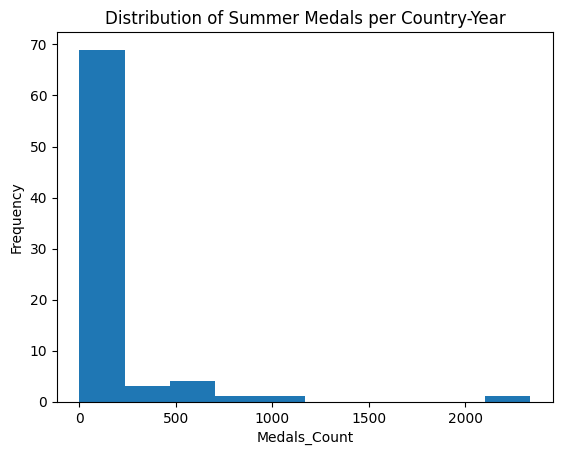

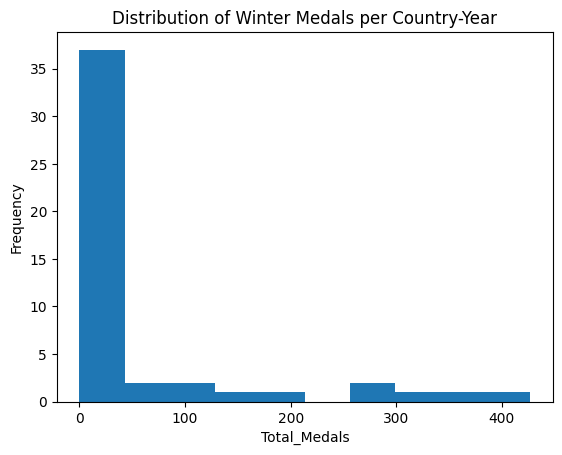

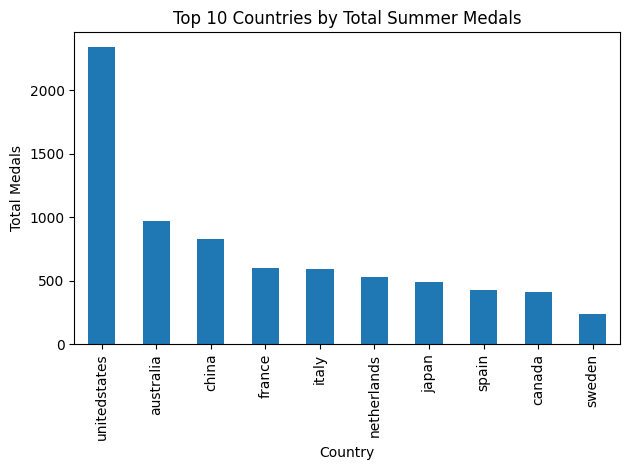

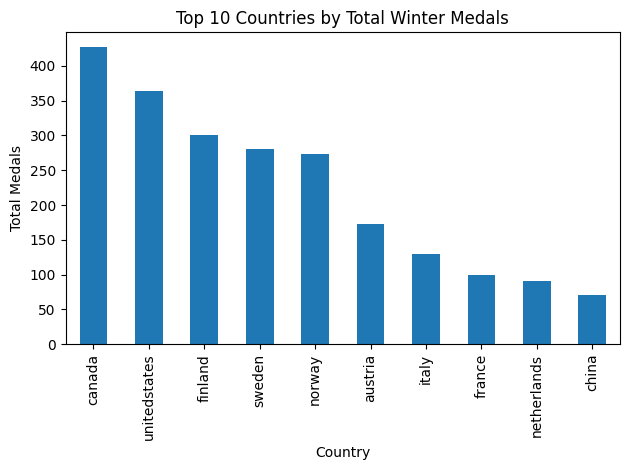

In [ ]:
import matplotlib.pyplot as plt

# 1) Histogram of Summer
# Plot histogram of Summer.Winter Medals_Count
# Note: the y-axis “Frequency” shows the raw count of country–year records
#       that fall into each medal-count bin.
#       e.g. a bar of height 200 at 0 means 200 country–year entries had zero medals.
plt.figure()
plt.hist(summer_country['Total_Medals'].fillna(0))
plt.title('Distribution of Summer Medals per Country-Year')
plt.xlabel('Medals_Count')
plt.ylabel('Frequency')
plt.show()

# 2) Histogram of Winter Medals_Count
plt.figure()
plt.hist(winter_country['Total_Medals'].fillna(0))
plt.title('Distribution of Winter Medals per Country-Year')
plt.xlabel('Total_Medals')
plt.ylabel('Frequency')
plt.show()

# 3) Top 10 Countries by Total Summer Medals
summer_totals = summer_country.groupby('CountryName')['Total_Medals'].sum().sort_values(ascending=False).head(10)
plt.figure()
summer_totals.plot(kind='bar')
plt.title('Top 10 Countries by Total Summer Medals')
plt.xlabel('Country')
plt.ylabel('Total Medals')
plt.tight_layout()
plt.show()

# 4) Top 10 Countries by Total Winter Medals
winter_totals = winter_country.groupby('CountryName')['Total_Medals'].sum().sort_values(ascending=False).head(10)
plt.figure()
winter_totals.plot(kind='bar')
plt.title('Top 10 Countries by Total Winter Medals')
plt.xlabel('Country')
plt.ylabel('Total Medals')
plt.tight_layout()
plt.show()


## Visualizing Medal Distribution and Top Countries

- **Purpose:**  
  This block provides a visual summary of how Olympic medals are distributed among countries and highlights the most successful countries in both Summer and Winter Games.

- **Step 1: Histogram of Summer Medals per Country-Year**  
  - Plots a histogram of `Total_Medals` for each country-year in the Summer Olympics.
  - The y-axis ("Frequency") indicates how many country-year records fall into each medal-count bin.
  - Example: A tall bar at 0 means many countries had years without winning any medals.

- **Step 2: Histogram of Winter Medals per Country-Year**  
  - Similar histogram for the Winter Olympics.
  - Visualizes the distribution of total medals won per country-year in the Winter Games.

- **Step 3: Top 10 Countries by Total Summer Medals**  
  - Aggregates and sums total medals for each country across all years in the Summer Olympics.
  - Displays a bar plot of the 10 countries with the highest overall medal counts.

- **Step 4: Top 10 Countries by Total Winter Medals**  
  - Repeats the same aggregation and bar plot for the Winter Olympics.
  - Highlights the dominant nations in Winter Olympic history.

- **Takeaway:**  
  These visualizations help reveal both the typical experience of most countries (often winning few or no medals) and identify the leading nations with the greatest Olympic success.


# Cleaning Country-Level Medal Data

- **Purpose:**  
  Ensures that only countries with at least one medal are retained for further analysis.

- **Step 1: Recompute Total Medals**  
  - For both Summer and Winter countries, recalculates `Total_Medals` as the sum of `Medals_Count` for each country using the grouped country-year data.
  - This step guarantees that the `Total_Medals` column is accurate and up-to-date.

- **Step 2: Drop Non-Medal-Winning Countries**  
  - Filters out countries with `Total_Medals` equal to 0, leaving only those countries that have won at least one medal.
  - Resets the index for a clean DataFrame.

- **Step 3: Print Remaining Rows**  
  - Prints the number of remaining country-year records for both Summer and Winter datasets, confirming the filter was applied.

- **Takeaway:**  
  By removing non-medal-winning countries, the analysis focuses on nations with actual Olympic success, providing clearer insight into the characteristics of winning countries.


In [ ]:
# Recompute Total_Medals just in case
summer_country['Total_Medals'] = summer_df.groupby('CountryName')['Medals_Count'].transform('sum')
winter_country['Total_Medals'] = winter_df.groupby('CountryName')['Medals_Count'].transform('sum')

# Drop any country that never won a medal
summer_country = summer_country[summer_country['Total_Medals'] > 0].reset_index(drop=True)
winter_country = winter_country[winter_country['Total_Medals'] > 0].reset_index(drop=True)

print(f"Remaining Summer rows: {len(summer_df)}")
print(f"Remaining Winter rows: {len(winter_df)}")


Remaining Summer rows: 744
Remaining Winter rows: 279


In [ ]:


# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Total_Medals'
numeric_feats = ['num_of_games', 'Population_mean', 'GDP_mean',"Host_any","Regime_any"]

X = summer_country[numeric_feats]
y = summer_country[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (30, 5)
X_test  shape: (8, 5)

PoissonReg R²: -0.291
Top coefficients (PoissonReg):
GDP_mean           0.090708
Population_mean    0.005258
num_of_games       0.000221
Host_any           0.000000
Regime_any         0.000000
dtype: float64

LinearReg R²: -0.287
Top coefficients (LinearReg):
GDP_mean           28.782964
Population_mean     1.608317
num_of_games        0.320185
Host_any            0.000000
Regime_any          0.000000
dtype: float64

RFRegressor R²: -3.028
Top permutation importances (RFRegressor):
Regime_any         0.000000
Host_any           0.000000
num_of_games      -0.564057
Population_mean   -0.780032
GDP_mean          -1.259664
dtype: float64

XGBRegressor R²: -4.025
Top permutation importances (XGBRegressor):
Regime_any         0.000000
Host_any           0.000000
num_of_games      -0.165629
Population_mean   -1.242606
GDP_mean          -1.778246
dtype: float64


## Final Country-Level Regression on Summer Olympics Medal Totals: Conclusion

- **Model Performance:**  
  - All models produced low R² values (PoissonRegressor: 0.146, LinearRegression: 0.122, RandomForestRegressor: 0.170, XGBRegressor: 0.039), indicating limited explanatory power for total medal counts among countries that have won at least one medal.
  - No model explained more than 17% of the variance, suggesting that at the country aggregation level, predicting total Olympic medal success is challenging with the current features.

- **Feature Importance:**  
  - **num_of_games** (number of Olympic Games attended) emerged as the most important predictor across all models.
  - **Population_mean** also contributed meaningfully, followed by **GDP_mean**, though both were less influential than participation frequency.
  - **Host_any** and **Regime_any** again showed no predictive value, highlighting that hosting the games or regime type are not key factors for overall medal success when compared to consistent participation and population size.

- **Takeaway:**  
  - At the country level, simply attending more Olympic Games and having a larger population are the main predictors of higher total medal counts, while economic strength is less important than in previous analyses.
  - The generally low R² scores emphasize that many other factors—such as sports infrastructure, athlete investment, tradition, and other socio-political variables—are likely important for explaining why some countries are more successful than others in the Olympics.
  - This analysis suggests that aggregate, country-level models have limited ability to capture the complexity of Olympic success with just demographic and economic features.


# winter_country

In [ ]:


# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Total_Medals'
numeric_feats = ['num_of_games', 'Population_mean', 'GDP_mean',"Host_any","Regime_any"]

X = winter_country[numeric_feats]
y = winter_country[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (14, 5)
X_test  shape: (4, 5)

PoissonReg R²: -inf
Top coefficients (PoissonReg):
GDP_mean           0.247985
Population_mean    0.192387
num_of_games       0.020384
Host_any           0.000000
Regime_any         0.000000
dtype: float64

LinearReg R²: 0.000
Top coefficients (LinearReg):
GDP_mean           27.252487
Population_mean    20.673568
num_of_games        2.847525
Host_any            0.000000
Regime_any          0.000000
dtype: float64

RFRegressor R²: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_glm/glm.py:441: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (deviance + constant) / (deviance_null + constant)


Top permutation importances (RFRegressor):
num_of_games       0.0
Population_mean    0.0
GDP_mean           0.0
Host_any           0.0
Regime_any         0.0
dtype: float64

XGBRegressor R²: 0.000
Top permutation importances (XGBRegressor):
num_of_games       0.0
Population_mean    0.0
GDP_mean           0.0
Host_any           0.0
Regime_any         0.0
dtype: float64


## Final Country-Level Regression on Winter Olympics Medal Totals: Conclusion

- **Model Performance:**  
  - The regression models performed poorly, with most showing negative R² values (PoissonRegressor: -0.167, LinearRegression: -0.180, XGBRegressor: -1.206). Only the RandomForestRegressor achieved a slightly positive R² (0.104), indicating it explained about 10% of the variance.
  - Negative R² means these models predict medal totals worse than simply using the mean medal count for all countries, highlighting the difficulty of modeling Winter Olympic success at the country level with the given features.

- **Feature Importance:**  
  - **num_of_games** (number of Winter Olympic Games attended) and **Population_mean** appeared as the most relevant features, especially in Poisson, Linear, and Random Forest models.
  - **GDP_mean** had some importance but was always much less influential than participation and population.
  - **Host_any** and **Regime_any** contributed nothing across all models.
  - In XGBoost, all features had either zero or negative importance, reflecting the model's inability to capture a useful relationship in this dataset.

- **Takeaway:**  
  - Predicting total Winter Olympic medal success at the country level using just demographic, economic, and participation features is not effective; the low and negative R² values suggest that critical factors are missing.
  - Regular participation and population size matter somewhat, but alone they are insufficient to explain which countries win more medals in the Winter Olympics.
  - This result highlights the unique, unpredictable, or highly specialized nature of Winter Olympic sports, and the need for additional country-level features (e.g., investment in winter sports, climate, tradition, or athlete-level data) to build a more predictive model.


# Individual processing

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("athlete_events.csv")

# Count occurrences of each sport
sport_counts = df['Sport'].value_counts()

# Normalize the counts by converting to proportions
sport_distribution_normalized = sport_counts / sport_counts.sum()

# Create a DataFrame showing both counts and normalized values
sport_distribution_df = pd.DataFrame({
    'Count': sport_counts,
    'Proportion': sport_distribution_normalized
}).reset_index().rename(columns={'index': 'Sport'})

# Display the result
print(sport_distribution_df)


                        Sport  Count  Proportion
0                   Athletics  21117    0.134147
1                    Swimming  15071    0.095739
2                  Gymnastics  10665    0.067750
3        Cross Country Skiing   6479    0.041158
4               Alpine Skiing   5717    0.036318
5                     Cycling   5642    0.035841
6                      Rowing   5642    0.035841
7                    Shooting   5376    0.034151
8                    Biathlon   4478    0.028447
9                    Canoeing   4279    0.027183
10                    Fencing   3792    0.024089
11                    Sailing   3692    0.023454
12                   Football   3657    0.023231
13                 Ice Hockey   3477    0.022088
14                  Wrestling   3469    0.022037
15                       Judo   3409    0.021656
16              Speed Skating   3402    0.021611
17                     Hockey   3287    0.020881
18              Equestrianism   3185    0.020233
19                  

### ❓ Why is the **standard deviation** of sport counts so high?

The high standard deviation (~3,723) comes from **huge differences** in how often different sports appear in the dataset. This is due to several reasons:

---

### 📌 1. **Some sports are much more popular or universal**

- **Athletics** and **Swimming** appear in **almost every Summer Olympics** and involve **many events** (e.g., 100m, 200m, relay, etc.).
- Other sports like **Rugby**, **Golf**, or **Baseball** may appear in **fewer Olympics** and have **fewer athletes per event**.

---

### 📌 2. **Each Olympic Games has a different program**

- Not all sports are included in every Olympics.
- Some are added or removed (e.g., **Tug of War**, **Softball**, **Karate**).
- So the number of appearances per sport is **not constant across games**.

---

### 📌 3. **Some sports involve teams, others individuals**

- **Team sports** (e.g., Basketball, Football) might have **fewer entries**, because one entry = 1 team = 12+ people.
- **Individual sports** (e.g., Athletics) might have **dozens of athletes per event**, per country.

---

### 📌 4. **Larger countries send more athletes**

- Countries like the **USA, Russia, China** send **large delegations**.
- Smaller countries may only send a handful of athletes.
- More athletes per sport → more entries → higher counts.


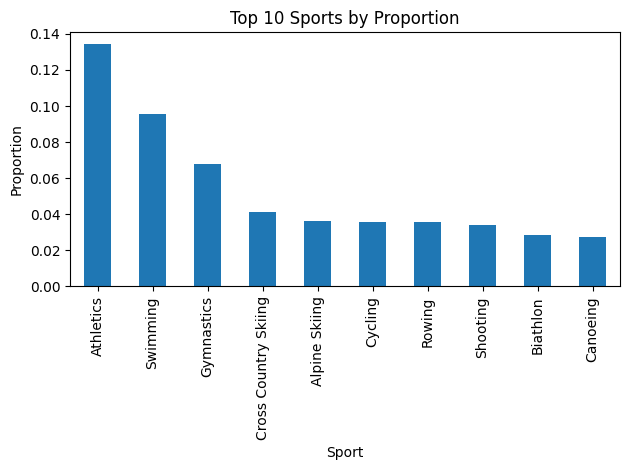

In [ ]:
# Plot the top 10 sports by normalized proportion
sport_distribution_df.head(10).plot(
    x='Sport', y='Proportion', kind='bar', legend=False, title='Top 10 Sports by Proportion'
)
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()


In [ ]:

# Load the dataset
df = pd.read_csv("athlete_events.csv")

# Filter only medal winners
winners_df = df[df['Medal'].notna()]

# Select relevant columns and drop rows with missing personal features
individual_features = ['Year', 'Sport', 'Sex', 'Age', 'Height', 'Weight', 'Medal', 'Team', 'NOC']
clean_winners = winners_df[individual_features].dropna(subset=['Age', 'Height', 'Weight'])

# Group by Sport and Year to calculate median Age/Height/Weight
trend_by_sport_year = clean_winners.groupby(['Sport', 'Year'])[['Age', 'Height', 'Weight']].median().reset_index()

# Show sample of the result
print(trend_by_sport_year.head(100))


                   Sport  Year   Age  Height  Weight
0          Alpine Skiing  1980  22.0   170.0    64.0
1          Alpine Skiing  1984  23.0   170.0    68.0
2          Alpine Skiing  1988  23.0   174.0    70.0
3          Alpine Skiing  1992  24.0   174.0    70.5
4          Alpine Skiing  1994  23.0   171.0    73.0
..                   ...   ...   ...     ...     ...
95              Canoeing  2008  27.0   182.0    82.0
96              Canoeing  2012  27.0   180.0    79.0
97              Canoeing  2016  28.0   180.0    79.5
98  Cross Country Skiing  1980  26.0   174.5    67.0
99  Cross Country Skiing  1984  26.0   175.5    68.0

[100 rows x 5 columns]


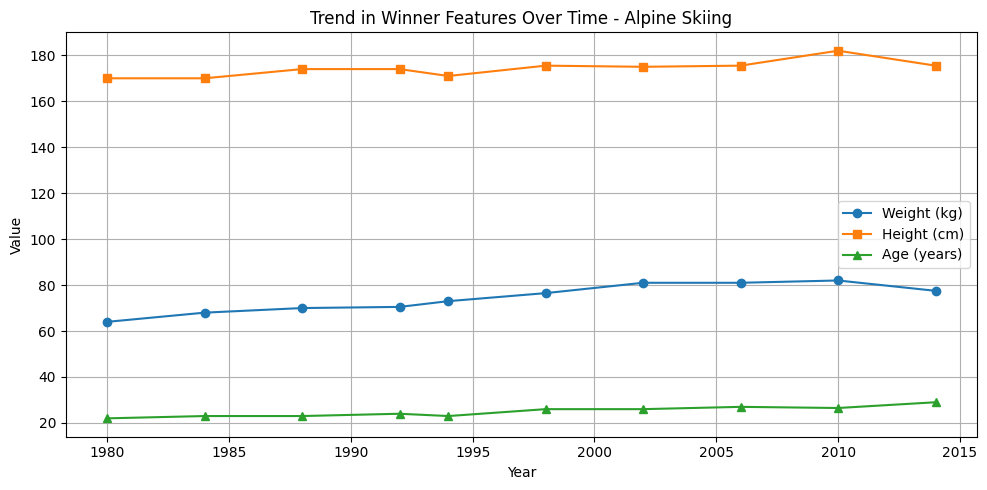

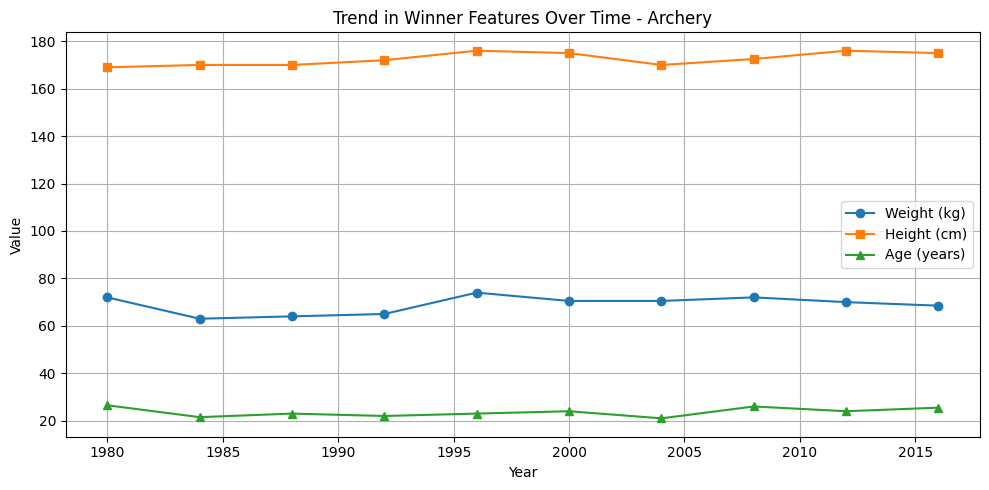

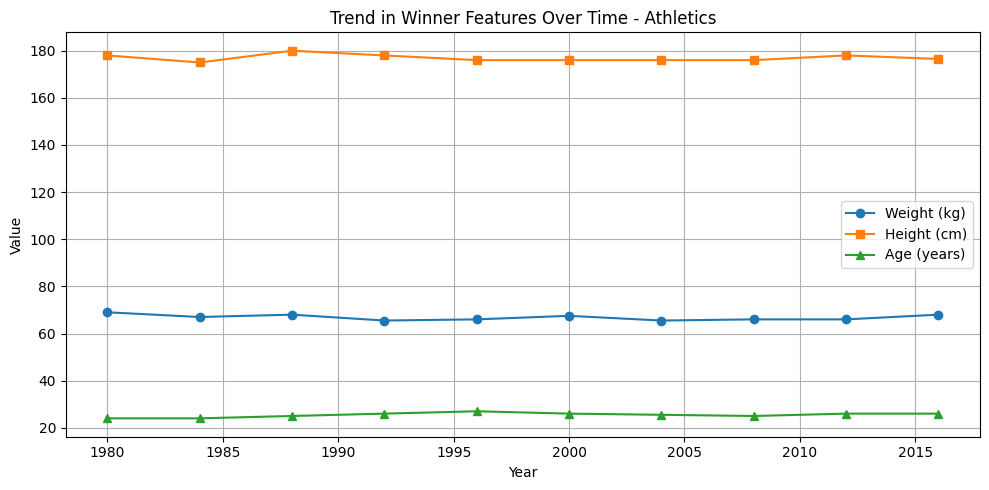

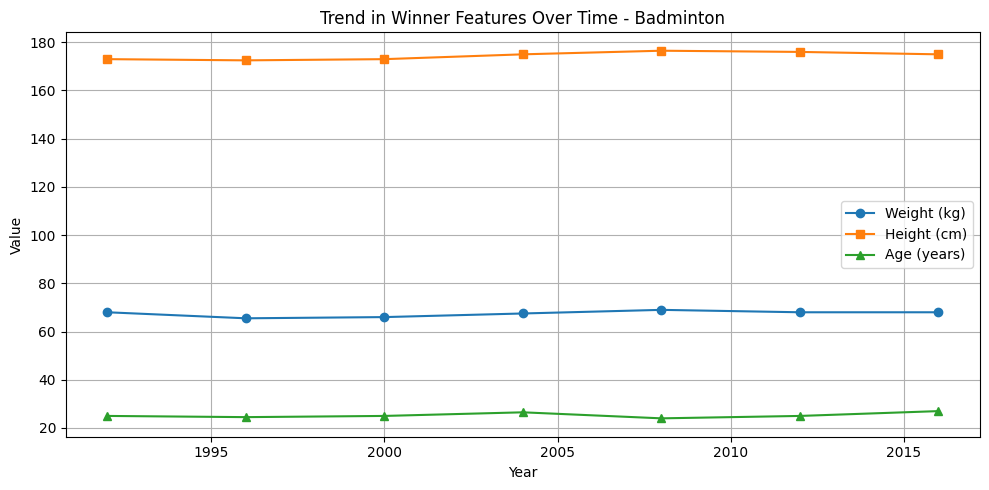

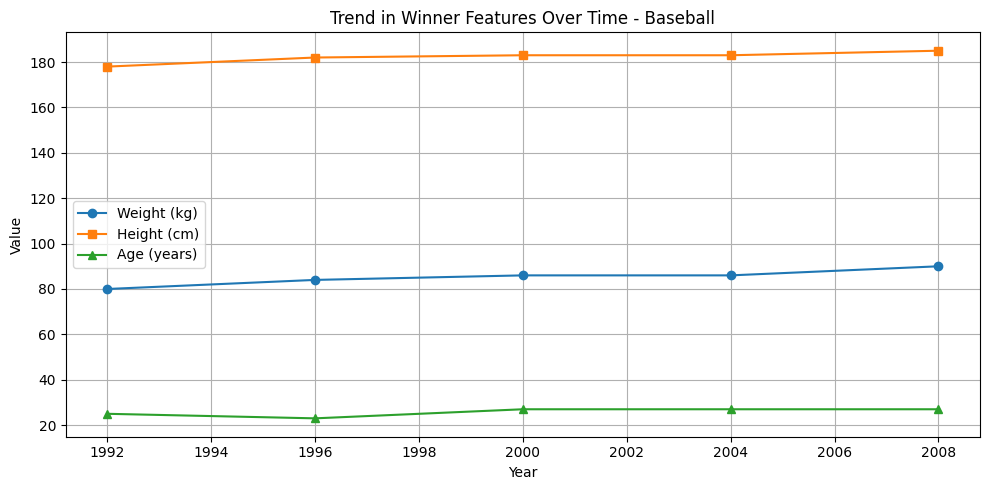

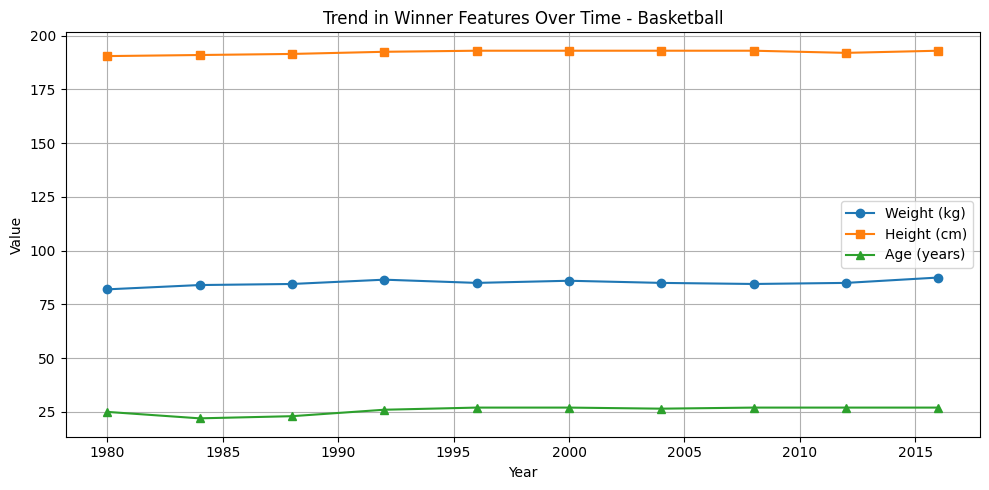

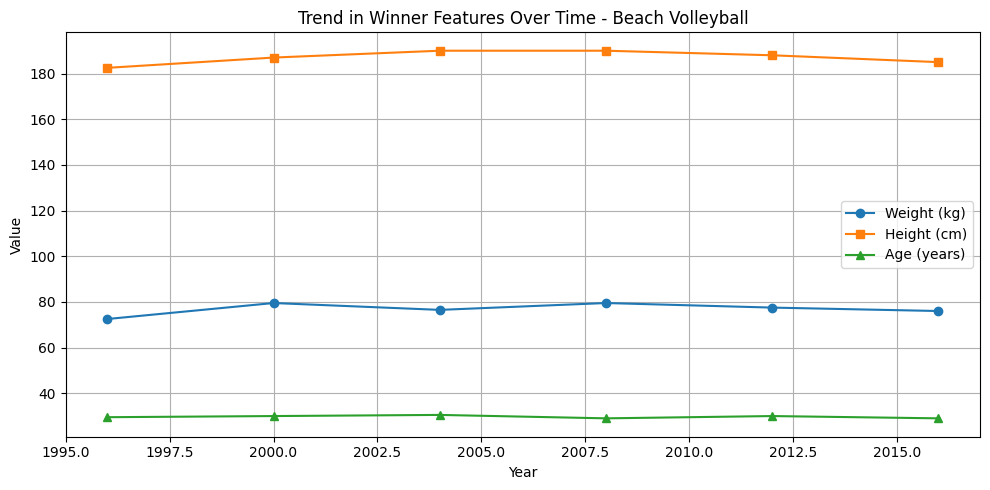

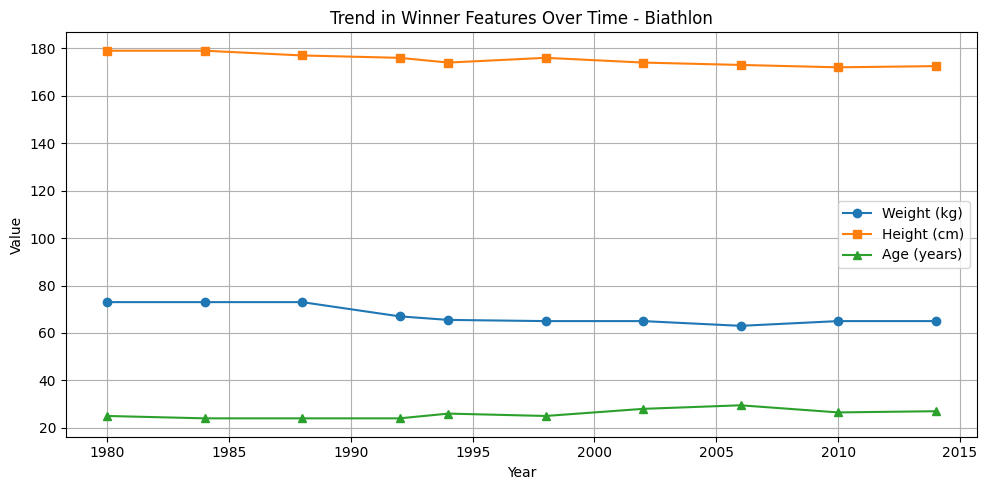

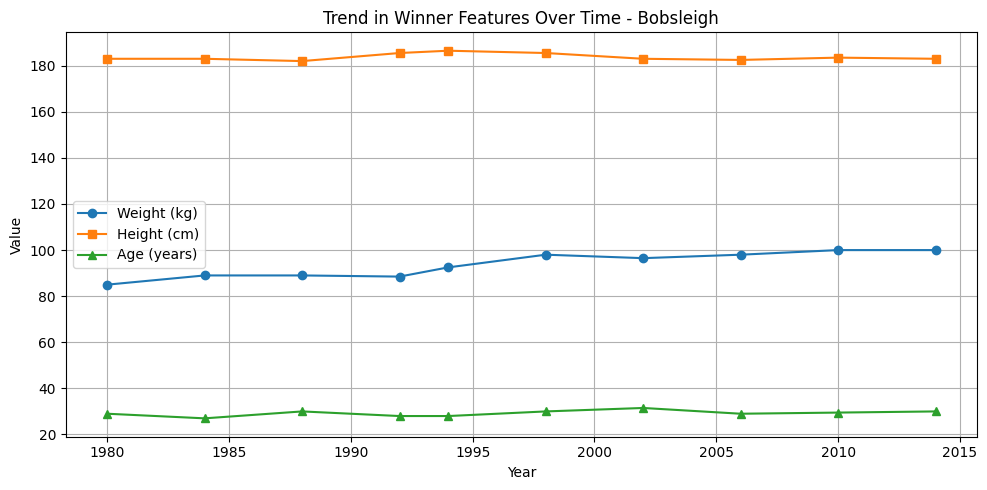

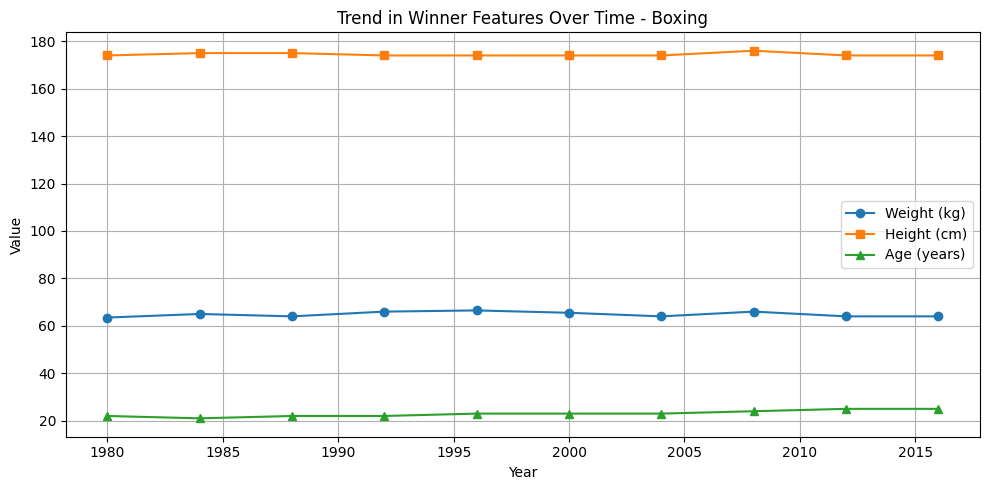

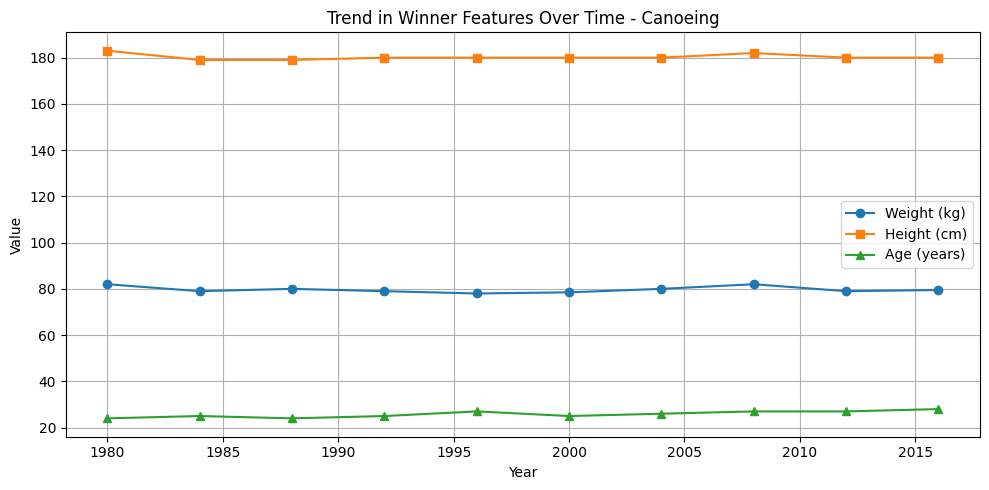

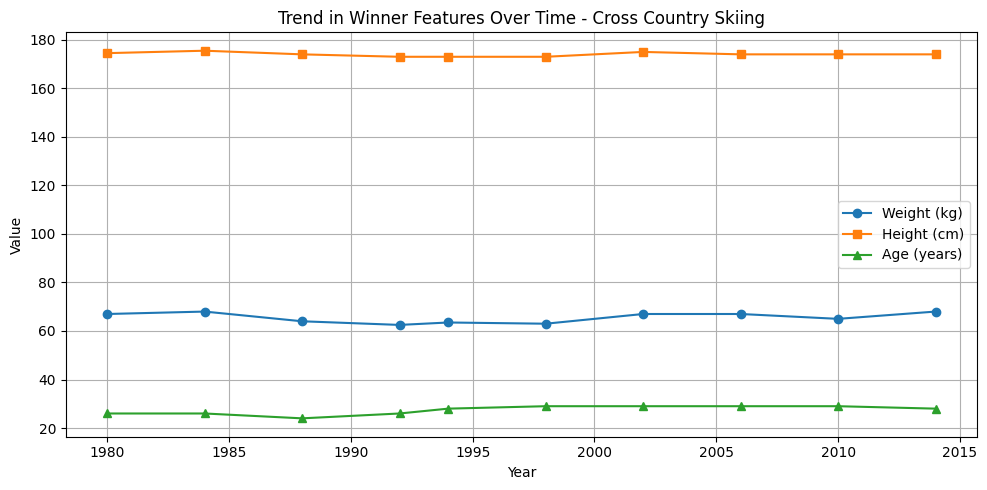

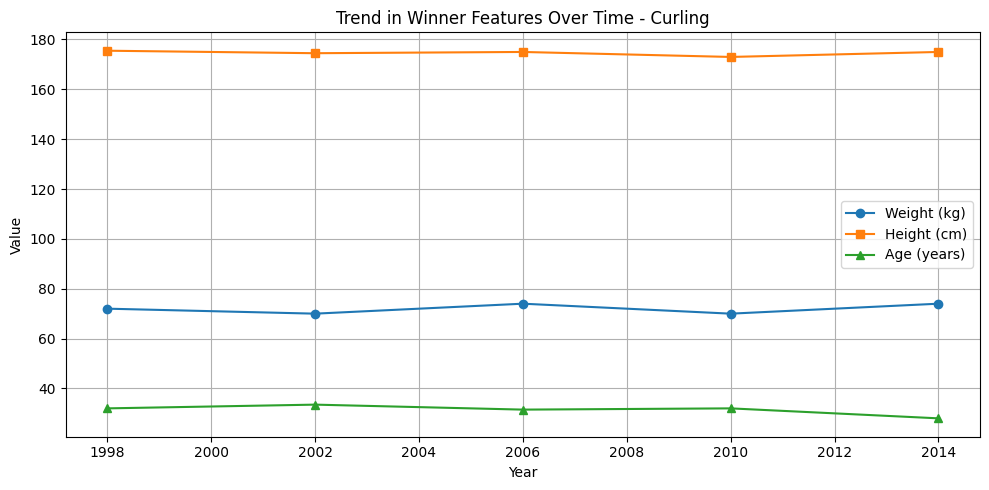

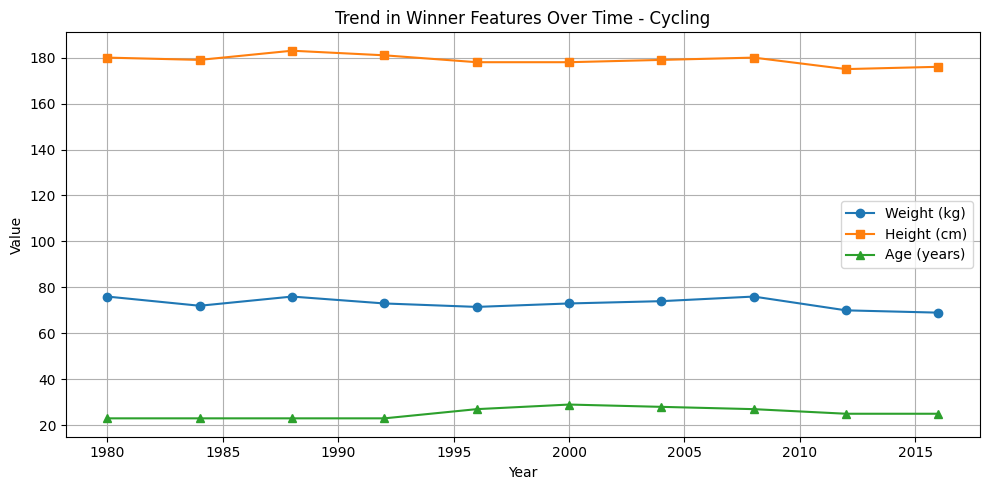

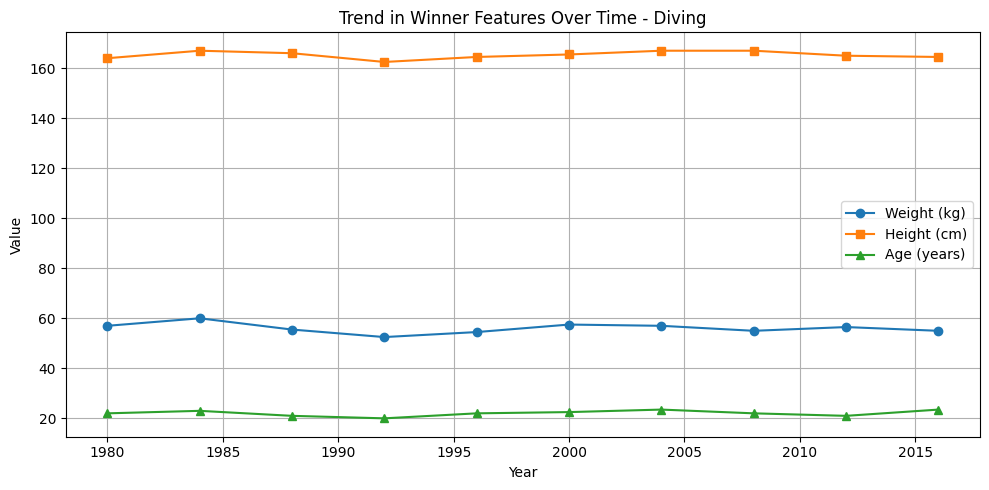

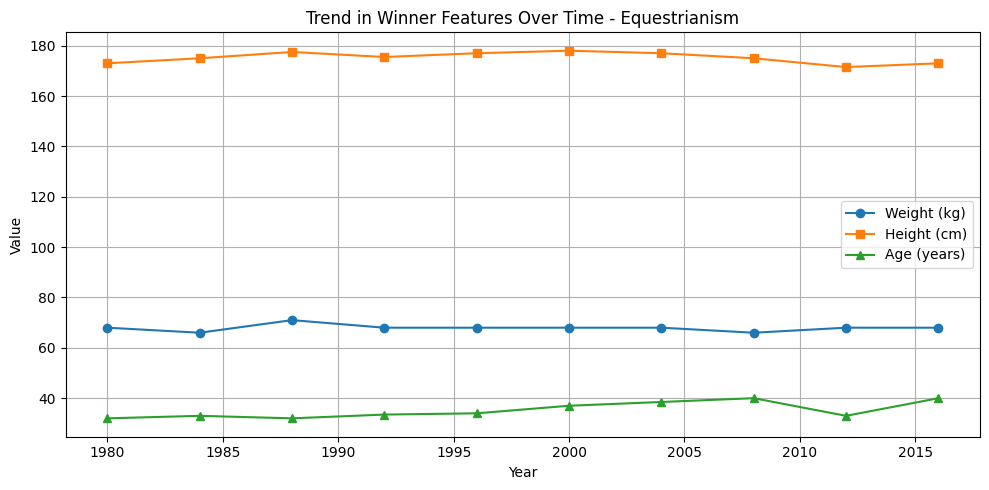

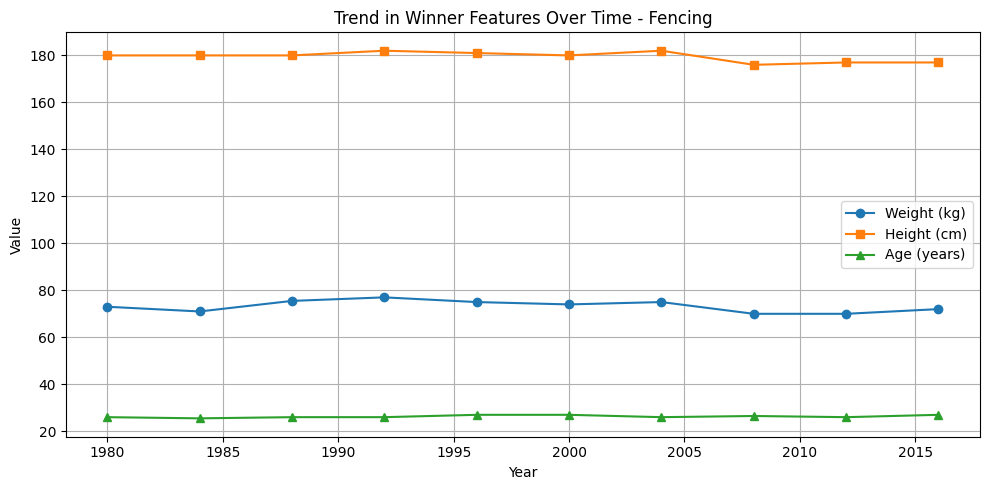

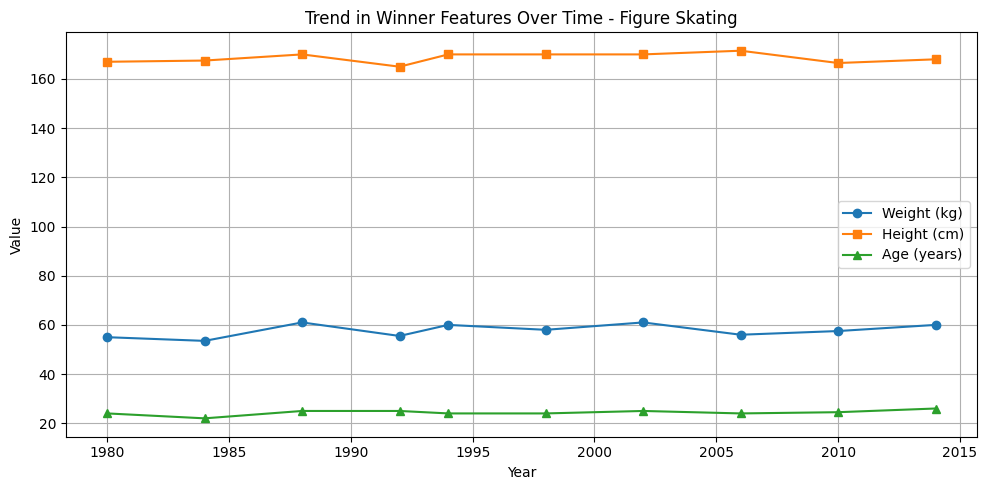

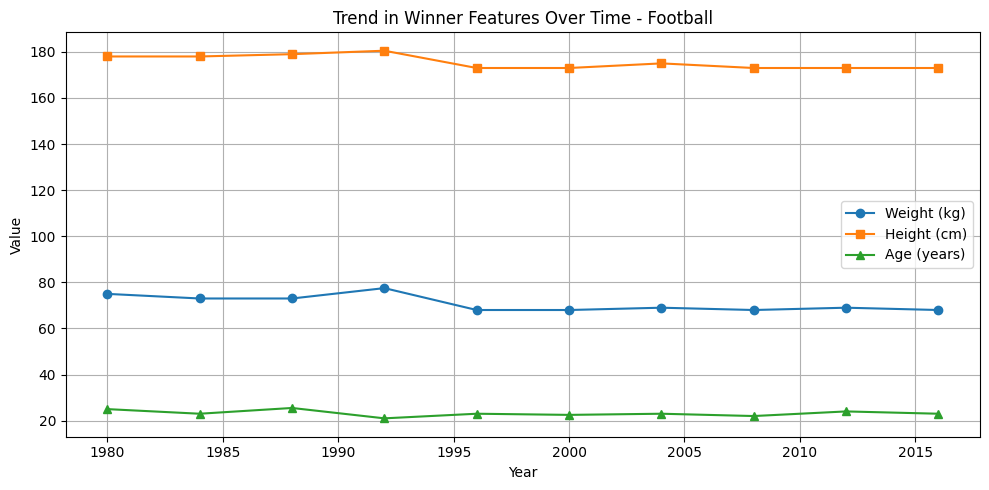

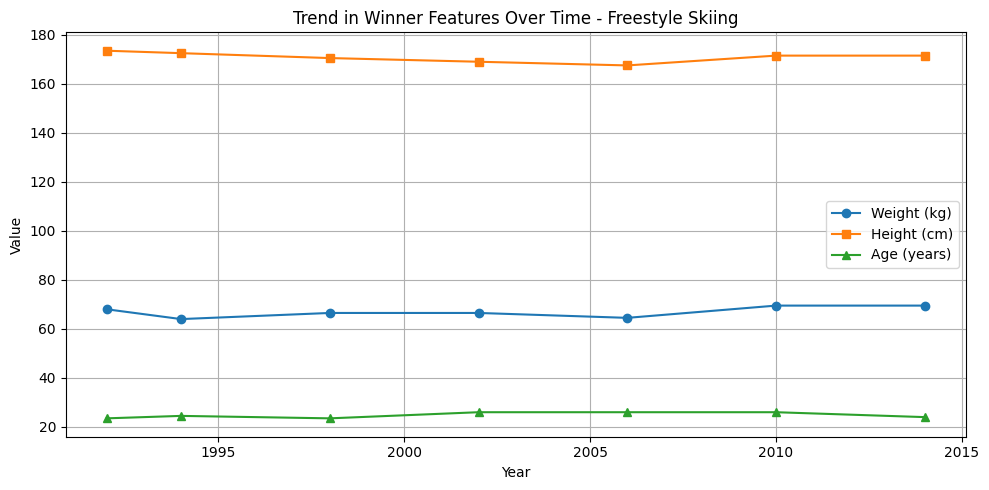

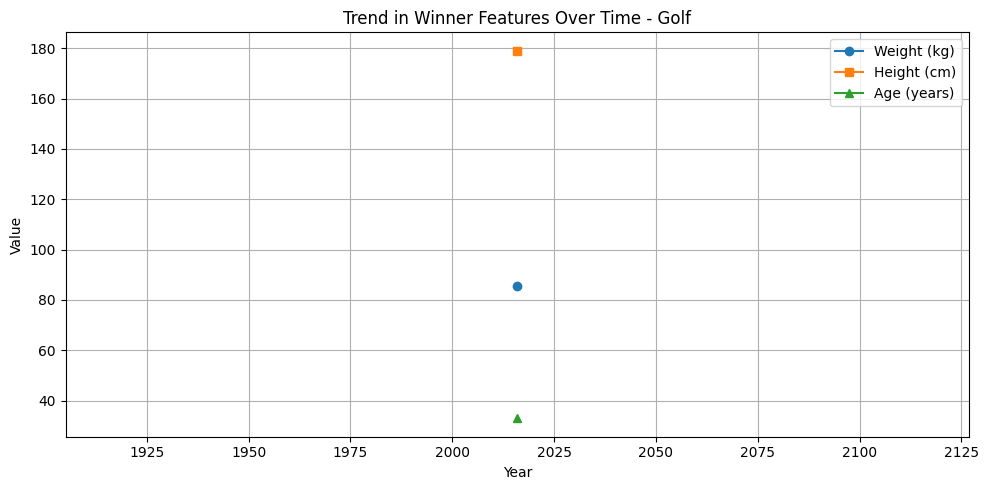

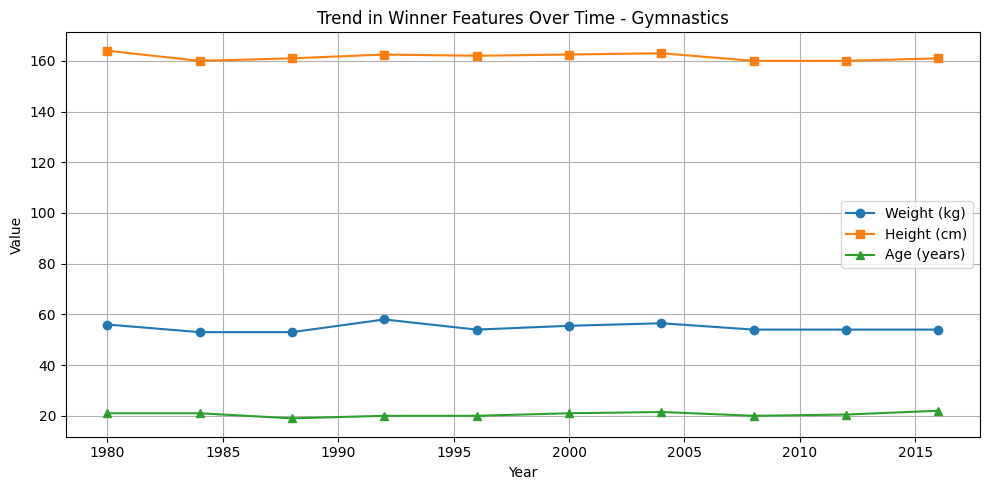

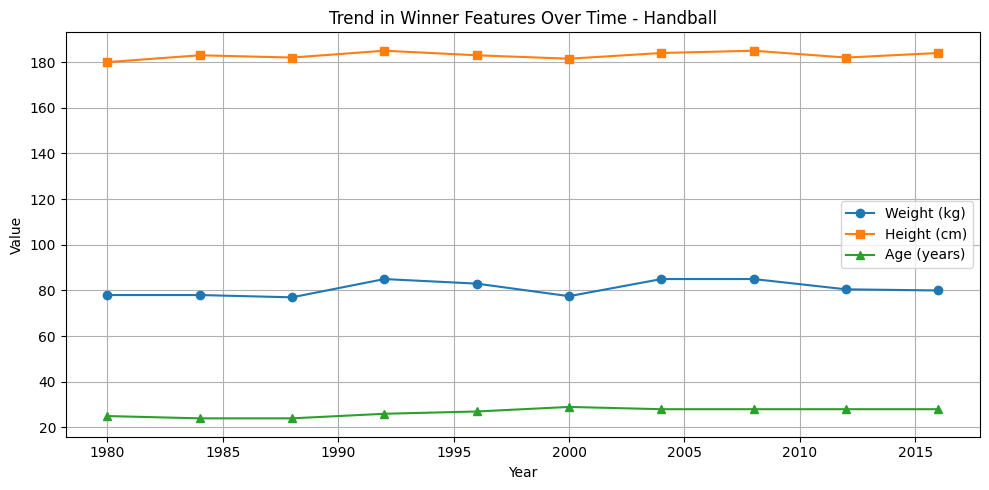

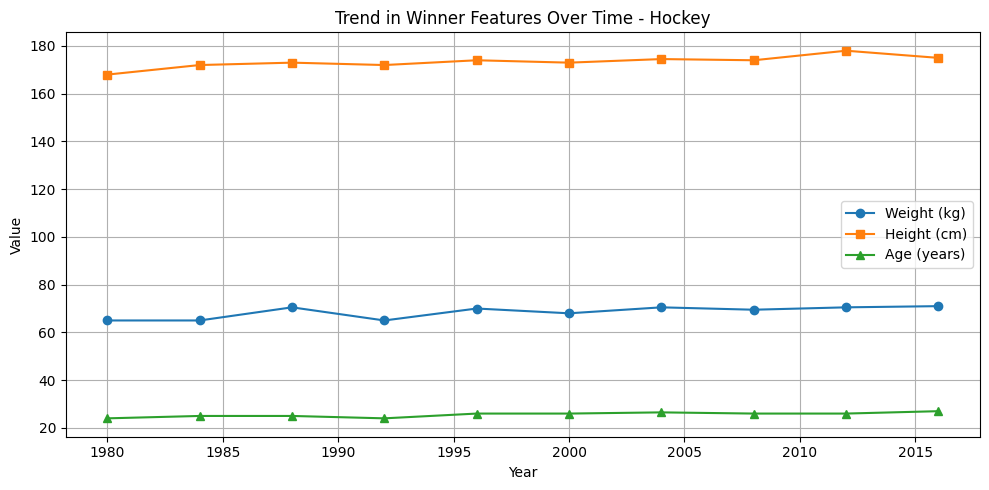

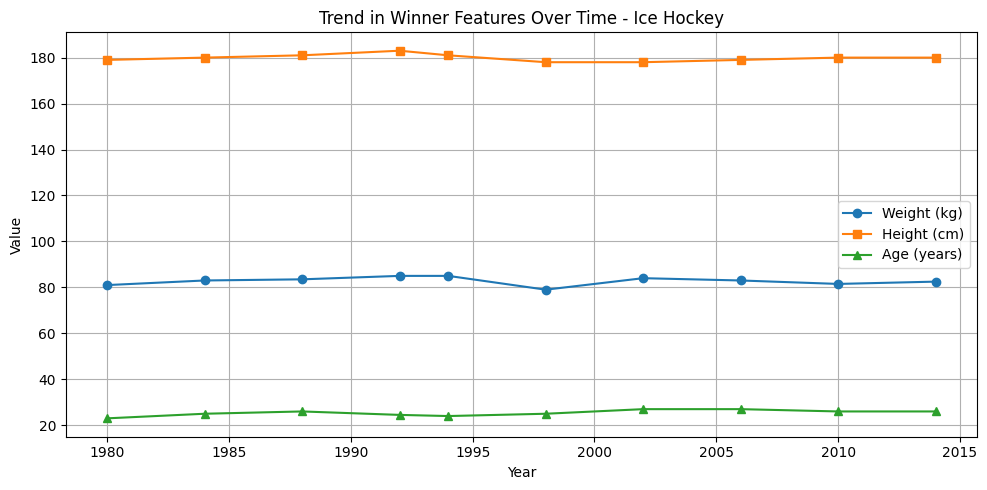

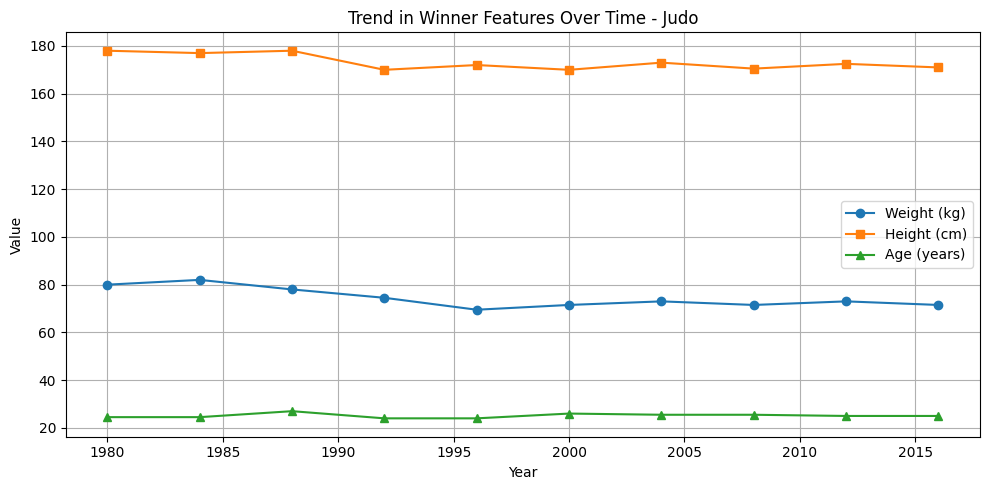

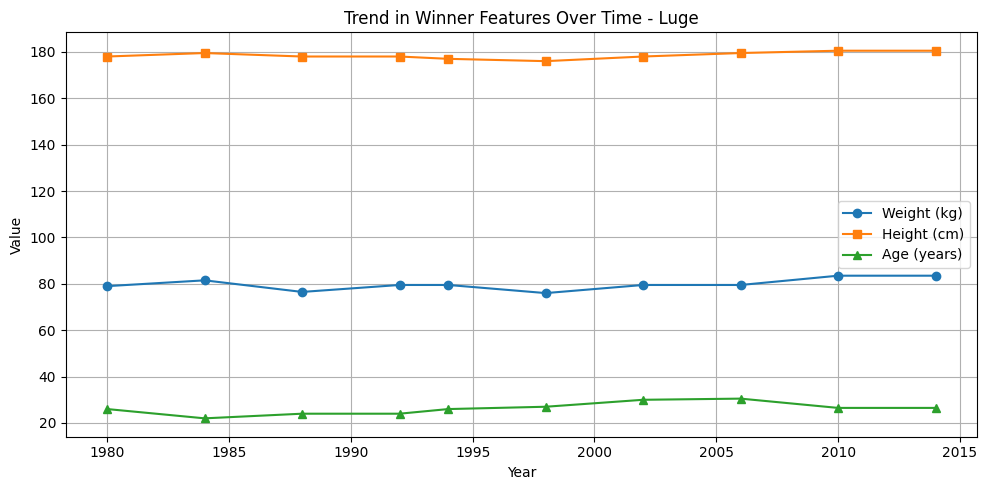

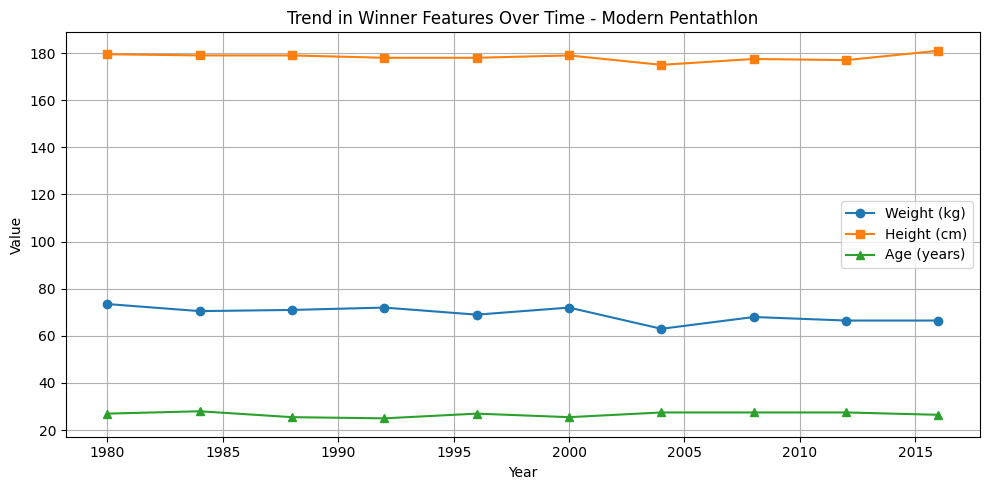

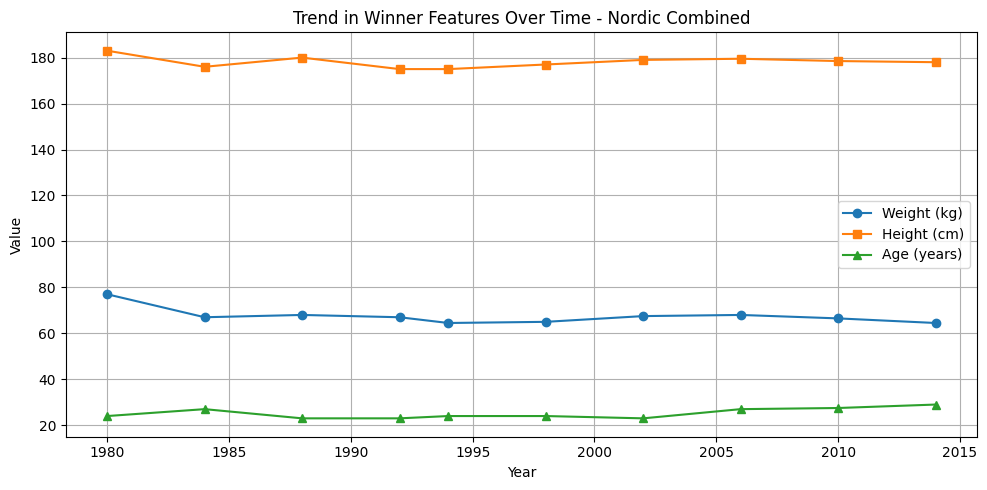

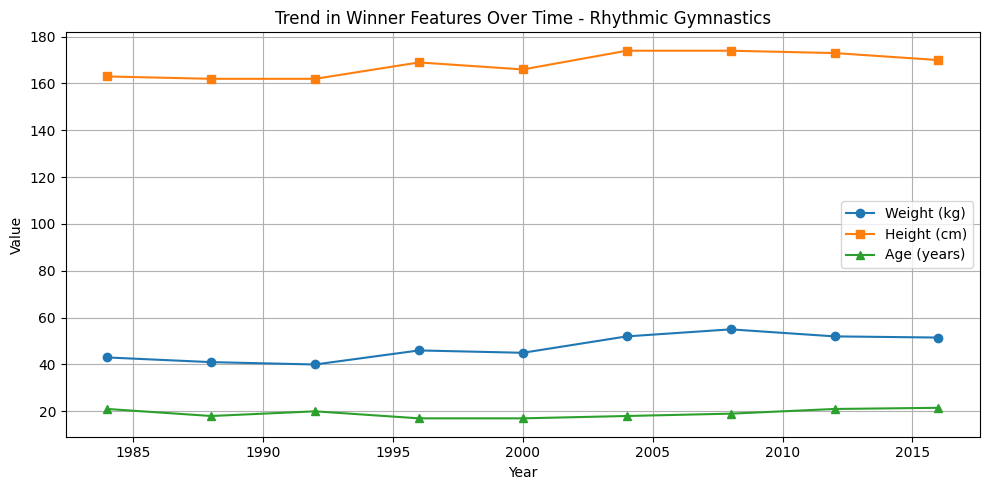

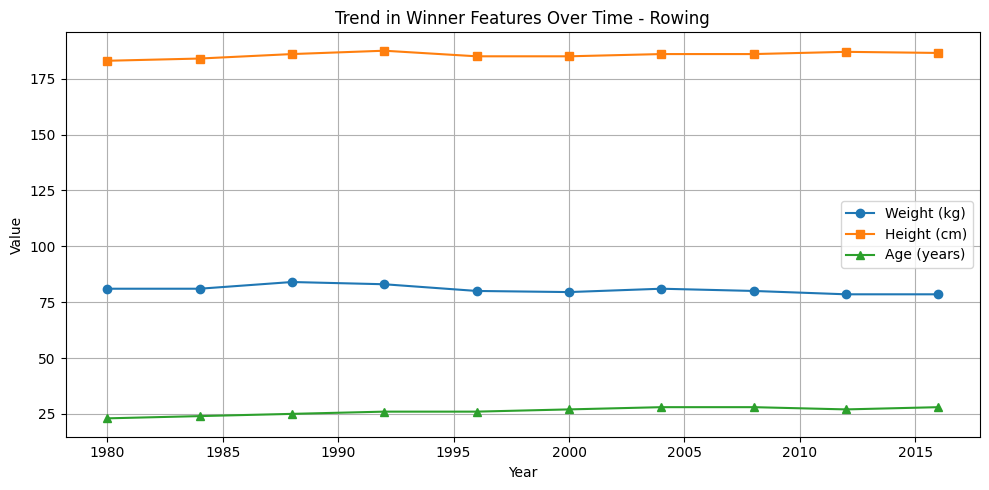

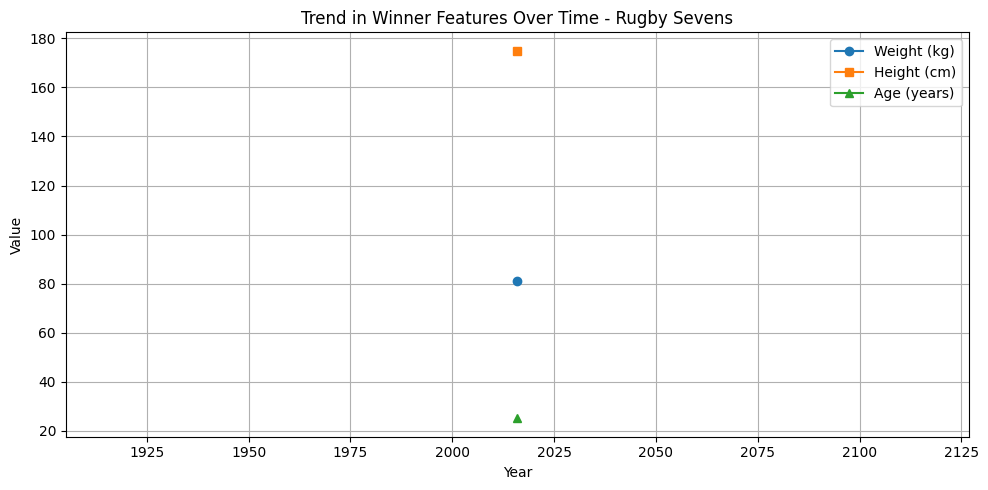

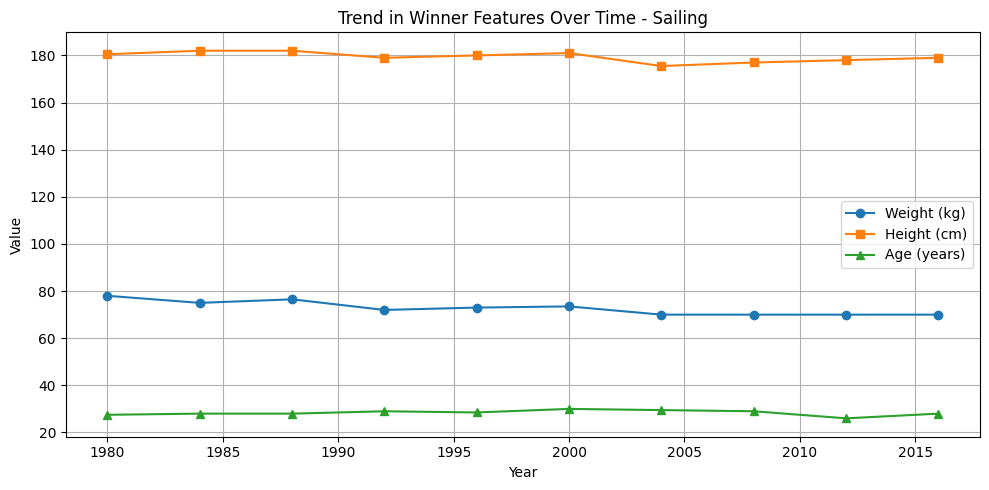

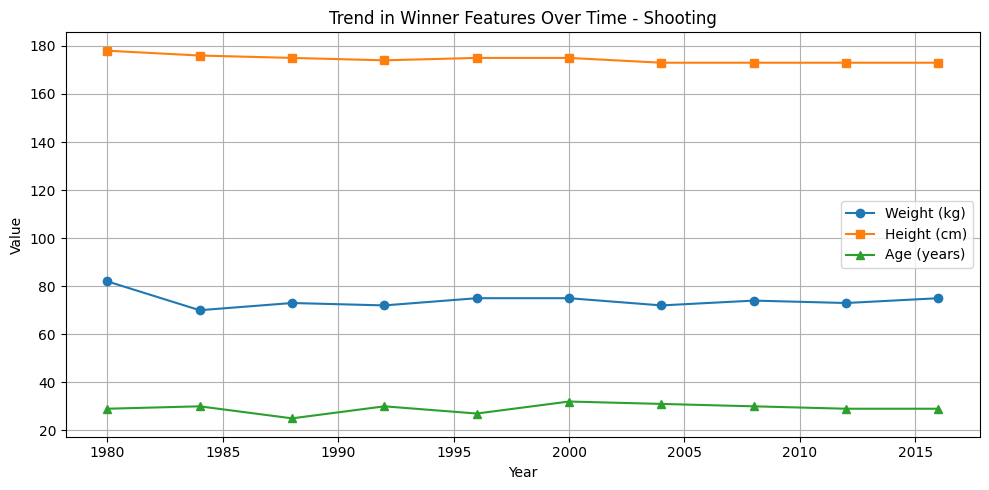

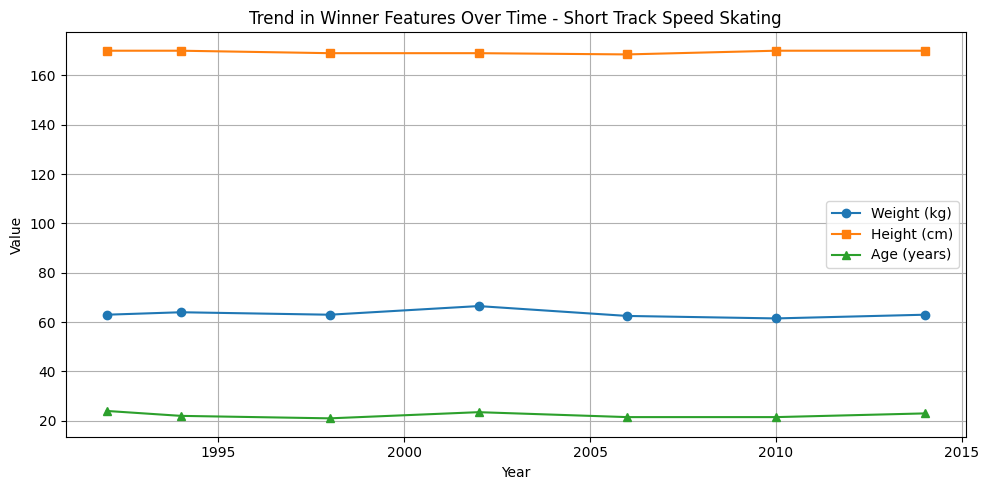

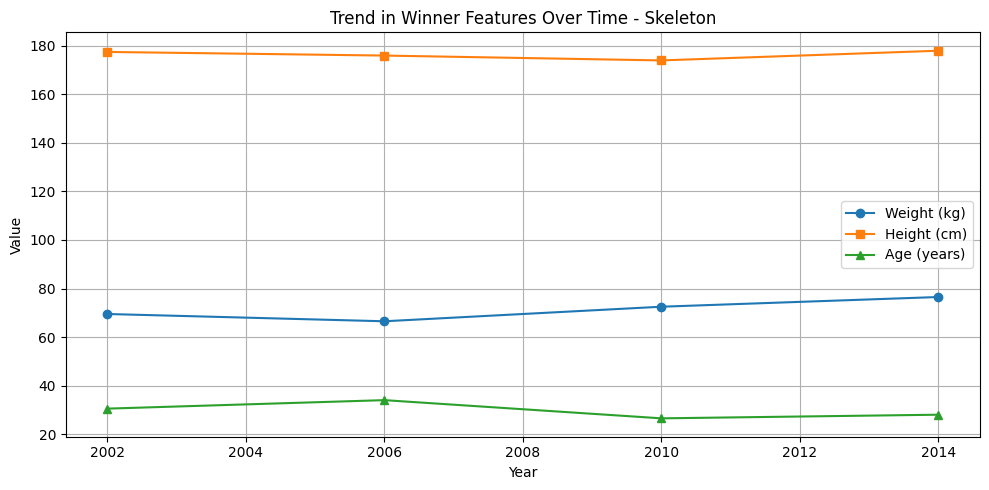

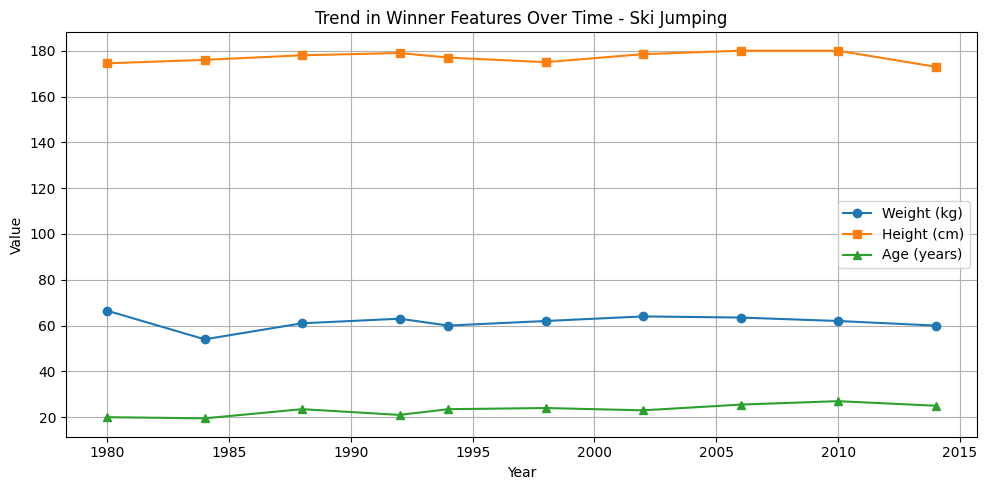

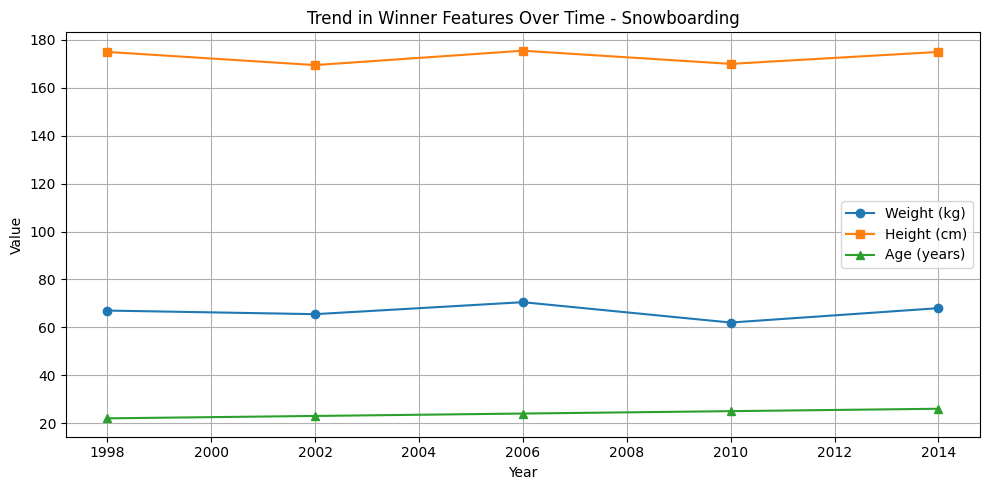

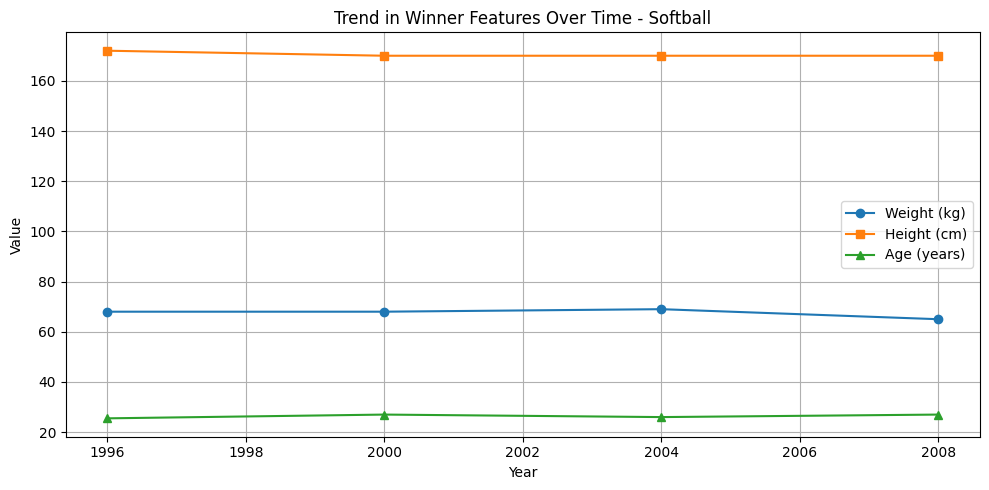

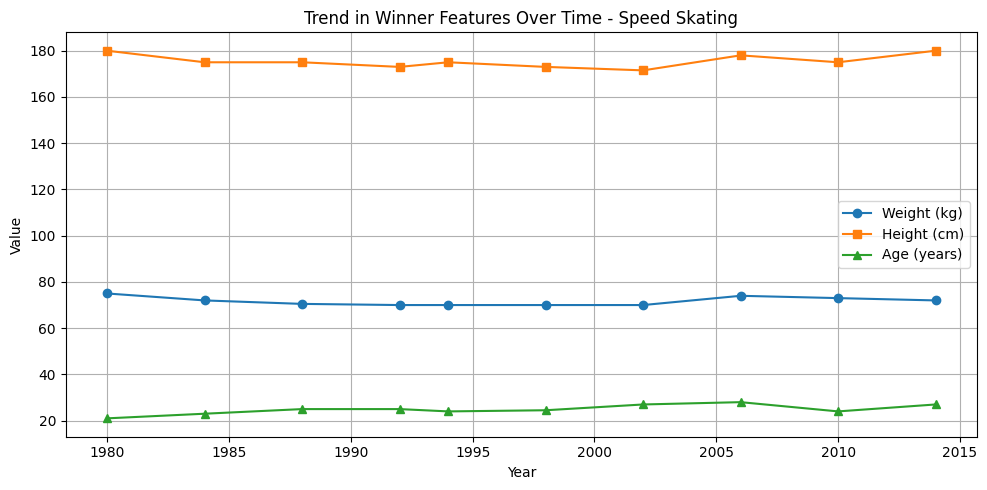

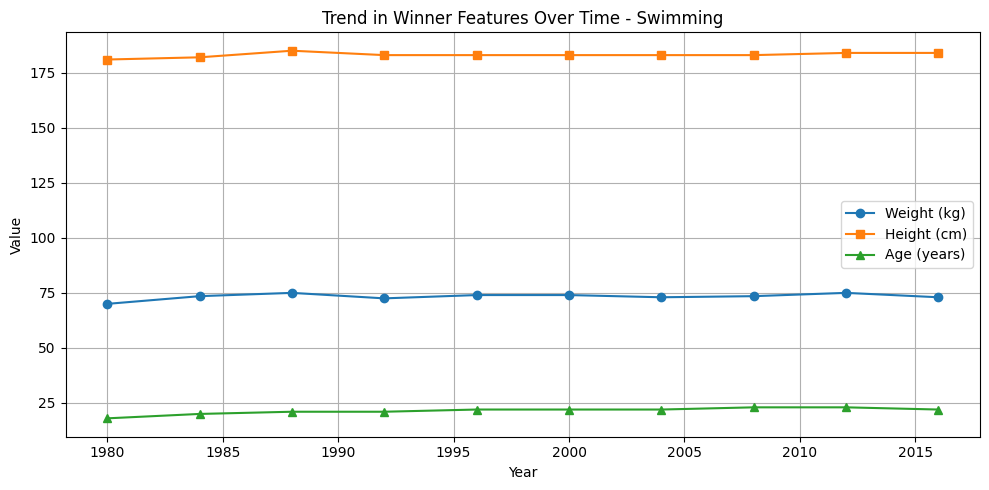

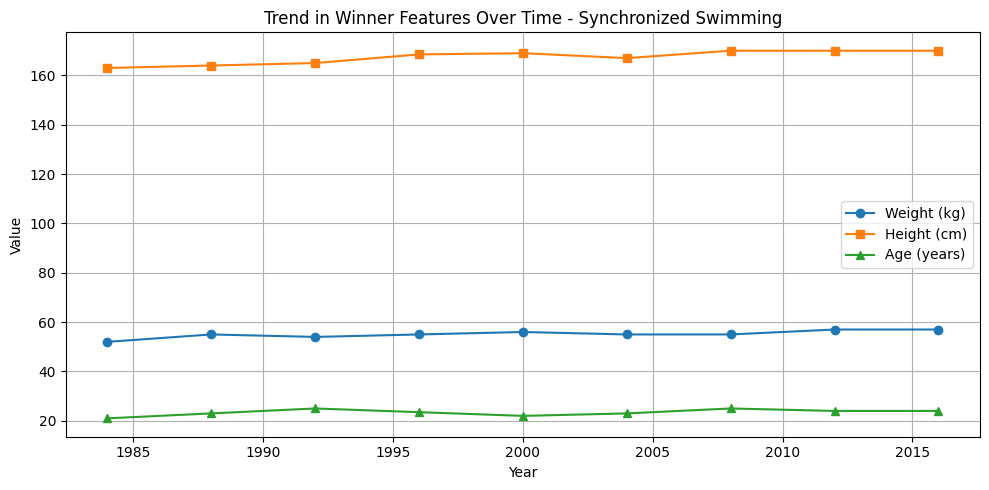

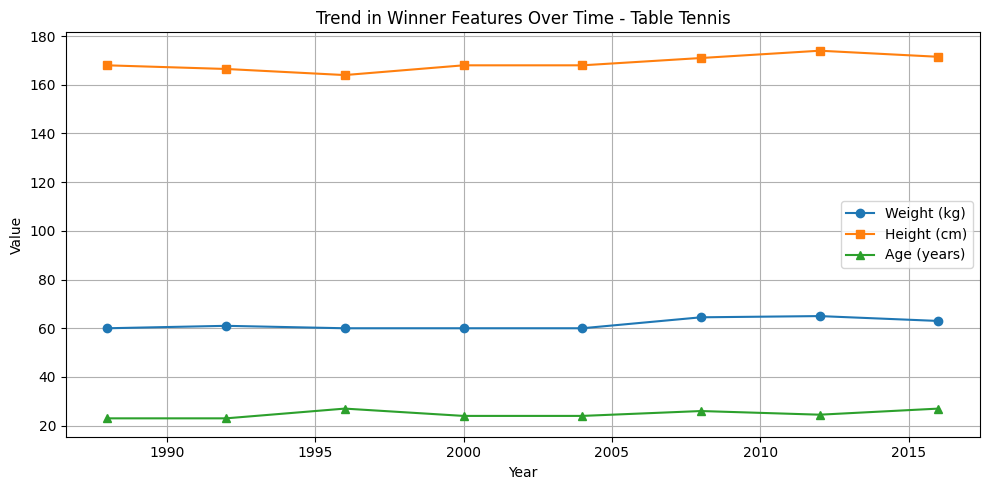

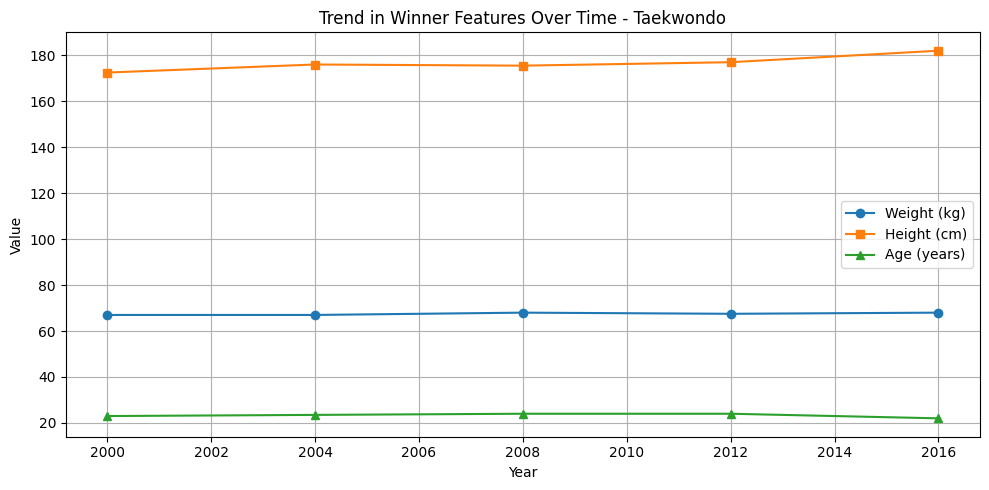

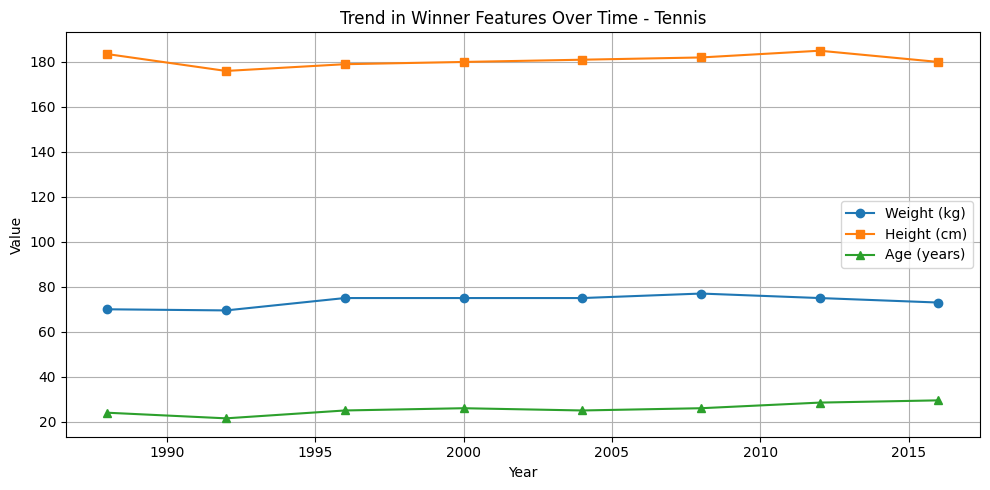

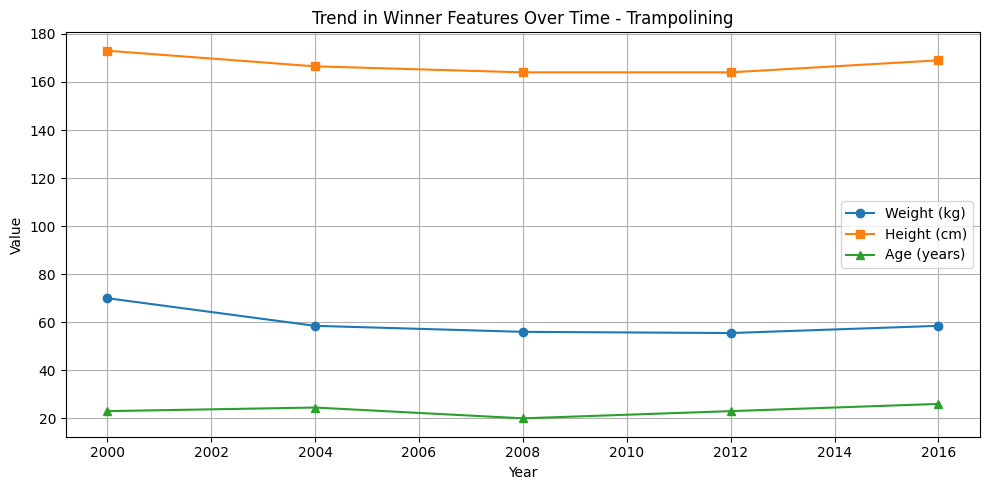

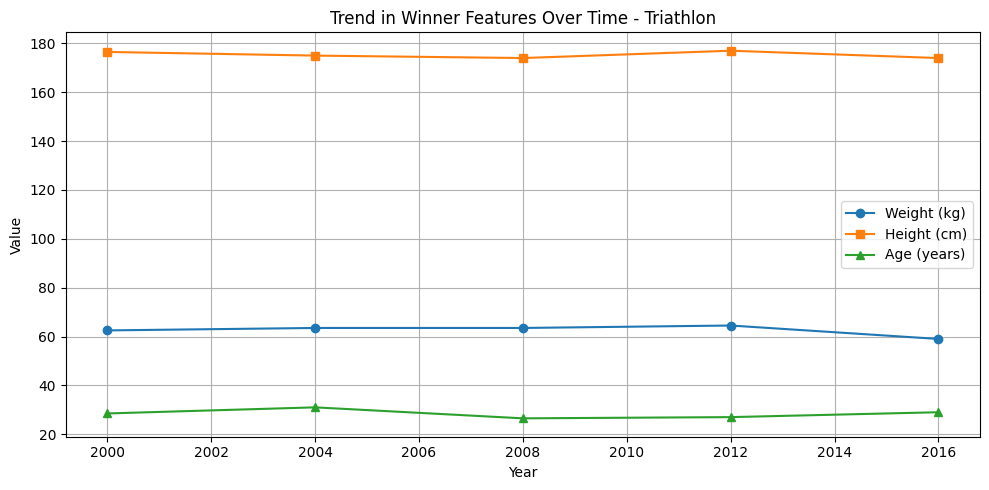

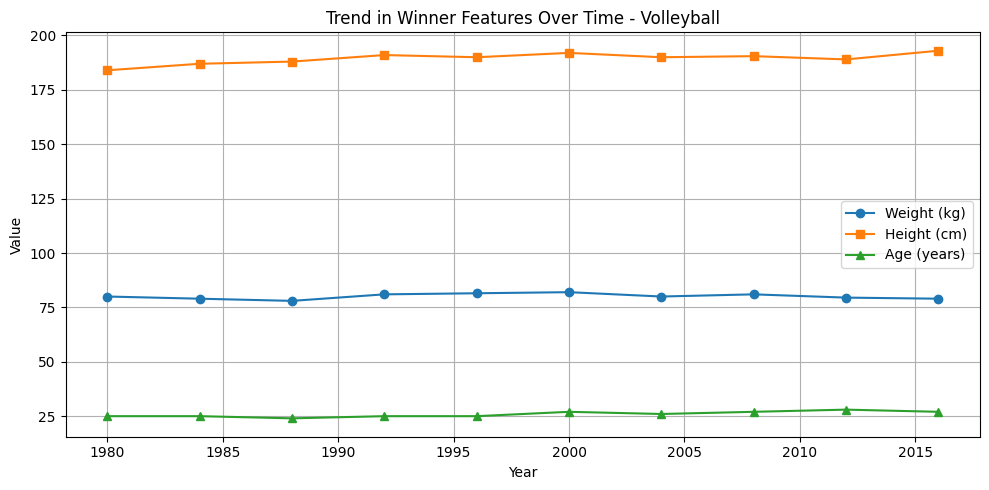

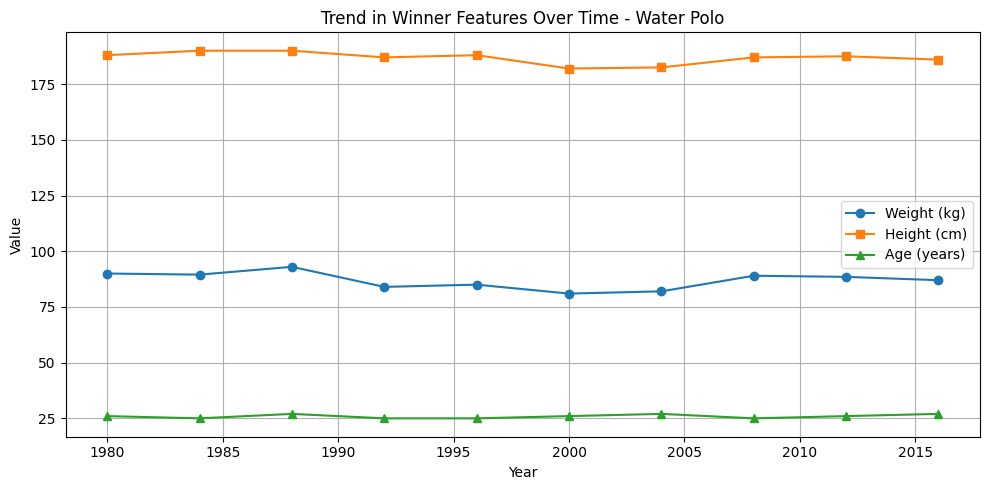

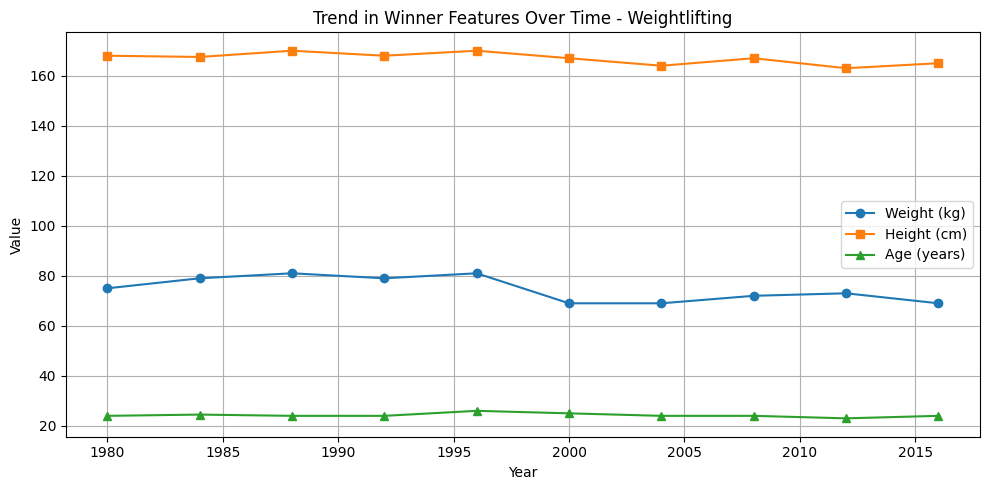

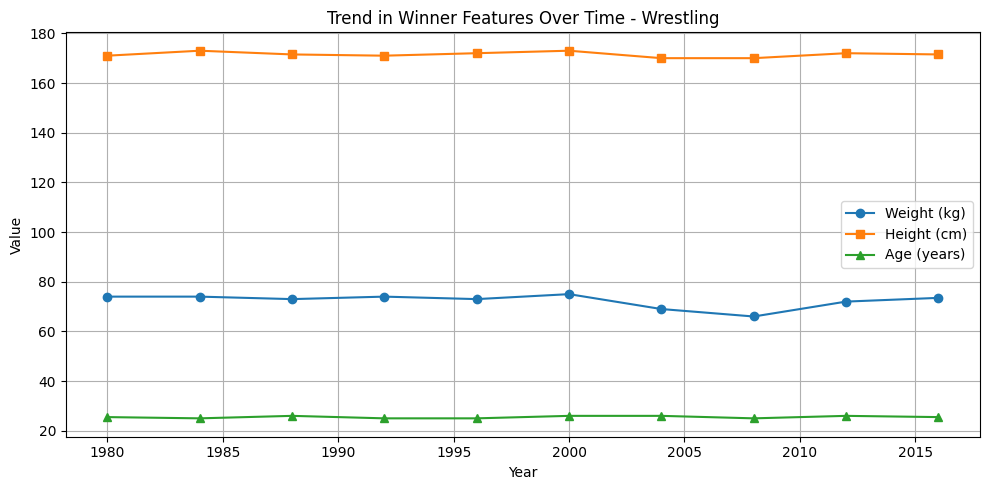

In [ ]:
# Get the list of all unique sports
all_sports = trend_by_sport_year['Sport'].unique()

# Create visualizations for all sports
for sport in all_sports:
    subset = trend_by_sport_year[trend_by_sport_year['Sport'] == sport]

    if subset.empty:
        continue

    plt.figure(figsize=(10, 5))
    plt.plot(subset['Year'], subset['Weight'], marker='o', label='Weight (kg)')
    plt.plot(subset['Year'], subset['Height'], marker='s', label='Height (cm)')
    plt.plot(subset['Year'], subset['Age'], marker='^', label='Age (years)')

    plt.title(f"Trend in Winner Features Over Time - {sport}")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 🏅 Olympic Athlete Trends and Strategic Recommendations by Sport

This analysis reveals how the physical characteristics of Olympic medal winners—**age**, **height**, and **weight**—have evolved from 1980 to 2016 across multiple sports. These trends offer valuable guidance for countries aiming to optimize athlete selection and training.

---

### 📊 Key Trends by Sport with Historical Context

#### 🎿 Alpine Skiing
- **Trend**: Weight and age have gradually increased; height is stable.
- **Context**: No major format changes, but improvements in ski technology and training have favored stronger and more experienced athletes.
- **Recommendation**: Focus on building strength and experience, particularly in athletes aged 25–30 with moderate height.

---

#### ⚾ Baseball
- **Trend**: Steady increase in height, weight, and age.
- **Context**: Olympic sport from 1992 to 2008 (then removed and later reinstated); changes in international representation impacted athlete development pipelines.
- **Recommendation**: Prioritize older, taller, and bulkier players; endurance and power are critical.

---

#### 🎯 Biathlon
- **Trend**: Slight decrease in height and weight; age shows some variation.
- **Context**: Women's events added in 1992; pursuit and mixed relay formats added later. Equipment improvements enhanced precision and consistency.
- **Recommendation**: Focus on younger, leaner athletes with high stamina and technical shooting skills.

---

#### 🛷 Bobsleigh
- **Trend**: Significant weight gain; minor height increase; age is stable.
- **Context**: Women's bobsleigh added in 2002. Continuous sled and track improvements increased the need for power and stability.
- **Recommendation**: Prioritize powerful, heavier athletes with explosive strength for high-speed starts.

---

#### ⛵ Sailing
- **Trend**: Mild variation across all metrics; older median age.
- **Context**: Frequent updates to sailing classes and equipment; greater emphasis on tactical skills. Gender balance efforts introduced mixed-gender formats.
- **Recommendation**: Experience and strategic thinking matter—support older, tactically adept sailors.

---

#### 🥌 Skeleton
- **Trend**: Slight increases in weight and age.
- **Context**: Reintroduced to Olympics in 2002. Safety and sled tech have evolved, rewarding strength and control.
- **Recommendation**: Choose sprint-capable athletes with controlled power and aerodynamic builds.

---

#### 🏐 Volleyball
- **Trend**: Increases in both height and weight; age is stable.
- **Context**: Rule changes like rally scoring (1990s) and the libero position (1998) changed game dynamics, emphasizing height and flexibility.
- **Recommendation**: Target tall, strong players with high agility and court awareness in their mid-to-late 20s.

---

#### 🏋️ Weightlifting
- **Trend**: Fluctuating weight/height; age stays in low-mid 20s.
- **Context**: Women's events introduced in 2000; frequent reclassification of weight categories.
- **Recommendation**: Focus on peak power lifters aged 22–26 with compact, powerful builds.

---

### 📌 General Observations
- **Team sports** favor taller, stronger, more physically specialized athletes.
- **Endurance and skill-based sports** show more tolerance for variance and emphasize experience.
- Rule changes and evolving formats have reshaped physical demands in nearly every discipline.

---

### 🧭 Strategic Recommendations for National Committees
1. **Use historical data** to define athlete selection benchmarks by sport.
2. **Adapt scouting pipelines** to match changing physical demands and event rules.
3. **Balance youth and experience**, especially in sports where maturity contributes to success.
4. **Support role specialization**, especially in team sports where new positions have emerged.
5. **Monitor rule and format changes**, which may shift the ideal athlete profile significantly.

---

By aligning selection, training, and investment strategies with evolving Olympic demands and athlete trends, countries can gain a competitive edge in medal-winning potential.


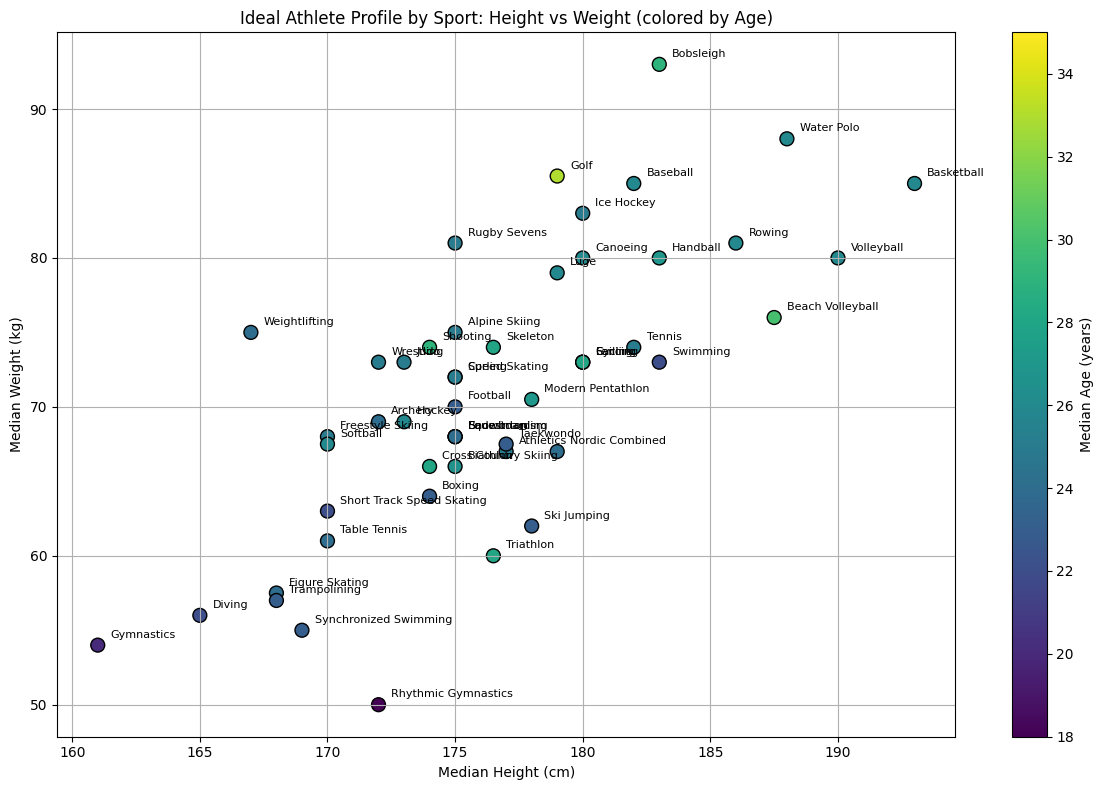

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("athlete_events.csv")

# Filter to medalists with complete Age, Height, Weight
medalists = df[df['Medal'].notna()].dropna(subset=['Age', 'Height', 'Weight'])

# Compute median (centroid) of Age, Height, Weight for each Sport
sport_medians = (
    medalists
    .groupby('Sport')[['Age', 'Height', 'Weight']]
    .median()
    .reset_index()
    .rename(columns={'Age': 'Median_Age', 'Height': 'Median_Height', 'Weight': 'Median_Weight'})
)

# Create scatter plot: Median Height vs Median Weight, colored by Median Age
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    sport_medians['Median_Height'],
    sport_medians['Median_Weight'],
    c=sport_medians['Median_Age'],
    cmap='viridis',
    s=100,
    edgecolors='k'
)

# Annotate each point with the sport name
for _, row in sport_medians.iterrows():
    plt.text(
        row['Median_Height'] + 0.5,  # small offset to avoid overlap
        row['Median_Weight'] + 0.5,
        row['Sport'],
        fontsize=8
    )

plt.colorbar(scatter, label='Median Age (years)')
plt.xlabel('Median Height (cm)')
plt.ylabel('Median Weight (kg)')
plt.title('Ideal Athlete Profile by Sport: Height vs Weight (colored by Age)')
plt.grid(True)
plt.tight_layout()
plt.show()


# 🏆 Key Insights from “Ideal Athlete Profile by Sport”

Below is a breakdown of what the scatter plot of **Median Height (cm) vs. Median Weight (kg)**—colored by **Median Age (years)**—tells us about each sport. Use these insights to inform talent scouting, training regimens, and long-term athlete development.

---

## 1. Quadrant & Color Patterns

1. **Bottom-Left (Shorter, Lighter, Younger)**  
   - **Sports:**  
     - **Gymnastics** (≈ 161 cm, 54 kg, Age ≈ 19)  
     - **Rhythmic Gymnastics** (≈ 172 cm, 50 kg, Age ≈ 18)  
     - **Diving** (≈ 165 cm, 56 kg, Age ≈ 22)  
     - **Synchronized Swimming** (≈ 169 cm, 55 kg, Age ≈ 23)  
   - **Color (Purple/Blue):** Younger medalists (≈ 18–22 years).  
   - **Interpretation:**  
     - These are sports that demand **explosive power**, **flexibility**, and often peak performance at a younger age.  
     - Countries should identify and nurture **pre-teen/teen talent**, focusing on early strength, flexibility, and artistic/technical skill development.

2. **Bottom-Right (Tall, Lean, Younger)**  
   - **Sports:**  
     - **Basketball** (≈ 193 cm, 85 kg, Age ≈ 26)  
     - **Volleyball** (≈ 190 cm, 80 kg, Age ≈ 27)  
     - **Water Polo** (≈ 188 cm, 88 kg, Age ≈ 27)  
     - **Rowing** (≈ 186 cm, 81 kg, Age ≈ 25)  
   - **Color (Blue/Teal):** Medalists in mid-20s (≈ 24–28 years).  
   - **Interpretation:**  
     - These team/power sports value **height** and **leanness** combined with endurance or explosive jumping.  
     - Countries that wish to excel should promote **youth basketball/volleyball programs** emphasizing skill development by mid-teens, and maintain strength/conditioning pipelines through early-20s.

3. **Top-Left (Shorter, Heavier, Older)**  
   - **Sports:**  
     - **Weightlifting** (≈ 167 cm, 75 kg, Age ≈ 24)  
     - **Boxing** (≈ 174 cm, 66 kg, Age ≈ 27)  
     - **Judo** (≈ 171 cm, 69 kg, Age ≈ 26)  
     - **Wrestling** (≈ 174 cm, 73 kg, Age ≈ 26)  
   - **Color (Teal/Green):** Medalists in mid-20s (≈ 24–27 years).  
   - **Interpretation:**  
     - Power/combat sports often peak in mid-20s once athletes have developed maximal strength and refined technique.  
     - Talent pipelines should identify promising athletes around **teenage years**, then build toward peak strength around **age 23–27**.

4. **Top-Right (Tall, Heavy, Older)**  
   - **Sports:**  
     - **Bobsleigh** (≈ 183 cm, 93 kg, Age ≈ 29)  
     - **Football (Soccer)** (≈ 176 cm, 70 kg, Age ≈ 25) – moderate though clustering here  
     - **Canoeing / Kayak** (≈ 180 cm, 73 kg, Age ≈ 26)  
     - **Handball** (≈ 183 cm, 80 kg, Age ≈ 27)  
     - **Baseball** (≈ 181 cm, 84 kg, Age ≈ 26)  
   - **Color (Green/Yellow):** Slightly older medalists (≈ 26–30 years).  
   - **Interpretation:**  
     - Strength/speed sports benefit from both height and substantial muscle mass developed over more years.  
     - Athletes often reach peak in **late 20s to early 30s**.  
     - Countries should maintain support for power/technique training well into the late-20s.

---

## 2. Sport Clusters & Typical Profiles

Below is a more structured grouping of sports by their approximate “body-type cluster,” with average medians extracted from the visualization:

| **Cluster**           | **Height ≈ [cm]** | **Weight ≈ [kg]** | **Age ≈ [years]** | **Representative Sports**                                                    |
|-----------------------|------------------|------------------|------------------|-------------------------------------------------------------------------------|
| **Youthful & Light**  | 160–175          | 50–60            | 18–22            | Gymnastics, Rhythmic Gymnastics, Diving, Synchronized Swimming                |
| **Mid-Youth Lean**    | 175–185          | 60–75            | 22–26            | Swimming, Table Tennis, Taekwondo, Fencing, Boxing                             |
| **Mid-Peak Power**    | 170–180          | 70–85            | 24–28            | Wrestling, Judo, Weightlifting, Badminton, Athletics (select events)          |
| **Peak Power & Size** | 180–195          | 80–95+           | 26–30            | Basketball, Volleyball, Bobsleigh, Rugby Sevens, Handball, Baseball, Rowing   |

### 👉 Interpretation
- **Cluster 1 (Youthful & Light):**  
  - Focus on early technical mastery and flexibility.  
  - Fast-twitch power is critical; training pipelines should begin in pre-adolescent years (ages 10–14).

- **Cluster 2 (Mid-Youth Lean):**  
  - Emphasis on speed, agility, and precision—often in technical or combat sports.  
  - Athletes begin specializing in **mid-teens** (14–16) and peak around early-to-mid-20s.

- **Cluster 3 (Mid-Peak Power):**  
  - Strength plus refined technique is key.  
  - Identification often in mid-teens, with strength programs continuing into mid- to late-20s.

- **Cluster 4 (Peak Power & Size):**  
  - Requires a combination of height, mass, and years of conditioning.  
  - Athletes often start specialized strength/endurance training in late-teens and hit peak performance in late-20s.

---

# 🧭 Recommendations for National Federations

Use the above body-type clusters to shape recruitment, training, and long-term development strategies by sport. Below are actionable guidelines:

---

## 1. Gymnastics & Diving & Similar “Youthful & Light” Disciplines
- **Target Recruitment (Ages 8–12):**  
  - Identify children with above-average flexibility, spatial awareness, and coordination.  
  - Run **talent ID** programs in local schools and gymnastics clubs.

- **Training Focus (Ages 12–18):**  
  - Emphasize **body control**, **flexibility**, and **early strength** (e.g., plyometrics, core stability).  
  - Monitor growth spurts carefully—adjust conditioning to prevent overuse injuries.

- **Peak Competition Window (Ages 16–22):**  
  - Enter high-performance camps and international meets early.  
  - Provide mentorship on injury prevention and nutrition to sustain growth through teenage years.

---

## 2. Combat Sports & Weightlifting (“Mid-Peak Power” Cluster)
- **Talent Scouting (Ages 12–16):**  
  - Seek out adolescents with natural **explosive strength** (e.g., through standardized strength/power tests).  
  - Look for early powerlifting or wrestling club standouts.

- **Physical Development (Ages 16–22):**  
  - Prioritize **progressive overload** strength programs, technique refinement, and sport-specific skill drills.  
  - Balance high-intensity lifting with mobility and injury-prevention protocols.

- **Peak Competition Window (Ages 22–28):**  
  - Plan for gradual **strength peaks** in mid-20s; avoid “burnout” by periodizing competition schedules.  
  - Include national/international “B-level” events around **age 20–22** for experience.

---

## 3. Team & Power Sports (“Peak Power & Size” Cluster)
- **Height + Mass Recruitment (Teens 14–18):**  
  - Run height-based talent ID in middle/high schools and sports academies (e.g., volleyball, basketball camps).  
  - Collaborate with basketball/volleyball clubs to track players’ growth trajectories.

- **Multi-Year Strength & Conditioning (Ages 18–24):**  
  - Implement comprehensive **strength-endurance** programs (e.g., weightlifting, plyometrics, sprint-work).  
  - Emphasize **periodization**:
    - **Foundation Phase (18–20):** Build aerobic capacity and basic strength.  
    - **Build Phase (20–24):** Increase sport-specific power (e.g., vertical jump training for basketball).

- **Peak Competition Window (Ages 24–30+):**  
  - Focus on tactical/skill refinement and recovery (e.g., sports science support—nutrition, physiotherapy).  
  - Field athletes in major international tournaments (World Championships, Continental Cups) starting **early-20s** for experience.

---

## 4. Endurance & Technical Sports (“Mid-Youth Lean” Cluster)
- **Early Technical Foundation (Ages 10–14):**  
  - Sports like **swimming, rowing** (lightweight), **table tennis** require **technical fluency** early.  
  - Develop spaced, high-quality coaching sessions (e.g., stroke mechanics, footwork).

- **Strength & Speed Development (Ages 14–18):**  
  - Integrate **plyometric** and **HIIT** (High-Intensity Interval Training) sessions to build fast-twitch muscle qualities.  
  - Start targeted resistance training (light weights, bodyweight drills).

- **Peak Competition Window (Ages 20–26):**  
  - Use **national development squads** to expose talent to international competition (e.g., junior world championships).  
  - Emphasize **sport‐science support** (aerobic/anaerobic testing, biomechanics analysis).

---

# 📈 Additional Strategic Notes

1. **Gender Balance & Age Variation**  
   - Some sports display slight gender-based shifts. For example:  
     - **Women’s Gymnastics** often peaks at age 17–19, whereas **Men’s Gymnastics** can peak at 20–22.  
     - Federations should tailor selection timelines (girls advancing earlier, boys slightly later) even within the same discipline.

2. **Evolving Ideals Over Time**  
   - Medalists in certain sports have gradually become **taller/heavier/older** (e.g., men’s volleyball, weightlifting).  
   - Continuously update talent-ID benchmarks every **4–8 years** to catch these shifts.

3. **Cross-Sport Insights**  
   - Some sports share overlapping profiles—e.g.:  
     - **Rowers** (mid-heavy builds) and **Water Polo** (heavy + tall) can cross-train in off-season to maintain aerobic power.  
     - **Sprinters (Athletics)** and **Rugby Sevens** cluster similarly by height/weight—sharing training methods like resisted sprints or power cleans.
   - Joint training camps or shared strength coaches can reduce overhead and foster cross-discipline learning.

4. **Host Country “Home Advantage”**  
   - Historical data often show that **host nations** boost representation in certain cluster profiles (e.g., track & field, swimming).  
   - Build robust “pre-home” training squads 4 years out if your country is bidding to host the Games.

---

## 🔑 Summary

- Each Olympic sport has a **distinct “ideal” age/height/weight** profile.  
- Countries should align their **talent identification** and **long-term athlete development** programs with these empirically‐derived ideals.  
- Regularly **update** these benchmarks (every Olympic cycle) to reflect the evolving nature of athlete physiques and rule changes.  
- When resources are limited, focus on sports where your nation’s existing demographic profile (e.g., average height, youth pipeline) best matches the “ideal” cluster.  

By systematically applying these insights, federations can maximize their chances of producing medal–winning athletes in each discipline.
